# Arabic Punctuation Restoration

# **تحميل المكتبات المطلوبة**

In [1]:
# تثبيت المكتبات الضرورية لمعالجة اللغة العربية والتعلم العميق
!pip install camel_tools transformers torch scikit-learn seaborn pandas matplotlib \
                   tqdm arabic-reshaper python-bidi

# تحميل قاعدة بيانات الصرف العربي
!camel_data -i morphology-db-msa-r13

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 158.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 137.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 128.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.3/122.3 kB 12.0 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=b79cf064aaed9662c78fded384395245b651170cb7518d5a335c6725be82a285
  Stored

The following packages will be installed: 'morphology-db-msa-r13'
Extracting package 'morphology-db-msa-r13': 100% 40.5M/40.5M [00:00<00:00, 643MB/s]


# الثوابت العامة للمشروع

## هذه الخلية تحتوي على جميع الثوابت والإعدادات الرئيسية للمشروع

---
يمكن تعديل هذه القيم حسب الحاجة دون الحاجة لتعديل باقي الكود


In [1]:
import os
from datetime import datetime

# ==================== مسارات الملفات والمجلدات ====================

from google.colab import drive # للوصول إلى الدرايف
drive.mount('/content/drive')

# مسار مجلد بيانات التدريب
TRAIN_DATA_DIR = "./drive/MyDrive/train"

# مسار مجلد بيانات الاختبار
TEST_DATA_DIR = "./drive/MyDrive/test"

# مسار حفظ النماذج المدربة
MODELS_SAVE_DIR = "./drive/MyDrive/AP/saved_models"

# مسار حفظ ملفات السجلات
LOGS_DIR = "./logs"

# ==================== إعدادات التدريب ====================
# الحد الأقصى لطول التسلسل
MAX_LENGTH = 256

# حجم الدفعة للتدريب والتقييم
BATCH_SIZE = 16

# حجم القطعة للقراءة من الملفات
CHUNK_SIZE = MAX_LENGTH

# معدل التعلم
LEARNING_RATE = 2e-5

# عدد الحقب - إذا كانت القيمة -1 يستمر التدريب حتى نهاية البيانات
EPOCHS = 5

# عدد التكرارات لكل حقبة - إذا كانت القيمة -1 يستمر حتى نهاية البيانات
MAX_ITERATIONS_PER_EPOCH = 800

# عدد الطيات للتحقق المتقاطع
CROSS_VALIDATION_FOLDS = 5

# ==================== إعدادات مستوى التفصيل ====================
# مستويات التفصيل المتاحة:
# 0 = صامت - لا طباعة
# 1 = أساسي - رسائل الخطأ والنجاح الرئيسية فقط
# 2 = عادي - معلومات التقدم الأساسية
# 3 = مفصل - جميع المعلومات التفصيلية
# 4 = تصحيح - معلومات التصحيح الكاملة
VERBOSITY_LEVEL = 4

# ==================== تعريف علامات الترقيم ====================
# رموز التصنيف
LABEL_SPACE = "_"
LABEL_COMMA = "comma"
LABEL_PERIOD = "period"
LABEL_QUESTION = "question"
LABEL_EXCLAMATION = "exclamation"
LABEL_COLON = "colon"
LABEL_SEMICOLON = "semicolon"

# قاموس تحويل الحروف إلى تصنيفات
CHAR_TO_LABEL = {
    " ": LABEL_SPACE,
    "،": LABEL_COMMA,
    ".": LABEL_PERIOD,
    "؟": LABEL_QUESTION,
    "!": LABEL_EXCLAMATION,
    ":": LABEL_COLON,
    "؛": LABEL_SEMICOLON,
}

# قاموس تحويل التصنيفات إلى معرفات رقمية
LABEL_TO_ID = {
    LABEL_SPACE: 0,
    LABEL_COMMA: 1,
    LABEL_PERIOD: 2,
    LABEL_QUESTION: 3,
    LABEL_EXCLAMATION: 4,
    LABEL_COLON: 5,
    LABEL_SEMICOLON: 6,
}

# قاموس عكسي من المعرفات إلى التصنيفات
ID_TO_LABEL = {v: k for k, v in LABEL_TO_ID.items()}

# قاموس عكسي من التصنيفات إلى الحروف
LABEL_TO_CHAR = {v: k for k, v in CHAR_TO_LABEL.items()}

# قيمة التجاهل في حساب الخسارة
IGNORE_INDEX = -100

# ==================== قائمة النماذج للتدريب ====================
MODELS_CONFIG = [
    {
        "name": "arabert",
        "model_id": "aubmindlab/bert-base-arabertv02",
        "display_name": "AraBERT v02",
        "type": "token_classification"  # نوع النموذج
    },
    {
        "name": "araelectra",
        "model_id": "aubmindlab/araelectra-base-discriminator",
        "display_name": "AraELECTRA",
        "type": "token_classification"
    },
    {
        "name": "camelbert",
        "model_id": "CAMeL-Lab/bert-base-arabic-camelbert-mix",
        "display_name": "CAMeLBERT",
        "type": "token_classification"
    },
]

# ==================== إعدادات التجارب ====================
# تشغيل مع تحليل أقسام الكلام
RUN_WITH_POS = True

# تشغيل بدون تحليل أقسام الكلام
RUN_WITHOUT_POS = True

# حفظ أفضل نموذج بناءً على الدقة
SAVE_BEST_MODEL = True

# حفظ آخر نموذج
SAVE_LAST_MODEL = True

# تردد حفظ نقاط التفتيش (كل كم تكرار)
CHECKPOINT_FREQUENCY = 100

# ==================== إنشاء المجلدات ====================
# إنشاء مجلد النماذج إذا لم يكن موجوداً
os.makedirs(MODELS_SAVE_DIR, exist_ok=True)

# إنشاء مجلد السجلات إذا لم يكن موجوداً
os.makedirs(LOGS_DIR, exist_ok=True)

# طباعة تأكيد تحميل الثوابت
print("تم تحميل الثوابت العامة بنجاح")
print(f"مجلد النماذج: {MODELS_SAVE_DIR}")
print(f"مجلد السجلات: {LOGS_DIR}")
print(f"عدد النماذج للتدريب: {len(MODELS_CONFIG)}")

Mounted at /content/drive
تم تحميل الثوابت العامة بنجاح
مجلد النماذج: ./drive/MyDrive/AP/saved_models
مجلد السجلات: ./logs
عدد النماذج للتدريب: 3


# استيراد المكتبات المطلوبة

## هذه الخلية تستورد جميع المكتبات اللازمة للمشروع

In [2]:
# ==================== مكتبات النظام ====================
import os  # للتعامل مع نظام الملفات
import sys  # للتعامل مع النظام
import logging  # لإدارة السجلات
import json  # للتعامل مع ملفات JSON
import string  # للتعامل مع النصوص
from datetime import datetime  # للتعامل مع التواريخ
from typing import Dict, List, Tuple, Optional, Any, Iterator  # للتوثيق النوعي
from collections import defaultdict  # للقواميس الافتراضية
import warnings  # لإدارة التحذيرات

# تجاهل التحذيرات غير الضرورية
warnings.filterwarnings('ignore')

# ==================== مكتبات التعلم العميق ====================
import torch  # المكتبة الرئيسية للتعلم العميق
from torch.utils.data import Dataset, DataLoader, IterableDataset  # لإدارة البيانات
from torch.optim import AdamW  # محسن AdamW

# ==================== مكتبات المحولات ====================
from transformers import (
    AutoTokenizer,  # لتحميل المجزئ تلقائياً
    AutoModelForTokenClassification,  # لتحميل نموذج التصنيف
    DataCollatorForTokenClassification,  # لتجميع البيانات
)

# ==================== مكتبات التحليل والتقييم ====================
from sklearn.metrics import (
    classification_report,  # تقرير التصنيف
    confusion_matrix,  # مصفوفة الارتباك
    ConfusionMatrixDisplay,  # عرض مصفوفة الارتباك
    precision_recall_fscore_support,  # مقاييس الدقة والاستدعاء
    accuracy_score,  # دقة التصنيف
)
from sklearn.model_selection import KFold  # للتحقق المتقاطع

# ==================== مكتبات معالجة البيانات ====================
import numpy as np  # للعمليات الرياضية
import pandas as pd  # لإدارة البيانات الجدولية

# ==================== مكتبات الرسم ====================
import matplotlib.pyplot as plt  # للرسم البياني
import arabic_reshaper  # للرسم العربي
from bidi.algorithm import get_display  # للعرض العربي
import matplotlib.font_manager as fm # للتحكم بالخطوط
import seaborn as sns  # للرسوم البيانية المتقدمة

# تعيين نمط الرسم
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# ==================== مكتبات معالجة اللغة العربية ====================
from camel_tools.morphology.analyzer import Analyzer  # محلل الصرف
from camel_tools.morphology.database import MorphologyDB  # قاعدة بيانات الصرف
from camel_tools.tokenizers.word import simple_word_tokenize  # مجزئ الكلمات

# ==================== مكتبات التقدم ====================
from tqdm import tqdm  # شريط التقدم

print("تم استيراد جميع المكتبات بنجاح")

تم استيراد جميع المكتبات بنجاح


#فئة مسجل الدفتر

##هذه الفئة مسؤولة عن إدارة جميع عمليات التسجيل والطباعة
---
تدعم مستويات متعددة من التفصيل وتحفظ السجلات في ملفات منفصلة


In [3]:
class NotebookLogger:
    """
    فئة لإدارة التسجيل والطباعة في الدفتر

    تدعم هذه الفئة:
    - مستويات متعددة من التفصيل
    - حفظ السجلات في ملفات منفصلة
    - تسجيل لكل نموذج ولكل خطوة
    """

    # ثوابت مستويات التسجيل
    SILENT = 0      # صامت
    BASIC = 1       # أساسي
    NORMAL = 2      # عادي
    DETAILED = 3    # مفصل
    DEBUG = 4       # تصحيح

    def __init__(
        self,
        logs_dir: str = LOGS_DIR,
        verbosity: int = VERBOSITY_LEVEL,
        session_name: str = None
    ):
        """
        تهيئة المسجل

        Args:
            logs_dir: مسار مجلد السجلات
            verbosity: مستوى التفصيل
            session_name: اسم الجلسة (اختياري)
        """
        # حفظ الإعدادات
        self.logs_dir = logs_dir
        self.verbosity = verbosity

        # إنشاء اسم الجلسة إذا لم يُعطَ
        if session_name is None:
            self.session_name = datetime.now().strftime("%Y%m%d_%H%M%S")
        else:
            self.session_name = session_name

        # إنشاء مجلد الجلسة
        self.session_dir = os.path.join(logs_dir, self.session_name)
        os.makedirs(self.session_dir, exist_ok=True)

        # قاموس لحفظ معالجات الملفات
        self.file_handlers: Dict[str, logging.FileHandler] = {}

        # قاموس لحفظ المسجلات
        self.loggers: Dict[str, logging.Logger] = {}

        # إنشاء المسجل الرئيسي
        self._setup_main_logger()

        # تسجيل بدء الجلسة
        self.info("main", f"بدء جلسة جديدة: {self.session_name}")
        self.info("main", f"مستوى التفصيل: {self.verbosity}")

    def _setup_main_logger(self) -> None:
        """إعداد المسجل الرئيسي"""
        # إنشاء المسجل الرئيسي
        self._get_or_create_logger("main")

    def _get_or_create_logger(self, name: str) -> logging.Logger:
        """
        الحصول على مسجل موجود أو إنشاء واحد جديد

        Args:
            name: اسم المسجل

        Returns:
            كائن المسجل
        """
        # التحقق من وجود المسجل
        if name in self.loggers:
            return self.loggers[name]

        # إنشاء مسجل جديد
        logger = logging.getLogger(f"notebook_{self.session_name}_{name}")
        logger.setLevel(logging.DEBUG)

        # إزالة المعالجات القديمة إن وجدت
        logger.handlers = []

        # إنشاء ملف السجل
        log_file = os.path.join(self.session_dir, f"{name}.log")
        file_handler = logging.FileHandler(log_file, encoding='utf-8')
        file_handler.setLevel(logging.DEBUG)

        # تنسيق السجل
        formatter = logging.Formatter(
            '%(asctime)s | %(levelname)s | %(message)s',
            datefmt='%Y-%m-%d %H:%M:%S'
        )
        file_handler.setFormatter(formatter)

        # إضافة المعالج للمسجل
        logger.addHandler(file_handler)

        # حفظ المراجع
        self.loggers[name] = logger
        self.file_handlers[name] = file_handler

        return logger

    def _should_print(self, level: int) -> bool:
        """
        التحقق من إمكانية الطباعة حسب مستوى التفصيل

        Args:
            level: مستوى الرسالة

        Returns:
            True إذا كان يجب الطباعة
        """
        return self.verbosity >= level

    def debug(self, logger_name: str, message: str) -> None:
        """
        تسجيل رسالة تصحيح

        Args:
            logger_name: اسم المسجل
            message: نص الرسالة
        """
        logger = self._get_or_create_logger(logger_name)
        logger.debug(message)

        if self._should_print(self.DEBUG):
            print(f"[تصحيح] [{logger_name}] {message}")

    def info(self, logger_name: str, message: str) -> None:
        """
        تسجيل رسالة معلومات

        Args:
            logger_name: اسم المسجل
            message: نص الرسالة
        """
        logger = self._get_or_create_logger(logger_name)
        logger.info(message)

        if self._should_print(self.NORMAL):
            print(f"[معلومات] [{logger_name}] {message}")

    def warning(self, logger_name: str, message: str) -> None:
        """
        تسجيل رسالة تحذير

        Args:
            logger_name: اسم المسجل
            message: نص الرسالة
        """
        logger = self._get_or_create_logger(logger_name)
        logger.warning(message)

        if self._should_print(self.BASIC):
            print(f"[تحذير] [{logger_name}] {message}")

    def error(self, logger_name: str, message: str) -> None:
        """
        تسجيل رسالة خطأ

        Args:
            logger_name: اسم المسجل
            message: نص الرسالة
        """
        logger = self._get_or_create_logger(logger_name)
        logger.error(message)

        if self._should_print(self.BASIC):
            print(f"[خطأ] [{logger_name}] {message}")

    def success(self, logger_name: str, message: str) -> None:
        """
        تسجيل رسالة نجاح

        Args:
            logger_name: اسم المسجل
            message: نص الرسالة
        """
        logger = self._get_or_create_logger(logger_name)
        logger.info(f"SUCCESS: {message}")

        if self._should_print(self.BASIC):
            print(f"[نجاح] [{logger_name}] {message}")

    def progress(self, logger_name: str, current: int, total: int, message: str = "") -> None:
        """
        تسجيل تقدم العملية

        Args:
            logger_name: اسم المسجل
            current: القيمة الحالية
            total: القيمة الإجمالية
            message: رسالة إضافية
        """
        # حساب النسبة المئوية
        percentage = (current / total * 100) if total > 0 else 0

        logger = self._get_or_create_logger(logger_name)
        logger.info(f"PROGRESS: {current}/{total} ({percentage:.1f}%) - {message}")

        if self._should_print(self.DETAILED):
            print(f"[تقدم] [{logger_name}] {current}/{total} ({percentage:.1f}%) - {message}")

    def metrics(self, logger_name: str, metrics_dict: Dict[str, float]) -> None:
        """
        تسجيل المقاييس

        Args:
            logger_name: اسم المسجل
            metrics_dict: قاموس المقاييس
        """
        logger = self._get_or_create_logger(logger_name)

        # تحويل المقاييس إلى نص
        metrics_str = " | ".join([f"{k}: {v:.4f}" for k, v in metrics_dict.items()])
        logger.info(f"METRICS: {metrics_str}")

        if self._should_print(self.NORMAL):
            print(f"[مقاييس] [{logger_name}] {metrics_str}")

    def create_model_logger(self, model_name: str, with_pos: bool) -> str:
        """
        إنشاء مسجل خاص بنموذج معين

        Args:
            model_name: اسم النموذج
            with_pos: هل يستخدم تحليل أقسام الكلام

        Returns:
            اسم المسجل المُنشأ
        """
        # إنشاء اسم المسجل
        pos_suffix = "with_pos" if with_pos else "without_pos"
        logger_name = f"{model_name}_{pos_suffix}"

        # إنشاء المسجل
        self._get_or_create_logger(logger_name)

        # تسجيل بدء التدريب
        self.info(logger_name, f"بدء تسجيل النموذج: {model_name}")
        self.info(logger_name, f"استخدام تحليل أقسام الكلام: {with_pos}")

        return logger_name

    def save_results(self, results: Dict[str, Any], filename: str) -> str:
        """
        حفظ النتائج في ملف JSON

        Args:
            results: النتائج للحفظ
            filename: اسم الملف

        Returns:
            مسار الملف المحفوظ
        """
        # إنشاء مسار الملف
        filepath = os.path.join(self.session_dir, f"{filename}.json")

        # تحويل المصفوفات إلى قوائم
        def convert_to_serializable(obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            elif isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, dict):
                return {k: convert_to_serializable(v) for k, v in obj.items()}
            elif isinstance(obj, list):
                return [convert_to_serializable(item) for item in obj]
            return obj

        # حفظ الملف
        serializable_results = convert_to_serializable(results)
        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(serializable_results, f, ensure_ascii=False, indent=2)

        self.info("main", f"تم حفظ النتائج في: {filepath}")

        return filepath

    def close(self) -> None:
        """إغلاق جميع معالجات الملفات"""
        for handler in self.file_handlers.values():
            handler.close()

        self.info("main", "تم إغلاق جميع ملفات السجلات")


# إنشاء المسجل العام
logger = NotebookLogger(
    logs_dir=LOGS_DIR,
    verbosity=VERBOSITY_LEVEL
)

print("تم إنشاء مسجل الدفتر بنجاح")
print(f"مجلد السجلات: {logger.session_dir}")

INFO:notebook_20251226_211055_main:بدء جلسة جديدة: 20251226_211055
INFO:notebook_20251226_211055_main:مستوى التفصيل: 4


[معلومات] [main] بدء جلسة جديدة: 20251226_211055
[معلومات] [main] مستوى التفصيل: 4
تم إنشاء مسجل الدفتر بنجاح
مجلد السجلات: ./logs/20251226_211055


#تهيئة الجهاز ومحلل الصرف

##هذه الخلية تقوم بتهيئة جهاز الحوسبة ومحلل الصرف العربي

In [4]:
# ==================== تهيئة جهاز الحوسبة ====================
# التحقق من توفر GPU واستخدامه إن وجد
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# تسجيل نوع الجهاز
logger.info("main", f"جهاز الحوسبة المستخدم: {DEVICE}")

# طباعة معلومات GPU إن وجد
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    logger.info("main", f"اسم GPU: {gpu_name}")
    logger.info("main", f"ذاكرة GPU: {gpu_memory:.2f} GB")

# ==================== تهيئة محلل الصرف ====================
# تحميل قاعدة بيانات الصرف العربي
logger.info("main", "جاري تحميل قاعدة بيانات الصرف العربي...")

try:
    # تحميل قاعدة البيانات المدمجة
    morphology_db = MorphologyDB.builtin_db()

    # إنشاء محلل الصرف
    morphology_analyzer = Analyzer(morphology_db)

    logger.success("main", "تم تحميل محلل الصرف بنجاح")

except Exception as e:
    logger.error("main", f"خطأ في تحميل محلل الصرف: {str(e)}")
    morphology_analyzer = None


def get_pos_tags(words: List[str]) -> List[str]:
    """
    الحصول على أقسام الكلام لقائمة من الكلمات

    Args:
        words: قائمة الكلمات

    Returns:
        قائمة أقسام الكلام
    """
    # التحقق من توفر المحلل
    if morphology_analyzer is None:
        return ["UNK"] * len(words)

    result = []

    for word in words:
        # تحليل الكلمة
        analyses = morphology_analyzer.analyze(word)

        if analyses and len(analyses) > 0:
            # أخذ أول تحليل
            pos = analyses[0].get('pos', 'UNK')
            result.append(pos)
        else:
            result.append('UNK')

    return result


# ==================== اختبار محلل الصرف ====================
# اختبار بسيط للتحقق من عمل المحلل
test_words = ['سعيد', 'يرسم', 'هرة']
test_pos = get_pos_tags(test_words)

logger.info("main", f"اختبار محلل الصرف:")
for word, pos in zip(test_words, test_pos):
    logger.debug("main", f"  {word} -> {pos}")

print(f"جهاز الحوسبة: {DEVICE}")
print(f"اختبار محلل الصرف: {list(zip(test_words, test_pos))}")

INFO:notebook_20251226_211055_main:جهاز الحوسبة المستخدم: cuda
INFO:notebook_20251226_211055_main:اسم GPU: Tesla T4
INFO:notebook_20251226_211055_main:ذاكرة GPU: 15.83 GB
INFO:notebook_20251226_211055_main:جاري تحميل قاعدة بيانات الصرف العربي...


[معلومات] [main] جهاز الحوسبة المستخدم: cuda
[معلومات] [main] اسم GPU: Tesla T4
[معلومات] [main] ذاكرة GPU: 15.83 GB
[معلومات] [main] جاري تحميل قاعدة بيانات الصرف العربي...


INFO:notebook_20251226_211055_main:SUCCESS: تم تحميل محلل الصرف بنجاح
INFO:notebook_20251226_211055_main:اختبار محلل الصرف:
DEBUG:notebook_20251226_211055_main:  سعيد -> noun_prop
DEBUG:notebook_20251226_211055_main:  يرسم -> verb
DEBUG:notebook_20251226_211055_main:  هرة -> noun


[نجاح] [main] تم تحميل محلل الصرف بنجاح
[معلومات] [main] اختبار محلل الصرف:
[تصحيح] [main]   سعيد -> noun_prop
[تصحيح] [main]   يرسم -> verb
[تصحيح] [main]   هرة -> noun
جهاز الحوسبة: cuda
اختبار محلل الصرف: [('سعيد', 'noun_prop'), ('يرسم', 'verb'), ('هرة', 'noun')]


#دوال المساعدة

##هذه الخلية تحتوي على الدوال المساعدة للمعالجة النصية

In [5]:

# ==================== تعريف مجموعات علامات الترقيم ====================
# علامات الترقيم العربية
ARABIC_PUNCTUATION = set([k for k in CHAR_TO_LABEL.keys() if k != ' '])

# علامات الترقيم اللاتينية
LATIN_PUNCTUATION = set(string.punctuation)

# جميع علامات الترقيم
ALL_PUNCTUATION = ARABIC_PUNCTUATION.union(LATIN_PUNCTUATION)

logger.debug("main", f"علامات الترقيم العربية: {ARABIC_PUNCTUATION}")
logger.debug("main", f"علامات الترقيم اللاتينية: {LATIN_PUNCTUATION}")


def strip_punctuation(text: str) -> str:
    """
    إزالة جميع علامات الترقيم من النص

    Args:
        text: النص المراد معالجته

    Returns:
        النص بدون علامات الترقيم
    """
    return "".join(c for c in text if c not in ALL_PUNCTUATION)


def get_label_for_char(char: str) -> str:
    """
    الحصول على تصنيف لحرف معين

    Args:
        char: الحرف

    Returns:
        التصنيف المقابل
    """
    return CHAR_TO_LABEL.get(char, CHAR_TO_LABEL.get(" "))


def get_char_for_label(label: str) -> str:
    """
    الحصول على الحرف المقابل لتصنيف معين

    Args:
        label: التصنيف

    Returns:
        الحرف المقابل
    """
    return LABEL_TO_CHAR.get(label, " ")


def count_files_in_directory(directory: str) -> int:
    """
    حساب عدد ملفات النص في مجلد

    Args:
        directory: مسار المجلد

    Returns:
        عدد الملفات
    """
    if not os.path.exists(directory):
        return 0

    return len([f for f in os.listdir(directory) if f.endswith('.txt')])


def get_all_text_files(directory: str) -> List[str]:
    """
    الحصول على قائمة جميع ملفات النص في مجلد

    Args:
        directory: مسار المجلد

    Returns:
        قائمة مسارات الملفات
    """
    if not os.path.exists(directory):
        return []

    files = [
        os.path.join(directory, f)
        for f in os.listdir(directory)
        if f.endswith('.txt')
    ]

    return sorted(files)


# ==================== التحقق من البيانات ====================
# حساب عدد ملفات التدريب والاختبار
train_files_count = count_files_in_directory(TRAIN_DATA_DIR)
test_files_count = count_files_in_directory(TEST_DATA_DIR)

logger.info("main", f"عدد ملفات التدريب: {train_files_count}")
logger.info("main", f"عدد ملفات الاختبار: {test_files_count}")

print(f"عدد ملفات التدريب: {train_files_count}")
print(f"عدد ملفات الاختبار: {test_files_count}")

DEBUG:notebook_20251226_211055_main:علامات الترقيم العربية: {'،', '؛', ':', '.', '!', '؟'}
DEBUG:notebook_20251226_211055_main:علامات الترقيم اللاتينية: {'[', '"', '<', '`', '{', '#', '@', '*', '/', '-', '>', '&', ':', '=', '~', '_', '%', "'", ',', ')', '$', '!', '^', '(', '|', '\\', '}', '+', ';', '?', '.', ']'}
INFO:notebook_20251226_211055_main:عدد ملفات التدريب: 74
INFO:notebook_20251226_211055_main:عدد ملفات الاختبار: 5


[تصحيح] [main] علامات الترقيم العربية: {'،', '؛', ':', '.', '!', '؟'}
[تصحيح] [main] علامات الترقيم اللاتينية: {'[', '"', '<', '`', '{', '#', '@', '*', '/', '-', '>', '&', ':', '=', '~', '_', '%', "'", ',', ')', '$', '!', '^', '(', '|', '\\', '}', '+', ';', '?', '.', ']'}
[معلومات] [main] عدد ملفات التدريب: 74
[معلومات] [main] عدد ملفات الاختبار: 5
عدد ملفات التدريب: 74
عدد ملفات الاختبار: 5


#فئة مجموعة البيانات

##هذه الخلية تحتوي على فئة مجموعة البيانات لتحميل ومعالجة بيانات التدريب

In [6]:
class ArabicPunctuationDataset(IterableDataset):
    """
    فئة مجموعة بيانات استعادة علامات الترقيم العربية

    هذه الفئة تقرأ ملفات النص وتحولها إلى أمثلة للتدريب
    تدعم خيار إضافة تحليل أقسام الكلام
    """

    def __init__(
        self,
        directory: str,
        tokenizer,
        with_pos: bool = False,
        max_length: int = MAX_LENGTH,
        chunk_size: int = CHUNK_SIZE,
        max_samples: int = -1
    ):
        """
        تهيئة مجموعة البيانات

        Args:
            directory: مسار مجلد البيانات
            tokenizer: مجزئ النصوص
            with_pos: استخدام تحليل أقسام الكلام
            max_length: الحد الأقصى لطول التسلسل
            chunk_size: حجم القطعة للقراءة
            max_samples: الحد الأقصى للعينات (-1 لجميع البيانات)
        """
        # حفظ الإعدادات
        self.directory = directory
        self.tokenizer = tokenizer
        self.with_pos = with_pos
        self.max_length = max_length
        self.chunk_size = chunk_size
        self.max_samples = max_samples

        # الحصول على قائمة الملفات
        self.files = get_all_text_files(directory)

        # عداد العينات
        self.sample_count = 0

        logger.debug("dataset", f"تم تهيئة مجموعة البيانات من: {directory}")
        logger.debug("dataset", f"عدد الملفات: {len(self.files)}")
        logger.debug("dataset", f"استخدام POS: {with_pos}")

    def __len__(self) -> int:
        """إرجاع عدد الملفات (تقدير)"""
        return len(self.files)

    def _read_in_chunks(self, file_object, chunk_size: int) -> Iterator[str]:
        """
        قراءة الملف على شكل قطع

        Args:
            file_object: كائن الملف
            chunk_size: حجم القطعة

        Yields:
            قطع من النص
        """
        while True:
            data = file_object.read(chunk_size)
            if not data:
                break
            yield data

    def _process_chunk(self, chunk: str) -> Optional[Dict[str, torch.Tensor]]:
        """
        معالجة قطعة من النص وتحويلها إلى مثال للتدريب

        Args:
            chunk: قطعة النص

        Returns:
            قاموس يحتوي على المدخلات والتصنيفات
        """
        # تنظيف القطعة
        chunk = chunk.strip()
        if not chunk:
            return None

        # تقسيم إلى كلمات خام
        raw_tokens = chunk.split()

        # متغيرات للتجميع
        clean_tokens = []  # الكلمات بعد إزالة الترقيم
        raw_labels = []    # التصنيفات لكل كلمة
        pending_label = None

        for token in raw_tokens:
            # تحديد التصنيف من علامة الترقيم في نهاية الكلمة
            label = LABEL_SPACE

            if len(token) > 0 and token[-1] in ALL_PUNCTUATION:
                label = get_label_for_char(token[-1])

            # إزالة علامات الترقيم من الكلمة
            token_clean = strip_punctuation(token)

            # معالجة الكلمات الفارغة (علامات ترقيم فقط)
            if token_clean == "":
                if len(raw_labels) > 0:
                    raw_labels[-1] = label
                else:
                    pending_label = label
                continue

            # إضافة التصنيف المعلق إن وجد
            if pending_label is not None:
                raw_labels.append(pending_label)
                pending_label = None
            else:
                raw_labels.append(label)

            clean_tokens.append(token_clean)

        # التحقق من وجود كلمات
        if len(clean_tokens) == 0:
            return None

        # إضافة أقسام الكلام إن كان مطلوباً
        if self.with_pos:
            pos_tags = get_pos_tags(clean_tokens)
            # دمج الكلمات مع أقسام الكلام
            combined_tokens = []
            for word, pos in zip(clean_tokens, pos_tags):
                combined_tokens.append(word)
                combined_tokens.append(pos)
            clean_tokens = combined_tokens

            # تكرار التصنيفات لتتناسب مع الكلمات والأقسام
            # التصنيف يكون فقط بعد الكلمة الأصلية، وUNK بعد قسم الكلام
            expanded_labels = []
            for label in raw_labels:
                expanded_labels.append(label)
                expanded_labels.append(LABEL_SPACE)  # تصنيف محايد بعد POS
            raw_labels = expanded_labels

        # الترميز للحصول على معرفات الكلمات
        enc_for_ids = self.tokenizer(
            clean_tokens,
            is_split_into_words=True,
            truncation=True,
            max_length=self.max_length
        )
        word_ids = enc_for_ids.word_ids()

        # بناء التصنيفات المحاذية
        aligned_labels = [IGNORE_INDEX] * len(word_ids)

        # إيجاد آخر موضع لكل كلمة
        last_position = {}
        for idx, wid in enumerate(word_ids):
            if wid is not None:
                last_position[wid] = idx

        # تعيين التصنيفات في المواضع الصحيحة
        for wid, pos in last_position.items():
            if wid < len(raw_labels):
                aligned_labels[pos] = LABEL_TO_ID[raw_labels[wid]]
            else:
                aligned_labels[pos] = IGNORE_INDEX

        # الترميز النهائي
        encoded = self.tokenizer(
            clean_tokens,
            is_split_into_words=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        # إضافة التصنيفات
        encoded["labels"] = torch.tensor([aligned_labels], dtype=torch.long)

        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "labels": encoded["labels"].squeeze(0)
        }

    def __iter__(self) -> Iterator[Dict[str, torch.Tensor]]:
        """
        مولد للتكرار على مجموعة البيانات

        Yields:
            أمثلة التدريب
        """
        # إعادة تعيين العداد
        self.sample_count = 0

        for file_path in self.files:
            try:
                with open(file_path, "r", encoding="utf-8") as f:
                    for chunk in self._read_in_chunks(f, self.chunk_size):
                        # التحقق من الحد الأقصى للعينات
                        if self.max_samples > 0 and self.sample_count >= self.max_samples:
                            return

                        # معالجة القطعة
                        example = self._process_chunk(chunk)

                        if example is not None:
                            self.sample_count += 1
                            yield example

            except Exception as e:
                logger.error("dataset", f"خطأ في قراءة الملف {file_path}: {str(e)}")
                continue


class IterableDatasetWrapper(IterableDataset):
    """
    غلاف لمجموعة البيانات القابلة للتكرار
    يسمح بإعادة استخدام مجموعة البيانات عدة مرات
    """

    def __init__(self, base_dataset: ArabicPunctuationDataset):
        """
        تهيئة الغلاف

        Args:
            base_dataset: مجموعة البيانات الأساسية
        """
        self.base_dataset = base_dataset

    def __iter__(self):
        """التكرار على مجموعة البيانات"""
        return iter(self.base_dataset)


print("تم تعريف فئة مجموعة البيانات بنجاح")

تم تعريف فئة مجموعة البيانات بنجاح


#فئة مدير النماذج

##هذه الفئة مسؤولة عن تحميل وحفظ وإدارة النماذج

In [7]:

class ModelManager:
    """
    فئة لإدارة النماذج

    تدعم هذه الفئة:
    - تحميل النماذج من Hugging Face
    - حفظ أفضل نموذج وآخر نموذج
    - استئناف التدريب من نقطة توقف
    """

    def __init__(
        self,
        models_dir: str = MODELS_SAVE_DIR,
        device: torch.device = DEVICE
    ):
        """
        تهيئة مدير النماذج

        Args:
            models_dir: مسار مجلد حفظ النماذج
            device: جهاز الحوسبة
        """
        self.models_dir = models_dir
        self.device = device

        # إنشاء المجلد إن لم يكن موجوداً
        os.makedirs(models_dir, exist_ok=True)

        logger.info("model_manager", f"تم تهيئة مدير النماذج")
        logger.info("model_manager", f"مجلد النماذج: {models_dir}")

    def get_model_save_path(
        self,
        model_name: str,
        with_pos: bool,
        checkpoint_type: str = "best"
    ) -> str:
        """
        الحصول على مسار حفظ النموذج

        Args:
            model_name: اسم النموذج
            with_pos: هل يستخدم POS
            checkpoint_type: نوع نقطة الحفظ (best/last)

        Returns:
            مسار الحفظ
        """
        # إنشاء اسم المجلد
        pos_suffix = "with_pos" if with_pos else "without_pos"
        folder_name = f"{model_name}_{pos_suffix}_{checkpoint_type}"

        return os.path.join(self.models_dir, folder_name)

    def load_model(
        self,
        model_id: str,
        num_labels: int = len(LABEL_TO_ID)
    ) -> Tuple[Any, Any]:
        """
        تحميل نموذج ومجزئ

        Args:
            model_id: معرف النموذج في Hugging Face
            num_labels: عدد التصنيفات

        Returns:
            النموذج والمجزئ
        """
        logger.info("model_manager", f"جاري تحميل النموذج: {model_id}")

        try:
            # تحميل المجزئ
            tokenizer = AutoTokenizer.from_pretrained(model_id)

            # تحميل النموذج
            model = AutoModelForTokenClassification.from_pretrained(
                model_id,
                num_labels=num_labels,
                id2label=ID_TO_LABEL,
                label2id=LABEL_TO_ID
            )

            # نقل النموذج للجهاز
            model = model.to(self.device)

            logger.success("model_manager", f"تم تحميل النموذج بنجاح: {model_id}")

            return model, tokenizer

        except Exception as e:
            logger.error("model_manager", f"خطأ في تحميل النموذج: {str(e)}")
            raise e

    def save_checkpoint(
        self,
        model,
        tokenizer,
        model_name: str,
        with_pos: bool,
        checkpoint_type: str,
        metrics: Dict[str, float] = None,
        epoch: int = 0,
        iteration: int = 0,
        model_id: str = None  # إضافة معرف النموذج الأصلي
    ) -> str:
        """
        حفظ نقطة تفتيش للنموذج

        Args:
            model: النموذج
            tokenizer: المجزئ
            model_name: اسم النموذج
            with_pos: هل يستخدم POS
            checkpoint_type: نوع نقطة الحفظ
            metrics: المقاييس
            epoch: رقم الحقبة
            iteration: رقم التكرار
            model_id: معرف النموذج الأصلي في Hugging Face

        Returns:
            مسار الحفظ
        """
        # الحصول على مسار الحفظ
        save_path = self.get_model_save_path(model_name, with_pos, checkpoint_type)

        logger.info("model_manager", f"جاري حفظ النموذج في: {save_path}")

        try:
            # إنشاء المجلد
            os.makedirs(save_path, exist_ok=True)

            # حفظ النموذج والمجزئ
            model.save_pretrained(save_path)
            tokenizer.save_pretrained(save_path)

            # حفظ المعلومات الإضافية
            info = {
                "model_name": model_name,
                "model_id": model_id,  # حفظ معرف النموذج الأصلي
                "with_pos": with_pos,
                "checkpoint_type": checkpoint_type,
                "epoch": epoch,
                "iteration": iteration,
                "metrics": metrics or {},
                "timestamp": datetime.now().isoformat()
            }

            info_path = os.path.join(save_path, "checkpoint_info.json")
            with open(info_path, 'w', encoding='utf-8') as f:
                json.dump(info, f, ensure_ascii=False, indent=2)

            logger.success("model_manager", f"تم حفظ النموذج بنجاح")

            return save_path

        except Exception as e:
            logger.error("model_manager", f"خطأ في حفظ النموذج: {str(e)}")
            raise e

    def load_checkpoint(
        self,
        model_name: str,
        with_pos: bool,
        checkpoint_type: str = "best"
    ) -> Tuple[Any, Any, Dict[str, Any]]:
        """
        تحميل نقطة تفتيش محفوظة

        Args:
            model_name: اسم النموذج
            with_pos: هل يستخدم POS
            checkpoint_type: نوع نقطة الحفظ

        Returns:
            النموذج، المجزئ، ومعلومات نقطة التفتيش
        """
        # الحصول على مسار الحفظ
        save_path = self.get_model_save_path(model_name, with_pos, checkpoint_type)

        # التحقق من وجود النموذج
        if not os.path.exists(save_path):
            logger.warning("model_manager", f"لم يتم العثور على نقطة التفتيش: {save_path}")
            return None, None, None

        logger.info("model_manager", f"جاري تحميل نقطة التفتيش من: {save_path}")

        try:
            # قراءة معلومات نقطة التفتيش أولاً
            info_path = os.path.join(save_path, "checkpoint_info.json")
            info = {}

            if os.path.exists(info_path):
                with open(info_path, 'r', encoding='utf-8') as f:
                    info = json.load(f)

            # محاولة تحميل المجزئ من المسار المحفوظ
            try:
                tokenizer = AutoTokenizer.from_pretrained(save_path)
            except Exception as tokenizer_error:
                # إذا فشل، نحاول تحميله من المعرف الأصلي
                logger.warning("model_manager", f"فشل تحميل المجزئ من المسار، جاري المحاولة من المصدر الأصلي")

                original_model_id = info.get("model_id")
                if original_model_id:
                    tokenizer = AutoTokenizer.from_pretrained(original_model_id)
                else:
                    raise tokenizer_error

            # تحميل النموذج
            model = AutoModelForTokenClassification.from_pretrained(save_path)
            model = model.to(self.device)

            logger.success("model_manager", f"تم تحميل نقطة التفتيش بنجاح")

            return model, tokenizer, info

        except Exception as e:
            logger.error("model_manager", f"خطأ في تحميل نقطة التفتيش: {str(e)}")
            return None, None, None

    def checkpoint_exists(
        self,
        model_name: str,
        with_pos: bool,
        checkpoint_type: str = "best"
    ) -> bool:
        """
        التحقق من وجود نقطة تفتيش

        Args:
            model_name: اسم النموذج
            with_pos: هل يستخدم POS
            checkpoint_type: نوع نقطة الحفظ

        Returns:
            True إذا كانت نقطة التفتيش موجودة
        """
        save_path = self.get_model_save_path(model_name, with_pos, checkpoint_type)

        # التحقق من وجود المجلد وملف المعلومات
        info_path = os.path.join(save_path, "checkpoint_info.json")

        return os.path.exists(save_path) and os.path.exists(info_path)

    def delete_checkpoint(
        self,
        model_name: str,
        with_pos: bool,
        checkpoint_type: str = "best"
    ) -> bool:
        """
        حذف نقطة تفتيش

        Args:
            model_name: اسم النموذج
            with_pos: هل يستخدم POS
            checkpoint_type: نوع نقطة الحفظ

        Returns:
            True إذا تم الحذف بنجاح
        """
        save_path = self.get_model_save_path(model_name, with_pos, checkpoint_type)

        if os.path.exists(save_path):
            import shutil
            shutil.rmtree(save_path)
            logger.info("model_manager", f"تم حذف نقطة التفتيش: {save_path}")
            return True

        return False


# إنشاء مدير النماذج
model_manager = ModelManager(
    models_dir=MODELS_SAVE_DIR,
    device=DEVICE
)

print("تم إنشاء مدير النماذج بنجاح")

INFO:notebook_20251226_211055_model_manager:تم تهيئة مدير النماذج
INFO:notebook_20251226_211055_model_manager:مجلد النماذج: ./drive/MyDrive/AP/saved_models


[معلومات] [model_manager] تم تهيئة مدير النماذج
[معلومات] [model_manager] مجلد النماذج: ./drive/MyDrive/AP/saved_models
تم إنشاء مدير النماذج بنجاح


#فئة المدرب

##هذه الفئة مسؤولة عن تدريب وتقييم النماذج

In [8]:


class Trainer:
    """
    فئة لتدريب وتقييم النماذج

    تدعم هذه الفئة:
    - تدريب النموذج مع تتبع المقاييس
    - حفظ أفضل نموذج تلقائياً
    - استئناف التدريب من نقطة توقف
    """

    def __init__(
        self,
        model,
        tokenizer,
        model_name: str,
        with_pos: bool,
        model_manager: ModelManager,
        model_id: str = None,  # إضافة معرف النموذج الأصلي
        learning_rate: float = LEARNING_RATE,
        device: torch.device = DEVICE
    ):
        """
        تهيئة المدرب

        Args:
            model: النموذج
            tokenizer: المجزئ
            model_name: اسم النموذج
            with_pos: هل يستخدم POS
            model_manager: مدير النماذج
            model_id: معرف النموذج الأصلي في Hugging Face
            learning_rate: معدل التعلم
            device: جهاز الحوسبة
        """
        # حفظ المكونات
        self.model = model
        self.tokenizer = tokenizer
        self.model_name = model_name
        self.model_id = model_id  # حفظ معرف النموذج
        self.with_pos = with_pos
        self.model_manager = model_manager
        self.learning_rate = learning_rate
        self.device = device

        # إنشاء المحسن
        self.optimizer = AdamW(model.parameters(), lr=learning_rate)

        # إنشاء مجمع البيانات
        self.collator = DataCollatorForTokenClassification(tokenizer)

        # متغيرات التتبع
        self.train_losses = []
        self.train_accuracies = []
        self.best_accuracy = 0.0
        self.current_epoch = 0
        self.current_iteration = 0

        # إنشاء مسجل للنموذج
        self.logger_name = logger.create_model_logger(model_name, with_pos)

        logger.info(self.logger_name, "تم تهيئة المدرب")

    def train_epoch(
        self,
        dataloader: DataLoader,
        max_iterations: int = -1
    ) -> Dict[str, float]:
        """
        تدريب حقبة واحدة

        Args:
            dataloader: محمل البيانات
            max_iterations: الحد الأقصى للتكرارات (-1 لجميع البيانات)

        Returns:
            قاموس المقاييس
        """
        # تفعيل وضع التدريب
        self.model.train()

        # متغيرات التجميع
        total_loss = 0.0
        total_correct = 0
        total_count = 0
        iteration_count = 0

        # إنشاء شريط التقدم
        progress_bar = tqdm(dataloader, desc=f"الحقبة {self.current_epoch + 1}")

        for batch in progress_bar:
            # التحقق من الحد الأقصى للتكرارات
            if max_iterations > 0 and iteration_count >= max_iterations:
                break

            # نقل البيانات للجهاز
            batch = {k: v.to(self.device) for k, v in batch.items()}

            # التمرير الأمامي
            outputs = self.model(**batch)
            loss = outputs.loss

            # حساب الدقة
            logits = outputs.logits.detach().cpu().numpy()
            labels = batch["labels"].detach().cpu().numpy()
            predictions = np.argmax(logits, axis=-1)

            # تطبيق القناع
            mask = labels != IGNORE_INDEX
            correct = (predictions[mask] == labels[mask]).sum()
            count = mask.sum()

            total_correct += correct
            total_count += count

            # التمرير الخلفي
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            # تحديث المتغيرات
            total_loss += loss.item()
            iteration_count += 1
            self.current_iteration += 1

            # حفظ للرسم البياني
            self.train_losses.append(loss.item())
            current_accuracy = total_correct / total_count if total_count > 0 else 0
            self.train_accuracies.append(current_accuracy)

            # تحديث شريط التقدم
            progress_bar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{current_accuracy:.4f}"
            })

            # حفظ دوري
            if self.current_iteration % CHECKPOINT_FREQUENCY == 0:
                self._save_if_best(current_accuracy)

            # تسجيل
            if iteration_count % 50 == 0:
                logger.progress(
                    self.logger_name,
                    iteration_count,
                    max_iterations if max_iterations > 0 else iteration_count,
                    f"الخسارة: {loss.item():.4f}, الدقة: {current_accuracy:.4f}"
                )

        # حساب المقاييس النهائية
        avg_loss = total_loss / iteration_count if iteration_count > 0 else 0
        accuracy = total_correct / total_count if total_count > 0 else 0

        # زيادة عداد الحقبات
        self.current_epoch += 1

        # تسجيل المقاييس
        metrics = {
            "loss": avg_loss,
            "accuracy": accuracy,
            "epoch": self.current_epoch,
            "iterations": iteration_count
        }

        logger.metrics(self.logger_name, metrics)

        # حفظ أفضل نموذج
        self._save_if_best(accuracy)

        return metrics

    def _save_if_best(self, accuracy: float) -> None:
        """
        حفظ النموذج إذا كان الأفضل

        Args:
            accuracy: الدقة الحالية
        """
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy

            if SAVE_BEST_MODEL:
                self.model_manager.save_checkpoint(
                    model=self.model,
                    tokenizer=self.tokenizer,
                    model_name=self.model_name,
                    with_pos=self.with_pos,
                    checkpoint_type="best",
                    metrics={"accuracy": accuracy},
                    epoch=self.current_epoch,
                    iteration=self.current_iteration,
                    model_id=self.model_id  # تمرير معرف النموذج
                )

                logger.info(
                    self.logger_name,
                    f"تم حفظ أفضل نموذج بدقة: {accuracy:.4f}"
                )

    def save_last(self) -> None:
        """حفظ آخر نموذج"""
        if SAVE_LAST_MODEL:
            self.model_manager.save_checkpoint(
                model=self.model,
                tokenizer=self.tokenizer,
                model_name=self.model_name,
                with_pos=self.with_pos,
                checkpoint_type="last",
                metrics={"accuracy": self.train_accuracies[-1] if self.train_accuracies else 0},
                epoch=self.current_epoch,
                iteration=self.current_iteration,
                model_id=self.model_id  # تمرير معرف النموذج
            )

            logger.info(self.logger_name, "تم حفظ آخر نموذج")

    def evaluate(
        self,
        dataloader: DataLoader,
        max_iterations: int = -1
    ) -> Dict[str, Any]:
        """
        تقييم النموذج

        Args:
            dataloader: محمل البيانات
            max_iterations: الحد الأقصى للتكرارات

        Returns:
            قاموس نتائج التقييم
        """
        # تفعيل وضع التقييم
        self.model.eval()

        # قوائم التجميع
        all_predictions = []
        all_labels = []

        iteration_count = 0

        with torch.no_grad():
            for batch in tqdm(dataloader, desc="التقييم"):
                # التحقق من الحد الأقصى
                if max_iterations > 0 and iteration_count >= max_iterations:
                    break

                # نقل البيانات للجهاز
                batch = {k: v.to(self.device) for k, v in batch.items()}

                # التمرير الأمامي
                outputs = self.model(**batch)

                # استخراج التنبؤات
                logits = outputs.logits.cpu().numpy()
                labels = batch["labels"].cpu().numpy()
                predictions = np.argmax(logits, axis=-1)

                # تطبيق القناع
                mask = labels != IGNORE_INDEX
                all_predictions.extend(predictions[mask])
                all_labels.extend(labels[mask])

                iteration_count += 1

        # تحويل إلى مصفوفات
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)

        # التحقق من وجود بيانات
        if len(all_predictions) == 0 or len(all_labels) == 0:
            logger.warning(self.logger_name, "لا توجد بيانات للتقييم!")
            return {
                "accuracy": 0.0,
                "predictions": np.array([]),
                "labels": np.array([]),
                "classification_report": {},
                "confusion_matrix": np.array([[]]),
                "unique_labels": [],
                "target_names": [],
                "macro_f1": 0.0,
                "weighted_f1": 0.0
            }

        # حساب المقاييس
        accuracy = accuracy_score(all_labels, all_predictions)

        # تقرير التصنيف
        unique_labels = np.unique(np.concatenate([all_labels, all_predictions]))
        target_names = [ID_TO_LABEL[i] for i in unique_labels]

        report = classification_report(
            all_labels,
            all_predictions,
            labels=unique_labels,
            target_names=target_names,
            output_dict=True,
            zero_division=0
        )

        # مصفوفة الارتباك
        conf_matrix = confusion_matrix(all_labels, all_predictions, labels=unique_labels)

        # استخراج Macro و Weighted F1
        macro_f1 = report.get('macro avg', {}).get('f1-score', 0.0)
        weighted_f1 = report.get('weighted avg', {}).get('f1-score', 0.0)

        # تجميع النتائج
        results = {
            "accuracy": accuracy,
            "predictions": all_predictions,
            "labels": all_labels,
            "classification_report": report,
            "confusion_matrix": conf_matrix,
            "unique_labels": unique_labels.tolist(),
            "target_names": target_names,
            "macro_f1": macro_f1,
            "weighted_f1": weighted_f1
        }

        logger.info(self.logger_name, f"دقة التقييم: {accuracy:.4f}")
        logger.info(self.logger_name, f"Macro F1: {macro_f1:.4f}")
        logger.info(self.logger_name, f"Weighted F1: {weighted_f1:.4f}")
        logger.metrics(self.logger_name, {
            "eval_accuracy": accuracy,
            "macro_f1": macro_f1,
            "weighted_f1": weighted_f1
        })

        return results

    def get_training_history(self) -> Dict[str, List[float]]:
        """
        الحصول على تاريخ التدريب

        Returns:
            قاموس يحتوي على الخسائر والدقة
        """
        return {
            "losses": self.train_losses,
            "accuracies": self.train_accuracies
        }


print("تم تعريف فئة المدرب بنجاح")

تم تعريف فئة المدرب بنجاح


#فئة التصور والرسم


##هذه الفئة مسؤولة عن إنشاء الرسومات البيانية والتصورات

مع دعم كامل للغة العربية

In [9]:

class Visualizer:
    """
    فئة لإنشاء الرسومات البيانية والتصورات

    تدعم هذه الفئة:
    - رسم منحنيات التدريب
    - رسم مصفوفات الارتباك
    - مقارنة النماذج
    - تحليل الأداء لكل تصنيف
    - دعم كامل للغة العربية
    """

    def __init__(self, save_dir: str = None):
        """
        تهيئة المصور

        Args:
            save_dir: مجلد حفظ الرسومات (اختياري)
        """
        self.save_dir = save_dir

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

        # إعداد نمط الرسم
        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['figure.figsize'] = (12, 8)
        plt.rcParams['axes.unicode_minus'] = False

        logger.info("visualizer", "تم تهيئة المصور")

    def _arabic(self, text: str) -> str:
        """
        تحويل النص العربي للعرض الصحيح

        Args:
            text: النص العربي

        Returns:
            النص المعالج
        """
        try:
            reshaped = arabic_reshaper.reshape(text)
            return get_display(reshaped)
        except:
            return text

    def _set_arabic_title(self, ax, title: str, fontsize: int = 12) -> None:
        """
        تعيين عنوان عربي للرسم

        Args:
            ax: محور الرسم
            title: العنوان
            fontsize: حجم الخط
        """
        ax.set_title(self._arabic(title), fontsize=fontsize)

    def _set_arabic_xlabel(self, ax, label: str, fontsize: int = 10) -> None:
        """تعيين تسمية المحور X بالعربية"""
        ax.set_xlabel(self._arabic(label), fontsize=fontsize)

    def _set_arabic_ylabel(self, ax, label: str, fontsize: int = 10) -> None:
        """تعيين تسمية المحور Y بالعربية"""
        ax.set_ylabel(self._arabic(label), fontsize=fontsize)

    def _set_arabic_suptitle(self, fig, title: str, fontsize: int = 14) -> None:
        """تعيين العنوان الرئيسي بالعربية"""
        fig.suptitle(self._arabic(title), fontsize=fontsize, fontweight='bold')

    def plot_training_curves(
        self,
        losses: List[float],
        accuracies: List[float],
        model_name: str,
        with_pos: bool,
        save: bool = True
    ) -> None:
        """
        رسم منحنيات التدريب

        Args:
            losses: قائمة الخسائر
            accuracies: قائمة الدقة
            model_name: اسم النموذج
            with_pos: هل يستخدم POS
            save: حفظ الرسم
        """
        # التحقق من وجود بيانات
        if not losses or not accuracies:
            logger.warning("visualizer", "لا توجد بيانات لرسم منحنيات التدريب")
            return

        # إنشاء الشكل
        fig, axes = plt.subplots(2, 1, figsize=(12, 10))

        # إنشاء العنوان
        pos_text = "مع POS" if with_pos else "بدون POS"
        main_title = f"منحنيات التدريب - {model_name} ({pos_text})"
        self._set_arabic_suptitle(fig, main_title)

        # رسم الخسارة
        axes[0].plot(losses, color='red', linewidth=1.5, alpha=0.8)
        self._set_arabic_title(axes[0], "منحنى الخسارة")
        self._set_arabic_xlabel(axes[0], "التكرار")
        self._set_arabic_ylabel(axes[0], "الخسارة")
        axes[0].grid(True, alpha=0.3)

        # إضافة خط المتوسط المتحرك للخسارة
        if len(losses) > 10:
            window = min(50, len(losses) // 10)
            smoothed_losses = pd.Series(losses).rolling(window=window).mean()
            axes[0].plot(smoothed_losses, color='darkred', linewidth=2,
                        label=self._arabic('متوسط متحرك'))

        # رسم الدقة
        axes[1].plot(accuracies, color='green', linewidth=1.5, alpha=0.8)
        self._set_arabic_title(axes[1], "منحنى الدقة")
        self._set_arabic_xlabel(axes[1], "التكرار")
        self._set_arabic_ylabel(axes[1], "الدقة")
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim([0, 1])

        # إضافة خط المتوسط المتحرك للدقة
        if len(accuracies) > 10:
            window = min(50, len(accuracies) // 10)
            smoothed_acc = pd.Series(accuracies).rolling(window=window).mean()
            axes[1].plot(smoothed_acc, color='darkgreen', linewidth=2,
                        label=self._arabic('متوسط متحرك'))

        plt.tight_layout()

        # حفظ الرسم
        if save and self.save_dir:
            pos_suffix = "with_pos" if with_pos else "without_pos"
            filename = f"training_curves_{model_name}_{pos_suffix}.png"
            filepath = os.path.join(self.save_dir, filename)
            plt.savefig(filepath, dpi=150, bbox_inches='tight')
            logger.info("visualizer", f"تم حفظ الرسم: {filepath}")

        plt.show()

    def plot_confusion_matrix(
        self,
        conf_matrix: np.ndarray,
        target_names: List[str],
        model_name: str,
        with_pos: bool,
        normalize: bool = True,
        save: bool = True
    ) -> None:
        """
        رسم مصفوفة الارتباك

        Args:
            conf_matrix: مصفوفة الارتباك
            target_names: أسماء التصنيفات
            model_name: اسم النموذج
            with_pos: هل يستخدم POS
            normalize: تطبيع المصفوفة
            save: حفظ الرسم
        """
        # التحقق من وجود بيانات
        if conf_matrix is None or conf_matrix.size == 0:
            logger.warning("visualizer", "مصفوفة الارتباك فارغة")
            return

        if len(target_names) == 0:
            logger.warning("visualizer", "لا توجد أسماء للتصنيفات")
            return

        # إنشاء الشكل
        fig, ax = plt.subplots(figsize=(10, 8))

        # تطبيع المصفوفة إن طُلب
        if normalize:
            row_sums = conf_matrix.sum(axis=1, keepdims=True)
            # تجنب القسمة على صفر
            row_sums = np.where(row_sums == 0, 1, row_sums)
            conf_matrix_display = conf_matrix.astype('float') / row_sums
        else:
            conf_matrix_display = conf_matrix

        # تحويل أسماء التصنيفات للعربية
        arabic_target_names = [self._arabic(name) for name in target_names]

        # رسم الخريطة الحرارية
        sns.heatmap(
            conf_matrix_display,
            annot=True,
            fmt='.2f' if normalize else 'd',
            cmap='Blues',
            xticklabels=arabic_target_names,
            yticklabels=arabic_target_names,
            ax=ax
        )

        # إعداد العنوان
        pos_text = "مع POS" if with_pos else "بدون POS"
        self._set_arabic_title(ax, f"مصفوفة الارتباك - {model_name} ({pos_text})", fontsize=14)
        self._set_arabic_xlabel(ax, "التنبؤ")
        self._set_arabic_ylabel(ax, "القيمة الحقيقية")

        # تدوير تسميات المحور X
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)

        plt.tight_layout()

        # حفظ الرسم
        if save and self.save_dir:
            pos_suffix = "with_pos" if with_pos else "without_pos"
            filename = f"confusion_matrix_{model_name}_{pos_suffix}.png"
            filepath = os.path.join(self.save_dir, filename)
            plt.savefig(filepath, dpi=150, bbox_inches='tight')
            logger.info("visualizer", f"تم حفظ الرسم: {filepath}")

        plt.show()

    def plot_classification_report(
        self,
        report: Dict[str, Any],
        model_name: str,
        with_pos: bool,
        save: bool = True
    ) -> None:
        """
        رسم تقرير التصنيف كخريطة حرارية

        Args:
            report: تقرير التصنيف
            model_name: اسم النموذج
            with_pos: هل يستخدم POS
            save: حفظ الرسم
        """
        # التحقق من وجود بيانات
        if not report:
            logger.warning("visualizer", "تقرير التصنيف فارغ")
            return

        # تحويل التقرير إلى DataFrame
        # استبعاد accuracy و macro avg و weighted avg
        labels_data = {
            k: v for k, v in report.items()
            if isinstance(v, dict) and k not in ['accuracy', 'macro avg', 'weighted avg']
        }

        if not labels_data:
            logger.warning("visualizer", "لا توجد بيانات تصنيفات في التقرير")
            return

        df = pd.DataFrame(labels_data).T

        # إنشاء الشكل
        fig, ax = plt.subplots(figsize=(10, 6))

        # تحويل أسماء الصفوف للعربية
        arabic_index = [self._arabic(idx) for idx in df.index]
        df_display = df[['precision', 'recall', 'f1-score']].copy()
        df_display.index = arabic_index

        # تحويل أسماء الأعمدة للعربية
        column_names = {
            'precision': self._arabic('الدقة'),
            'recall': self._arabic('الاستدعاء'),
            'f1-score': self._arabic('F1')
        }
        df_display = df_display.rename(columns=column_names)

        # رسم الخريطة الحرارية
        sns.heatmap(
            df_display,
            annot=True,
            fmt='.3f',
            cmap='YlGnBu',
            ax=ax,
            vmin=0,
            vmax=1
        )

        # إعداد العنوان
        pos_text = "مع POS" if with_pos else "بدون POS"
        self._set_arabic_title(ax, f"تقرير التصنيف - {model_name} ({pos_text})", fontsize=14)
        self._set_arabic_xlabel(ax, "المقياس")
        self._set_arabic_ylabel(ax, "التصنيف")

        plt.tight_layout()

        # حفظ الرسم
        if save and self.save_dir:
            pos_suffix = "with_pos" if with_pos else "without_pos"
            filename = f"classification_report_{model_name}_{pos_suffix}.png"
            filepath = os.path.join(self.save_dir, filename)
            plt.savefig(filepath, dpi=150, bbox_inches='tight')
            logger.info("visualizer", f"تم حفظ الرسم: {filepath}")

        plt.show()

    def plot_label_analysis(
        self,
        results: Dict[str, Any],
        model_name: str,
        with_pos: bool,
        save: bool = True
    ) -> None:
        """
        تحليل مفصل لأداء كل تصنيف

        Args:
            results: نتائج التقييم
            model_name: اسم النموذج
            with_pos: هل يستخدم POS
            save: حفظ الرسم
        """
        report = results.get('classification_report', {})

        if not report:
            logger.warning("visualizer", "لا توجد بيانات للتحليل")
            return

        # استخراج بيانات التصنيفات
        labels_data = {
            k: v for k, v in report.items()
            if isinstance(v, dict) and k not in ['accuracy', 'macro avg', 'weighted avg']
        }

        if not labels_data:
            logger.warning("visualizer", "لا توجد بيانات تصنيفات")
            return

        # إنشاء الشكل
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))

        # إعداد العنوان
        pos_text = "مع POS" if with_pos else "بدون POS"
        self._set_arabic_suptitle(fig, f"تحليل الأداء لكل تصنيف - {model_name} ({pos_text})")

        # 1. رسم F1-Score لكل تصنيف
        label_names = list(labels_data.keys())
        f1_scores = [labels_data[name]['f1-score'] for name in label_names]

        colors = ['green' if score >= 0.7 else 'orange' if score >= 0.5 else 'red' for score in f1_scores]

        arabic_labels = [self._arabic(name) for name in label_names]

        axes[0, 0].barh(arabic_labels, f1_scores, color=colors)
        self._set_arabic_xlabel(axes[0, 0], "F1-Score")
        self._set_arabic_title(axes[0, 0], "F1-Score لكل تصنيف")
        axes[0, 0].set_xlim([0, 1])
        axes[0, 0].axvline(x=0.7, color='green', linestyle='--', alpha=0.5)
        axes[0, 0].axvline(x=0.5, color='orange', linestyle='--', alpha=0.5)

        # 2. رسم الدقة والاستدعاء
        precision = [labels_data[name]['precision'] for name in label_names]
        recall = [labels_data[name]['recall'] for name in label_names]

        x = np.arange(len(label_names))
        width = 0.35

        axes[0, 1].bar(x - width/2, precision, width, label=self._arabic('الدقة'), color='blue', alpha=0.7)
        axes[0, 1].bar(x + width/2, recall, width, label=self._arabic('الاستدعاء'), color='orange', alpha=0.7)
        axes[0, 1].set_xticks(x)
        axes[0, 1].set_xticklabels(arabic_labels, rotation=45, ha='right')
        self._set_arabic_ylabel(axes[0, 1], "القيمة")
        self._set_arabic_title(axes[0, 1], "الدقة والاستدعاء لكل تصنيف")
        axes[0, 1].set_ylim([0, 1])

        # 3. رسم عدد العينات لكل تصنيف
        support = [labels_data[name]['support'] for name in label_names]

        axes[1, 0].bar(arabic_labels, support, color='purple', alpha=0.7)
        self._set_arabic_xlabel(axes[1, 0], "التصنيف")
        self._set_arabic_ylabel(axes[1, 0], "عدد العينات")
        self._set_arabic_title(axes[1, 0], "توزيع العينات على التصنيفات")
        plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')

        # 4. تحديد نقاط القوة والضعف
        strengths = []
        weaknesses = []

        for name in label_names:
            f1 = labels_data[name]['f1-score']
            if f1 >= 0.7:
                strengths.append((name, f1))
            elif f1 < 0.5:
                weaknesses.append((name, f1))

        # إنشاء نص التحليل
        analysis_lines = []
        analysis_lines.append(self._arabic("تحليل الاداء:"))
        analysis_lines.append("")
        analysis_lines.append(self._arabic("نقاط القوة (F1 >= 0.7):"))

        if strengths:
            for name, f1 in sorted(strengths, key=lambda x: x[1], reverse=True):
                analysis_lines.append(f"  {self._arabic(name)}: {f1:.3f}")
        else:
            analysis_lines.append(self._arabic("  لا توجد"))

        analysis_lines.append("")
        analysis_lines.append(self._arabic("نقاط الضعف (F1 < 0.5):"))

        if weaknesses:
            for name, f1 in sorted(weaknesses, key=lambda x: x[1]):
                analysis_lines.append(f"  {self._arabic(name)}: {f1:.3f}")
        else:
            analysis_lines.append(self._arabic("  لا توجد"))

        # إضافة Macro و Weighted F1
        analysis_lines.append("")
        analysis_lines.append(self._arabic("المقاييس الإجمالية:"))

        macro_f1 = results.get('macro_f1', 0)
        weighted_f1 = results.get('weighted_f1', 0)

        analysis_lines.append(f"  Macro F1: {macro_f1:.4f}")
        analysis_lines.append(f"  Weighted F1: {weighted_f1:.4f}")

        analysis_text = "\n".join(analysis_lines)

        # عرض التحليل
        axes[1, 1].text(0.05, 0.95, analysis_text, fontsize=11, verticalalignment='top',
                       transform=axes[1, 1].transAxes)
        self._set_arabic_title(axes[1, 1], "ملخص التحليل")
        axes[1, 1].axis('off')

        plt.tight_layout()

        # حفظ الرسم
        if save and self.save_dir:
            pos_suffix = "with_pos" if with_pos else "without_pos"
            filename = f"label_analysis_{model_name}_{pos_suffix}.png"
            filepath = os.path.join(self.save_dir, filename)
            plt.savefig(filepath, dpi=150, bbox_inches='tight')
            logger.info("visualizer", f"تم حفظ الرسم: {filepath}")

        plt.show()

    def compare_models(
        self,
        all_results: Dict[str, Dict[str, Any]],
        save: bool = True
    ) -> None:
        """
        مقارنة جميع النماذج

        Args:
            all_results: نتائج جميع النماذج
            save: حفظ الرسم
        """
        # التحقق من وجود بيانات
        if not all_results:
            logger.warning("visualizer", "لا توجد نتائج للمقارنة")
            return

        # تجميع البيانات
        model_names = []
        accuracies = []
        macro_f1_scores = []
        weighted_f1_scores = []

        for key, results in all_results.items():
            model_names.append(key)
            accuracies.append(results.get('accuracy', 0))
            macro_f1_scores.append(results.get('macro_f1', 0))
            weighted_f1_scores.append(results.get('weighted_f1', 0))

        # التحقق من وجود بيانات صالحة
        if all(a == 0 for a in accuracies):
            logger.warning("visualizer", "جميع الدقات صفر، لا يمكن إنشاء المقارنة")
            return

        # إنشاء الشكل
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        self._set_arabic_suptitle(fig, "مقارنة النماذج")

        # تحويل أسماء النماذج للعربية
        arabic_model_names = [self._arabic(name) for name in model_names]

        colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

        # 1. مقارنة الدقة
        bars1 = axes[0].bar(range(len(model_names)), accuracies, color=colors)
        axes[0].set_xticks(range(len(model_names)))
        axes[0].set_xticklabels(arabic_model_names, rotation=45, ha='right')
        self._set_arabic_ylabel(axes[0], "الدقة")
        self._set_arabic_title(axes[0], "مقارنة الدقة")
        axes[0].set_ylim([0, 1])

        # إضافة القيم فوق الأعمدة
        for bar, acc in zip(bars1, accuracies):
            if acc > 0:
                axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                            f'{acc:.3f}', ha='center', fontsize=9)

        # 2. مقارنة Macro F1
        bars2 = axes[1].bar(range(len(model_names)), macro_f1_scores, color=colors)
        axes[1].set_xticks(range(len(model_names)))
        axes[1].set_xticklabels(arabic_model_names, rotation=45, ha='right')
        self._set_arabic_ylabel(axes[1], "Macro F1")
        self._set_arabic_title(axes[1], "مقارنة Macro F1")
        axes[1].set_ylim([0, 1])

        for bar, f1 in zip(bars2, macro_f1_scores):
            if f1 > 0:
                axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                            f'{f1:.3f}', ha='center', fontsize=9)

        # 3. مقارنة Weighted F1
        bars3 = axes[2].bar(range(len(model_names)), weighted_f1_scores, color=colors)
        axes[2].set_xticks(range(len(model_names)))
        axes[2].set_xticklabels(arabic_model_names, rotation=45, ha='right')
        self._set_arabic_ylabel(axes[2], "Weighted F1")
        self._set_arabic_title(axes[2], "مقارنة Weighted F1")
        axes[2].set_ylim([0, 1])

        for bar, f1 in zip(bars3, weighted_f1_scores):
            if f1 > 0:
                axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                            f'{f1:.3f}', ha='center', fontsize=9)

        plt.tight_layout()

        # حفظ الرسم
        if save and self.save_dir:
            filename = "models_comparison.png"
            filepath = os.path.join(self.save_dir, filename)
            plt.savefig(filepath, dpi=150, bbox_inches='tight')
            logger.info("visualizer", f"تم حفظ الرسم: {filepath}")

        plt.show()

    def create_detailed_comparison_table(
        self,
        all_results: Dict[str, Dict[str, Any]]
    ) -> pd.DataFrame:
        """
        إنشاء جدول مقارنة مفصل

        Args:
            all_results: نتائج جميع النماذج

        Returns:
            DataFrame بالمقارنة
        """
        rows = []

        for key, results in all_results.items():
            report = results.get('classification_report', {})

            row = {
                'النموذج': key,
                'الدقة الكلية': results.get('accuracy', 0),
                'Macro F1': results.get('macro_f1', 0),
                'Weighted F1': results.get('weighted_f1', 0),
            }

            # إضافة مقاييس macro avg
            if 'macro avg' in report:
                row['الدقة (Macro)'] = report['macro avg'].get('precision', 0)
                row['الاستدعاء (Macro)'] = report['macro avg'].get('recall', 0)

            rows.append(row)

        df = pd.DataFrame(rows)

        # ترتيب حسب الدقة
        if len(df) > 0:
            df = df.sort_values('الدقة الكلية', ascending=False)

        return df


# إنشاء المصور
visualizer = Visualizer(save_dir=os.path.join(logger.session_dir, "plots"))

print("تم إنشاء المصور بنجاح مع دعم العربية")

INFO:notebook_20251226_211055_visualizer:تم تهيئة المصور


[معلومات] [visualizer] تم تهيئة المصور
تم إنشاء المصور بنجاح مع دعم العربية


#فئة الاختبار المباشر

##هذه الفئة تتيح اختبار النموذج على نصوص جديدة

In [10]:

class PunctuationPredictor:
    """
    فئة للتنبؤ بعلامات الترقيم على نصوص جديدة
    """

    def __init__(
        self,
        model,
        tokenizer,
        device: torch.device = DEVICE,
        max_length: int = MAX_LENGTH
    ):
        """
        تهيئة المتنبئ

        Args:
            model: النموذج
            tokenizer: المجزئ
            device: جهاز الحوسبة
            max_length: الحد الأقصى لطول التسلسل
        """
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.max_length = max_length

        logger.info("predictor", "تم تهيئة المتنبئ")

    def predict(self, sentence: str) -> str:
        """
        التنبؤ بعلامات الترقيم لجملة

        Args:
            sentence: الجملة المدخلة

        Returns:
            الجملة مع علامات الترقيم
        """
        # تفعيل وضع التقييم
        self.model.eval()

        # تنظيف الجملة من علامات الترقيم الموجودة
        raw_tokens = sentence.split()
        clean_tokens = [strip_punctuation(t) for t in raw_tokens if strip_punctuation(t) != ""]

        if len(clean_tokens) == 0:
            return ""

        # الترميز
        encoded = self.tokenizer(
            clean_tokens,
            is_split_into_words=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        # نقل للجهاز
        input_ids = encoded["input_ids"].to(self.device)
        attention_mask = encoded["attention_mask"].to(self.device)

        # التنبؤ
        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        # الحصول على معرفات الكلمات
        word_ids = encoded.word_ids()

        # إيجاد آخر موضع لكل كلمة
        last_position = {}
        for idx, wid in enumerate(word_ids):
            if wid is not None:
                last_position[wid] = idx

        # الحصول على التنبؤات لكل كلمة
        predicted_labels = []

        for wid in range(len(clean_tokens)):
            if wid in last_position:
                pos = last_position[wid]
                label_id = int(torch.argmax(logits[0, pos]).cpu().numpy())
                label_name = ID_TO_LABEL.get(label_id, LABEL_SPACE)
                predicted_labels.append(label_name)
            else:
                predicted_labels.append(LABEL_SPACE)

        # إعادة بناء الجملة مع علامات الترقيم
        output_tokens = []

        for token, label in zip(clean_tokens, predicted_labels):
            punct = get_char_for_label(label)

            if punct and punct != " ":
                output_tokens.append(f"{token}{punct}")
            else:
                output_tokens.append(token)

        result = " ".join(output_tokens)

        return result

    def predict_with_confidence(self, sentence: str) -> Tuple[str, List[Dict[str, float]]]:
        """
        التنبؤ مع درجات الثقة

        Args:
            sentence: الجملة المدخلة

        Returns:
            الجملة مع علامات الترقيم، وقائمة درجات الثقة
        """
        # تفعيل وضع التقييم
        self.model.eval()

        # تنظيف الجملة
        raw_tokens = sentence.split()
        clean_tokens = [strip_punctuation(t) for t in raw_tokens if strip_punctuation(t) != ""]

        if len(clean_tokens) == 0:
            return "", []

        # الترميز
        encoded = self.tokenizer(
            clean_tokens,
            is_split_into_words=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        # نقل للجهاز
        input_ids = encoded["input_ids"].to(self.device)
        attention_mask = encoded["attention_mask"].to(self.device)

        # التنبؤ
        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)

        # الحصول على معرفات الكلمات
        word_ids = encoded.word_ids()

        # إيجاد آخر موضع لكل كلمة
        last_position = {}
        for idx, wid in enumerate(word_ids):
            if wid is not None:
                last_position[wid] = idx

        # الحصول على التنبؤات مع درجات الثقة
        predicted_labels = []
        confidence_list = []

        for wid in range(len(clean_tokens)):
            if wid in last_position:
                pos = last_position[wid]

                # الحصول على الاحتمالات لجميع التصنيفات
                token_probs = probs[0, pos].cpu().numpy()

                # الحصول على أفضل تنبؤ
                label_id = int(np.argmax(token_probs))
                label_name = ID_TO_LABEL.get(label_id, LABEL_SPACE)
                predicted_labels.append(label_name)

                # إنشاء قاموس الثقة
                confidence = {
                    ID_TO_LABEL[i]: float(token_probs[i])
                    for i in range(len(token_probs))
                }
                confidence_list.append(confidence)
            else:
                predicted_labels.append(LABEL_SPACE)
                confidence_list.append({LABEL_SPACE: 1.0})

        # إعادة بناء الجملة
        output_tokens = []

        for token, label in zip(clean_tokens, predicted_labels):
            punct = get_char_for_label(label)

            if punct and punct != " ":
                output_tokens.append(f"{token}{punct}")
            else:
                output_tokens.append(token)

        result = " ".join(output_tokens)

        return result, confidence_list

    def batch_predict(self, sentences: List[str]) -> List[str]:
        """
        التنبؤ لقائمة من الجمل

        Args:
            sentences: قائمة الجمل

        Returns:
            قائمة الجمل مع علامات الترقيم
        """
        results = []

        for sentence in tqdm(sentences, desc="التنبؤ"):
            result = self.predict(sentence)
            results.append(result)

        return results


def create_predictor_from_checkpoint(
    model_name: str,
    with_pos: bool,
    checkpoint_type: str = "best"
) -> Optional[PunctuationPredictor]:
    """
    إنشاء متنبئ من نقطة تفتيش محفوظة

    Args:
        model_name: اسم النموذج
        with_pos: هل يستخدم POS
        checkpoint_type: نوع نقطة التفتيش

    Returns:
        المتنبئ أو None إذا لم يُعثر على النموذج
    """
    # تحميل النموذج
    model, tokenizer, info = model_manager.load_checkpoint(
        model_name, with_pos, checkpoint_type
    )

    if model is None:
        logger.warning("predictor", f"لم يتم العثور على النموذج: {model_name}")
        return None

    # إنشاء المتنبئ
    predictor = PunctuationPredictor(model, tokenizer)

    logger.info("predictor", f"تم إنشاء المتنبئ من: {model_name}")

    return predictor


print("تم تعريف فئة الاختبار المباشر بنجاح")

تم تعريف فئة الاختبار المباشر بنجاح


#دالة التحقق المتقاطع

##هذه الخلية تحتوي على دالة التحقق المتقاطع للنماذج

In [11]:

def cross_validate_model(
    model_config: Dict[str, str],
    train_files: List[str],
    n_folds: int = CROSS_VALIDATION_FOLDS,
    epochs: int = 1,
    max_iterations: int = -1,
    with_pos: bool = False
) -> Dict[str, Any]:
    """
    تنفيذ التحقق المتقاطع لنموذج معين

    Args:
        model_config: إعدادات النموذج
        train_files: قائمة ملفات التدريب
        n_folds: عدد الطيات
        epochs: عدد الحقب لكل طية
        max_iterations: الحد الأقصى للتكرارات
        with_pos: استخدام تحليل أقسام الكلام

    Returns:
        نتائج التحقق المتقاطع
    """
    model_name = model_config["name"]
    model_id = model_config["model_id"]

    logger.info("cross_validation", f"بدء التحقق المتقاطع للنموذج: {model_name}")
    logger.info("cross_validation", f"عدد الطيات: {n_folds}")

    # إنشاء الطيات
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # تخزين النتائج
    fold_results = []

    for fold_idx, (train_indices, val_indices) in enumerate(kfold.split(train_files)):
        logger.info("cross_validation", f"الطية {fold_idx + 1}/{n_folds}")

        # تقسيم الملفات
        fold_train_files = [train_files[i] for i in train_indices]
        fold_val_files = [train_files[i] for i in val_indices]

        # إنشاء مجلدات مؤقتة
        fold_train_dir = os.path.join(logger.session_dir, f"fold_{fold_idx}_train")
        fold_val_dir = os.path.join(logger.session_dir, f"fold_{fold_idx}_val")

        os.makedirs(fold_train_dir, exist_ok=True)
        os.makedirs(fold_val_dir, exist_ok=True)

        # نسخ الملفات
        for src_file in fold_train_files:
            dst_file = os.path.join(fold_train_dir, os.path.basename(src_file))
            if not os.path.exists(dst_file):
                import shutil
                shutil.copy(src_file, dst_file)

        for src_file in fold_val_files:
            dst_file = os.path.join(fold_val_dir, os.path.basename(src_file))
            if not os.path.exists(dst_file):
                import shutil
                shutil.copy(src_file, dst_file)

        try:
            # تحميل النموذج
            model, tokenizer = model_manager.load_model(model_id)

            # إنشاء مجموعات البيانات
            train_dataset = IterableDatasetWrapper(
                ArabicPunctuationDataset(
                    fold_train_dir,
                    tokenizer,
                    with_pos=with_pos,
                    max_samples=max_iterations * BATCH_SIZE if max_iterations > 0 else -1
                )
            )

            val_dataset = IterableDatasetWrapper(
                ArabicPunctuationDataset(
                    fold_val_dir,
                    tokenizer,
                    with_pos=with_pos
                )
            )

            # إنشاء محملات البيانات
            collator = DataCollatorForTokenClassification(tokenizer)

            train_loader = DataLoader(
                train_dataset,
                batch_size=BATCH_SIZE,
                collate_fn=collator
            )

            val_loader = DataLoader(
                val_dataset,
                batch_size=BATCH_SIZE,
                collate_fn=collator
            )

            # إنشاء المدرب
            trainer = Trainer(
                model=model,
                tokenizer=tokenizer,
                model_name=f"{model_name}_fold{fold_idx}",
                with_pos=with_pos,
                model_manager=model_manager
            )

            # التدريب
            for epoch in range(epochs):
                trainer.train_epoch(train_loader, max_iterations)

            # التقييم
            results = trainer.evaluate(val_loader,max_iterations)

            fold_results.append({
                "fold": fold_idx,
                "accuracy": results["accuracy"],
                "classification_report": results["classification_report"]
            })

            logger.info("cross_validation", f"الطية {fold_idx + 1} - الدقة: {results['accuracy']:.4f}")

        except Exception as e:
            logger.error("cross_validation", f"خطأ في الطية {fold_idx + 1}: {str(e)}")
            continue

        finally:
            # تنظيف
            import shutil
            if os.path.exists(fold_train_dir):
                shutil.rmtree(fold_train_dir)
            if os.path.exists(fold_val_dir):
                shutil.rmtree(fold_val_dir)

    # حساب الإحصائيات
    accuracies = [r["accuracy"] for r in fold_results]

    cv_results = {
        "model_name": model_name,
        "with_pos": with_pos,
        "n_folds": n_folds,
        "fold_results": fold_results,
        "mean_accuracy": np.mean(accuracies) if accuracies else 0,
        "std_accuracy": np.std(accuracies) if accuracies else 0,
        "min_accuracy": np.min(accuracies) if accuracies else 0,
        "max_accuracy": np.max(accuracies) if accuracies else 0
    }

    logger.info("cross_validation", f"نتائج التحقق المتقاطع للنموذج {model_name}:")
    logger.info("cross_validation", f"  متوسط الدقة: {cv_results['mean_accuracy']:.4f}")
    logger.info("cross_validation", f"  الانحراف المعياري: {cv_results['std_accuracy']:.4f}")

    return cv_results


print("تم تعريف دالة التحقق المتقاطع بنجاح")

تم تعريف دالة التحقق المتقاطع بنجاح


#دالة التشغيل الديناميكي

##هذه الدالة تقوم بتدريب وتقييم جميع النماذج تلقائياً


In [12]:
def run_all_experiments(
    models_config: List[Dict[str, str]] = MODELS_CONFIG,
    train_dir: str = TRAIN_DATA_DIR,
    test_dir: str = TEST_DATA_DIR,
    epochs: int = EPOCHS,
    max_iterations: int = MAX_ITERATIONS_PER_EPOCH,
    with_pos: bool = RUN_WITH_POS,
    run_cross_validation: bool = False,
    force_retrain: bool = False  # إضافة خيار إعادة التدريب من البداية
) -> Dict[str, Dict[str, Any]]:
    """
    تشغيل جميع التجارب على جميع النماذج

    Args:
        models_config: قائمة إعدادات النماذج
        train_dir: مجلد بيانات التدريب
        test_dir: مجلد بيانات الاختبار
        epochs: عدد الحقب
        max_iterations: الحد الأقصى للتكرارات
        run_with_pos: تشغيل مع POS
        run_without_pos: تشغيل بدون POS
        run_cross_validation: تشغيل التحقق المتقاطع
        force_retrain: إعادة التدريب حتى لو وجدت نقطة تفتيش

    Returns:
        نتائج جميع التجارب
    """
    logger.info("main", "=" * 60)
    logger.info("main", "بدء التشغيل الديناميكي لجميع النماذج")
    logger.info("main", "=" * 60)

    # تخزين جميع النتائج
    all_results = {}

    # تخزين نتائج التحقق المتقاطع
    cv_results = {}

    # تحديد التجارب
    pos_settings = []
    pos_settings.append(with_pos)

    # تصفية النماذج - فقط نماذج تصنيف الرموز
    valid_models = [m for m in models_config if m.get("type", "token_classification") == "token_classification"]

    if len(valid_models) < len(models_config):
        skipped = len(models_config) - len(valid_models)
        logger.warning("main", f"تم تخطي {skipped} نموذج غير مدعوم (مثل T5)")

    # إجمالي التجارب
    total_experiments = len(valid_models) * len(pos_settings)
    current_experiment = 0

    logger.info("main", f"إجمالي التجارب: {total_experiments}")

    for model_config in valid_models:
        model_name = model_config["name"]
        model_id = model_config["model_id"]
        display_name = model_config["display_name"]

        logger.info("main", "-" * 40)
        logger.info("main", f"النموذج: {display_name}")

        for with_pos in pos_settings:
            current_experiment += 1
            pos_text = "مع POS" if with_pos else "بدون POS"
            pos_suffix = "with_pos" if with_pos else "without_pos"
            experiment_key = f"{model_name}_{pos_suffix}"

            logger.info("main", f"التجربة {current_experiment}/{total_experiments}: {display_name} ({pos_text})")

            try:
                # متغيرات للتحكم في التدريب
                model = None
                tokenizer = None
                start_epoch = 0

                # التحقق من وجود نقطة تفتيش سابقة
                if not force_retrain and model_manager.checkpoint_exists(model_name, with_pos, "last"):
                    logger.info("main", "تم العثور على نقطة تفتيش سابقة، جاري المحاولة للاستئناف...")

                    model, tokenizer, checkpoint_info = model_manager.load_checkpoint(
                        model_name, with_pos, "last"
                    )

                    # التحقق من نجاح التحميل
                    if model is not None and tokenizer is not None and checkpoint_info is not None:
                        start_epoch = checkpoint_info.get("epoch", 0)
                        logger.info("main", f"تم استئناف التدريب من الحقبة {start_epoch}")
                    else:
                        logger.warning("main", "فشل تحميل نقطة التفتيش، سيتم البدء من جديد")
                        model = None
                        tokenizer = None

                # تحميل نموذج جديد إذا لم يتم تحميل نقطة تفتيش
                if model is None or tokenizer is None:
                    logger.info("main", "جاري تحميل نموذج جديد...")
                    model, tokenizer = model_manager.load_model(model_id)
                    start_epoch = 0

                # إنشاء مجموعات البيانات
                train_dataset = IterableDatasetWrapper(
                    ArabicPunctuationDataset(
                        train_dir,
                        tokenizer,
                        with_pos=with_pos,
                        max_samples=max_iterations * BATCH_SIZE if max_iterations > 0 else -1
                    )
                )

                test_dataset = IterableDatasetWrapper(
                    ArabicPunctuationDataset(
                        test_dir,
                        tokenizer,
                        with_pos=with_pos
                    )
                )

                # إنشاء محملات البيانات
                collator = DataCollatorForTokenClassification(tokenizer)

                train_loader = DataLoader(
                    train_dataset,
                    batch_size=BATCH_SIZE,
                    collate_fn=collator
                )

                test_loader = DataLoader(
                    test_dataset,
                    batch_size=BATCH_SIZE,
                    collate_fn=collator
                )

                # إنشاء المدرب
                trainer = Trainer(
                    model=model,
                    tokenizer=tokenizer,
                    model_name=model_name,
                    with_pos=with_pos,
                    model_manager=model_manager,
                    model_id=model_id  # تمرير معرف النموذج
                )

                # التدريب
                logger.info("main", "بدء التدريب...")

                for epoch in range(start_epoch, epochs):
                    logger.info("main", f"الحقبة {epoch + 1}/{epochs}")
                    trainer.train_epoch(train_loader, max_iterations)

                # حفظ آخر نموذج
                trainer.save_last()

                # التقييم
                logger.info("main", "بدء التقييم...")
                eval_results = trainer.evaluate(test_loader,max_iterations)

                # التحقق من نجاح التقييم
                if eval_results.get('accuracy', 0) == 0 and len(eval_results.get('predictions', [])) == 0:
                    logger.warning("main", "التقييم لم ينتج نتائج، تخطي الرسوم البيانية")
                    continue

                # الحصول على تاريخ التدريب
                training_history = trainer.get_training_history()

                # تخزين النتائج
                all_results[experiment_key] = {
                    "model_name": model_name,
                    "display_name": display_name,
                    "with_pos": with_pos,
                    "accuracy": eval_results["accuracy"],
                    "macro_f1": eval_results.get("macro_f1", 0),
                    "weighted_f1": eval_results.get("weighted_f1", 0),
                    "classification_report": eval_results["classification_report"],
                    "confusion_matrix": eval_results["confusion_matrix"],
                    "unique_labels": eval_results["unique_labels"],
                    "target_names": eval_results["target_names"],
                    "training_history": training_history
                }

                # الرسوم البيانية
                logger.info("main", "إنشاء الرسوم البيانية...")

                # رسم منحنيات التدريب
                if training_history["losses"]:
                    visualizer.plot_training_curves(
                        training_history["losses"],
                        training_history["accuracies"],
                        display_name,
                        with_pos
                    )

                # رسم مصفوفة الارتباك
                if eval_results["confusion_matrix"].size > 0:
                    visualizer.plot_confusion_matrix(
                        eval_results["confusion_matrix"],
                        eval_results["target_names"],
                        display_name,
                        with_pos
                    )

                # رسم تقرير التصنيف
                if eval_results["classification_report"]:
                    visualizer.plot_classification_report(
                        eval_results["classification_report"],
                        display_name,
                        with_pos
                    )

                # تحليل التصنيفات
                visualizer.plot_label_analysis(
                    eval_results,
                    display_name,
                    with_pos
                )

                logger.success("main", f"اكتملت التجربة: {experiment_key}")
                logger.info("main", f"الدقة: {eval_results['accuracy']:.4f}")
                logger.info("main", f"Macro F1: {eval_results.get('macro_f1', 0):.4f}")
                logger.info("main", f"Weighted F1: {eval_results.get('weighted_f1', 0):.4f}")

            except Exception as e:
                logger.error("main", f"خطأ في التجربة {experiment_key}: {str(e)}")
                import traceback
                logger.error("main", traceback.format_exc())
                continue

    # التحقق المتقاطع إن كان مطلوباً
    if run_cross_validation:
        logger.info("main", "=" * 40)
        logger.info("main", "بدء التحقق المتقاطع")

        train_files = get_all_text_files(train_dir)

        for model_config in valid_models:
            for with_pos in pos_settings:
                try:
                    cv_result = cross_validate_model(
                        model_config,
                        train_files,
                        n_folds=CROSS_VALIDATION_FOLDS,
                        epochs=1,
                        max_iterations=max_iterations // 2 if max_iterations > 0 else 100,
                        with_pos=with_pos
                    )

                    pos_suffix = "with_pos" if with_pos else "without_pos"
                    cv_key = f"{model_config['name']}_{pos_suffix}"
                    cv_results[cv_key] = cv_result

                except Exception as e:
                    logger.error("main", f"خطأ في التحقق المتقاطع: {str(e)}")
                    continue

    # مقارنة النماذج
    if len(all_results) > 1:
        logger.info("main", "إنشاء مقارنة النماذج...")
        visualizer.compare_models(all_results)

        # إنشاء جدول المقارنة
        comparison_df = visualizer.create_detailed_comparison_table(all_results)
        print("\nجدول مقارنة النماذج:")
        print(comparison_df.to_string(index=False))

    # حفظ جميع النتائج
    logger.save_results(all_results, "all_results")

    if cv_results:
        logger.save_results(cv_results, "cv_results")

    logger.info("main", "=" * 60)
    logger.info("main", "اكتملت جميع التجارب")
    logger.info("main", "=" * 60)

    return all_results


print("تم تعريف دالة التشغيل الديناميكي بنجاح")

تم تعريف دالة التشغيل الديناميكي بنجاح


#تشغيل التجارب

##هذه الخلية تقوم بتشغيل جميع التجارب مع معيار المستخدم بالنسبة لـ POS

INFO:notebook_20251226_211055_main:============================================================
INFO:notebook_20251226_211055_main:بدء التشغيل الديناميكي لجميع النماذج
INFO:notebook_20251226_211055_main:============================================================
INFO:notebook_20251226_211055_main:إجمالي التجارب: 3
INFO:notebook_20251226_211055_main:----------------------------------------
INFO:notebook_20251226_211055_main:النموذج: AraBERT v02
INFO:notebook_20251226_211055_main:التجربة 1/3: AraBERT v02 (مع POS)


[معلومات] [main] ============================================================
[معلومات] [main] بدء التشغيل الديناميكي لجميع النماذج
[معلومات] [main] ============================================================
[معلومات] [main] إجمالي التجارب: 3
[معلومات] [main] ----------------------------------------
[معلومات] [main] النموذج: AraBERT v02
[معلومات] [main] التجربة 1/3: AraBERT v02 (مع POS)


INFO:notebook_20251226_211055_main:تم العثور على نقطة تفتيش سابقة، جاري المحاولة للاستئناف...
INFO:notebook_20251226_211055_model_manager:جاري تحميل نقطة التفتيش من: ./drive/MyDrive/AP/saved_models/arabert_with_pos_last


[معلومات] [main] تم العثور على نقطة تفتيش سابقة، جاري المحاولة للاستئناف...
[معلومات] [model_manager] جاري تحميل نقطة التفتيش من: ./drive/MyDrive/AP/saved_models/arabert_with_pos_last


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم تحميل نقطة التفتيش بنجاح
INFO:notebook_20251226_211055_main:تم استئناف التدريب من الحقبة 1
DEBUG:notebook_20251226_211055_dataset:تم تهيئة مجموعة البيانات من: ./drive/MyDrive/train
DEBUG:notebook_20251226_211055_dataset:عدد الملفات: 74
DEBUG:notebook_20251226_211055_dataset:استخدام POS: True
DEBUG:notebook_20251226_211055_dataset:تم تهيئة مجموعة البيانات من: ./drive/MyDrive/test
DEBUG:notebook_20251226_211055_dataset:عدد الملفات: 5
DEBUG:notebook_20251226_211055_dataset:استخدام POS: True


[نجاح] [model_manager] تم تحميل نقطة التفتيش بنجاح
[معلومات] [main] تم استئناف التدريب من الحقبة 1
[تصحيح] [dataset] تم تهيئة مجموعة البيانات من: ./drive/MyDrive/train
[تصحيح] [dataset] عدد الملفات: 74
[تصحيح] [dataset] استخدام POS: True
[تصحيح] [dataset] تم تهيئة مجموعة البيانات من: ./drive/MyDrive/test
[تصحيح] [dataset] عدد الملفات: 5
[تصحيح] [dataset] استخدام POS: True


INFO:notebook_20251226_211055_arabert_with_pos:بدء تسجيل النموذج: arabert
INFO:notebook_20251226_211055_arabert_with_pos:استخدام تحليل أقسام الكلام: True
INFO:notebook_20251226_211055_arabert_with_pos:تم تهيئة المدرب
INFO:notebook_20251226_211055_main:بدء التدريب...
INFO:notebook_20251226_211055_main:الحقبة 2/5


[معلومات] [arabert_with_pos] بدء تسجيل النموذج: arabert
[معلومات] [arabert_with_pos] استخدام تحليل أقسام الكلام: True
[معلومات] [arabert_with_pos] تم تهيئة المدرب
[معلومات] [main] بدء التدريب...
[معلومات] [main] الحقبة 2/5


الحقبة 1: 49it [00:49,  1.09it/s, loss=0.0882, acc=0.9656]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.0882, الدقة: 0.9656
الحقبة 1: 50it [00:49,  1.10it/s, loss=0.0882, acc=0.9656]

[تقدم] [arabert_with_pos] 50/800 (6.2%) - الخسارة: 0.0882, الدقة: 0.9656


الحقبة 1: 99it [01:35,  1.06it/s, loss=0.0846, acc=0.9719]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9719
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 100/800 (12.5%) - الخسارة: 0.0846, الدقة: 0.9719
الحقبة 1: 100it [01:56,  7.39s/it, loss=0.0846, acc=0.9719]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9719
[تقدم] [arabert_with_pos] 100/800 (12.5%) - الخسارة: 0.0846, الدقة: 0.9719


الحقبة 1: 149it [02:51,  1.09it/s, loss=0.0737, acc=0.9729]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 150/800 (18.8%) - الخسارة: 0.0737, الدقة: 0.9729
الحقبة 1: 150it [02:51,  1.11it/s, loss=0.0737, acc=0.9729]

[تقدم] [arabert_with_pos] 150/800 (18.8%) - الخسارة: 0.0737, الدقة: 0.9729


الحقبة 1: 199it [03:39,  1.06s/it, loss=0.0479, acc=0.9746]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9746
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 200/800 (25.0%) - الخسارة: 0.0479, الدقة: 0.9746
الحقبة 1: 200it [03:42,  1.90s/it, loss=0.0479, acc=0.9746]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9746
[تقدم] [arabert_with_pos] 200/800 (25.0%) - الخسارة: 0.0479, الدقة: 0.9746


الحقبة 1: 249it [04:37,  1.03s/it, loss=0.0581, acc=0.9746]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 250/800 (31.2%) - الخسارة: 0.0581, الدقة: 0.9746
الحقبة 1: 250it [04:37,  1.01it/s, loss=0.0581, acc=0.9746]

[تقدم] [arabert_with_pos] 250/800 (31.2%) - الخسارة: 0.0581, الدقة: 0.9746


الحقبة 1: 299it [05:25,  1.06s/it, loss=0.0888, acc=0.9754]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9754
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 300/800 (37.5%) - الخسارة: 0.0888, الدقة: 0.9754
الحقبة 1: 300it [05:28,  1.67s/it, loss=0.0888, acc=0.9754]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9754
[تقدم] [arabert_with_pos] 300/800 (37.5%) - الخسارة: 0.0888, الدقة: 0.9754


الحقبة 1: 349it [06:22,  1.05s/it, loss=0.2049, acc=0.9752]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 350/800 (43.8%) - الخسارة: 0.2049, الدقة: 0.9752
الحقبة 1: 350it [06:22,  1.02it/s, loss=0.2049, acc=0.9752]

[تقدم] [arabert_with_pos] 350/800 (43.8%) - الخسارة: 0.2049, الدقة: 0.9752


الحقبة 1: 399it [07:09,  1.05it/s, loss=0.0744, acc=0.9747]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 400/800 (50.0%) - الخسارة: 0.0744, الدقة: 0.9747
الحقبة 1: 400it [07:09,  1.05it/s, loss=0.0744, acc=0.9747]

[تقدم] [arabert_with_pos] 400/800 (50.0%) - الخسارة: 0.0744, الدقة: 0.9747


الحقبة 1: 449it [07:57,  1.03it/s, loss=0.0576, acc=0.9752]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 450/800 (56.2%) - الخسارة: 0.0576, الدقة: 0.9752
الحقبة 1: 450it [07:57,  1.04it/s, loss=0.0576, acc=0.9752]

[تقدم] [arabert_with_pos] 450/800 (56.2%) - الخسارة: 0.0576, الدقة: 0.9752


الحقبة 1: 499it [08:46,  1.06s/it, loss=0.0402, acc=0.9760]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9760
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 500/800 (62.5%) - الخسارة: 0.0402, الدقة: 0.9760
الحقبة 1: 500it [08:52,  2.87s/it, loss=0.0402, acc=0.9760]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9760
[تقدم] [arabert_with_pos] 500/800 (62.5%) - الخسارة: 0.0402, الدقة: 0.9760


الحقبة 1: 549it [09:48,  1.01it/s, loss=0.1386, acc=0.9764]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 550/800 (68.8%) - الخسارة: 0.1386, الدقة: 0.9764
الحقبة 1: 550it [09:48,  1.03it/s, loss=0.1386, acc=0.9764]

[تقدم] [arabert_with_pos] 550/800 (68.8%) - الخسارة: 0.1386, الدقة: 0.9764


الحقبة 1: 599it [10:37,  1.01s/it, loss=0.0469, acc=0.9766]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9766
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 600/800 (75.0%) - الخسارة: 0.0469, الدقة: 0.9766
الحقبة 1: 600it [10:39,  1.68s/it, loss=0.0469, acc=0.9766]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9766
[تقدم] [arabert_with_pos] 600/800 (75.0%) - الخسارة: 0.0469, الدقة: 0.9766


الحقبة 1: 649it [11:34,  1.02it/s, loss=0.1381, acc=0.9770]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 650/800 (81.2%) - الخسارة: 0.1381, الدقة: 0.9770
الحقبة 1: 650it [11:34,  1.08it/s, loss=0.1381, acc=0.9770]

[تقدم] [arabert_with_pos] 650/800 (81.2%) - الخسارة: 0.1381, الدقة: 0.9770


الحقبة 1: 699it [12:21,  1.05it/s, loss=0.0896, acc=0.9768]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9768
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 700/800 (87.5%) - الخسارة: 0.0896, الدقة: 0.9768
الحقبة 1: 700it [12:23,  1.73s/it, loss=0.0896, acc=0.9768]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9768
[تقدم] [arabert_with_pos] 700/800 (87.5%) - الخسارة: 0.0896, الدقة: 0.9768


الحقبة 1: 749it [13:19,  1.18s/it, loss=0.0300, acc=0.9770]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 750/800 (93.8%) - الخسارة: 0.0300, الدقة: 0.9770
الحقبة 1: 750it [13:19,  1.11s/it, loss=0.0300, acc=0.9770]

[تقدم] [arabert_with_pos] 750/800 (93.8%) - الخسارة: 0.0300, الدقة: 0.9770


الحقبة 1: 799it [14:08,  1.04it/s, loss=0.0304, acc=0.9773]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9773
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 800/800 (100.0%) - الخسارة: 0.0304, الدقة: 0.9773
الحقبة 1: 800it [14:10,  1.06s/it, loss=0.0304, acc=0.9773]
INFO:notebook_20251226_211055_arabert_with_pos:METRICS: loss: 0.0719 | accuracy: 0.9773 | epoch: 1.0000 | iterations: 800.0000
INFO:notebook_20251226_211055_main:الحقبة 3/5


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9773
[تقدم] [arabert_with_pos] 800/800 (100.0%) - الخسارة: 0.0304, الدقة: 0.9773
[مقاييس] [arabert_with_pos] loss: 0.0719 | accuracy: 0.9773 | epoch: 1.0000 | iterations: 800.0000
[معلومات] [main] الحقبة 3/5


الحقبة 2: 49it [00:54,  1.06it/s, loss=0.0571, acc=0.9774]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.0571, الدقة: 0.9774
الحقبة 2: 50it [00:54,  1.05it/s, loss=0.0571, acc=0.9774]

[تقدم] [arabert_with_pos] 50/800 (6.2%) - الخسارة: 0.0571, الدقة: 0.9774


الحقبة 2: 99it [01:42,  1.07it/s, loss=0.0748, acc=0.9795]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9795
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 100/800 (12.5%) - الخسارة: 0.0748, الدقة: 0.9795
الحقبة 2: 100it [01:44,  1.64s/it, loss=0.0748, acc=0.9795]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9795
[تقدم] [arabert_with_pos] 100/800 (12.5%) - الخسارة: 0.0748, الدقة: 0.9795


الحقبة 2: 149it [02:38,  1.07it/s, loss=0.0479, acc=0.9805]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 150/800 (18.8%) - الخسارة: 0.0479, الدقة: 0.9805
الحقبة 2: 150it [02:38,  1.07it/s, loss=0.0479, acc=0.9805]

[تقدم] [arabert_with_pos] 150/800 (18.8%) - الخسارة: 0.0479, الدقة: 0.9805


الحقبة 2: 199it [03:26,  1.08s/it, loss=0.0388, acc=0.9812]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9812
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 200/800 (25.0%) - الخسارة: 0.0388, الدقة: 0.9812
الحقبة 2: 200it [03:29,  1.98s/it, loss=0.0388, acc=0.9812]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9812
[تقدم] [arabert_with_pos] 200/800 (25.0%) - الخسارة: 0.0388, الدقة: 0.9812


الحقبة 2: 249it [04:24,  1.04s/it, loss=0.0410, acc=0.9811]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 250/800 (31.2%) - الخسارة: 0.0410, الدقة: 0.9811
الحقبة 2: 250it [04:24,  1.01s/it, loss=0.0410, acc=0.9811]

[تقدم] [arabert_with_pos] 250/800 (31.2%) - الخسارة: 0.0410, الدقة: 0.9811


الحقبة 2: 299it [05:13,  1.03it/s, loss=0.0685, acc=0.9814]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9814
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 300/800 (37.5%) - الخسارة: 0.0685, الدقة: 0.9814
الحقبة 2: 300it [05:17,  2.30s/it, loss=0.0685, acc=0.9814]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9814
[تقدم] [arabert_with_pos] 300/800 (37.5%) - الخسارة: 0.0685, الدقة: 0.9814


الحقبة 2: 349it [06:11,  1.05s/it, loss=0.1099, acc=0.9812]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 350/800 (43.8%) - الخسارة: 0.1099, الدقة: 0.9812
الحقبة 2: 350it [06:11,  1.02it/s, loss=0.1099, acc=0.9812]

[تقدم] [arabert_with_pos] 350/800 (43.8%) - الخسارة: 0.1099, الدقة: 0.9812


الحقبة 2: 399it [06:58,  1.05it/s, loss=0.0614, acc=0.9810]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 400/800 (50.0%) - الخسارة: 0.0614, الدقة: 0.9810
الحقبة 2: 400it [06:58,  1.04it/s, loss=0.0614, acc=0.9810]

[تقدم] [arabert_with_pos] 400/800 (50.0%) - الخسارة: 0.0614, الدقة: 0.9810


الحقبة 2: 449it [07:46,  1.03it/s, loss=0.0426, acc=0.9811]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 450/800 (56.2%) - الخسارة: 0.0426, الدقة: 0.9811
الحقبة 2: 450it [07:46,  1.04it/s, loss=0.0426, acc=0.9811]

[تقدم] [arabert_with_pos] 450/800 (56.2%) - الخسارة: 0.0426, الدقة: 0.9811


الحقبة 2: 499it [08:35,  1.04s/it, loss=0.0287, acc=0.9817]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9817
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 500/800 (62.5%) - الخسارة: 0.0287, الدقة: 0.9817
الحقبة 2: 500it [08:38,  1.99s/it, loss=0.0287, acc=0.9817]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9817
[تقدم] [arabert_with_pos] 500/800 (62.5%) - الخسارة: 0.0287, الدقة: 0.9817


الحقبة 2: 549it [09:34,  1.04s/it, loss=0.0872, acc=0.9818]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 550/800 (68.8%) - الخسارة: 0.0872, الدقة: 0.9818
الحقبة 2: 550it [09:34,  1.00s/it, loss=0.0872, acc=0.9818]

[تقدم] [arabert_with_pos] 550/800 (68.8%) - الخسارة: 0.0872, الدقة: 0.9818


الحقبة 2: 599it [10:23,  1.06s/it, loss=0.0356, acc=0.9818]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9818
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 600/800 (75.0%) - الخسارة: 0.0356, الدقة: 0.9818
الحقبة 2: 600it [10:27,  2.26s/it, loss=0.0356, acc=0.9818]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9818
[تقدم] [arabert_with_pos] 600/800 (75.0%) - الخسارة: 0.0356, الدقة: 0.9818


الحقبة 2: 649it [11:22,  1.04s/it, loss=0.0847, acc=0.9821]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 650/800 (81.2%) - الخسارة: 0.0847, الدقة: 0.9821
الحقبة 2: 650it [11:22,  1.03it/s, loss=0.0847, acc=0.9821]

[تقدم] [arabert_with_pos] 650/800 (81.2%) - الخسارة: 0.0847, الدقة: 0.9821


الحقبة 2: 699it [12:08,  1.13it/s, loss=0.0690, acc=0.9820]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9820
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 700/800 (87.5%) - الخسارة: 0.0690, الدقة: 0.9820
الحقبة 2: 700it [12:11,  1.70s/it, loss=0.0690, acc=0.9820]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9820
[تقدم] [arabert_with_pos] 700/800 (87.5%) - الخسارة: 0.0690, الدقة: 0.9820


الحقبة 2: 749it [13:05,  1.00it/s, loss=0.0269, acc=0.9821]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 750/800 (93.8%) - الخسارة: 0.0269, الدقة: 0.9821
الحقبة 2: 750it [13:05,  1.07s/it, loss=0.0269, acc=0.9821]

[تقدم] [arabert_with_pos] 750/800 (93.8%) - الخسارة: 0.0269, الدقة: 0.9821


الحقبة 2: 799it [13:54,  1.04it/s, loss=0.0274, acc=0.9822]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9822
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 800/800 (100.0%) - الخسارة: 0.0274, الدقة: 0.9822
الحقبة 2: 800it [13:58,  1.05s/it, loss=0.0274, acc=0.9822]
INFO:notebook_20251226_211055_arabert_with_pos:METRICS: loss: 0.0475 | accuracy: 0.9822 | epoch: 2.0000 | iterations: 800.0000
INFO:notebook_20251226_211055_main:الحقبة 4/5


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9822
[تقدم] [arabert_with_pos] 800/800 (100.0%) - الخسارة: 0.0274, الدقة: 0.9822
[مقاييس] [arabert_with_pos] loss: 0.0475 | accuracy: 0.9822 | epoch: 2.0000 | iterations: 800.0000
[معلومات] [main] الحقبة 4/5


الحقبة 3: 49it [00:55,  1.01it/s, loss=0.0513, acc=0.9805]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.0513, الدقة: 0.9805
الحقبة 3: 50it [00:55,  1.05s/it, loss=0.0513, acc=0.9805]

[تقدم] [arabert_with_pos] 50/800 (6.2%) - الخسارة: 0.0513, الدقة: 0.9805


الحقبة 3: 99it [01:42,  1.08it/s, loss=0.0554, acc=0.9828]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9828
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 100/800 (12.5%) - الخسارة: 0.0554, الدقة: 0.9828
الحقبة 3: 100it [01:47,  2.41s/it, loss=0.0554, acc=0.9828]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9828
[تقدم] [arabert_with_pos] 100/800 (12.5%) - الخسارة: 0.0554, الدقة: 0.9828


الحقبة 3: 149it [02:41,  1.10it/s, loss=0.0437, acc=0.9836]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 150/800 (18.8%) - الخسارة: 0.0437, الدقة: 0.9836
الحقبة 3: 150it [02:41,  1.11it/s, loss=0.0437, acc=0.9836]

[تقدم] [arabert_with_pos] 150/800 (18.8%) - الخسارة: 0.0437, الدقة: 0.9836


الحقبة 3: 199it [03:29,  1.01it/s, loss=0.0343, acc=0.9842]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9842
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 200/800 (25.0%) - الخسارة: 0.0343, الدقة: 0.9842
الحقبة 3: 200it [03:32,  1.87s/it, loss=0.0343, acc=0.9842]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9842
[تقدم] [arabert_with_pos] 200/800 (25.0%) - الخسارة: 0.0343, الدقة: 0.9842


الحقبة 3: 249it [04:27,  1.01it/s, loss=0.0296, acc=0.9839]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 250/800 (31.2%) - الخسارة: 0.0296, الدقة: 0.9839
الحقبة 3: 250it [04:27,  1.03it/s, loss=0.0296, acc=0.9839]

[تقدم] [arabert_with_pos] 250/800 (31.2%) - الخسارة: 0.0296, الدقة: 0.9839


الحقبة 3: 299it [05:16,  1.06it/s, loss=0.0589, acc=0.9841]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 300/800 (37.5%) - الخسارة: 0.0589, الدقة: 0.9841
الحقبة 3: 300it [05:16,  1.07it/s, loss=0.0589, acc=0.9841]

[تقدم] [arabert_with_pos] 300/800 (37.5%) - الخسارة: 0.0589, الدقة: 0.9841


الحقبة 3: 349it [06:04,  1.02it/s, loss=0.0751, acc=0.9839]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 350/800 (43.8%) - الخسارة: 0.0751, الدقة: 0.9839
الحقبة 3: 350it [06:04,  1.01it/s, loss=0.0751, acc=0.9839]

[تقدم] [arabert_with_pos] 350/800 (43.8%) - الخسارة: 0.0751, الدقة: 0.9839


الحقبة 3: 399it [06:52,  1.02it/s, loss=0.0456, acc=0.9838]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 400/800 (50.0%) - الخسارة: 0.0456, الدقة: 0.9838
الحقبة 3: 400it [06:52,  1.02it/s, loss=0.0456, acc=0.9838]

[تقدم] [arabert_with_pos] 400/800 (50.0%) - الخسارة: 0.0456, الدقة: 0.9838


الحقبة 3: 449it [07:40,  1.09s/it, loss=0.0267, acc=0.9838]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 450/800 (56.2%) - الخسارة: 0.0267, الدقة: 0.9838
الحقبة 3: 450it [07:40,  1.04s/it, loss=0.0267, acc=0.9838]

[تقدم] [arabert_with_pos] 450/800 (56.2%) - الخسارة: 0.0267, الدقة: 0.9838


الحقبة 3: 499it [08:28,  1.08it/s, loss=0.0194, acc=0.9843]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9843
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 500/800 (62.5%) - الخسارة: 0.0194, الدقة: 0.9843
الحقبة 3: 500it [08:38,  3.93s/it, loss=0.0194, acc=0.9843]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9843
[تقدم] [arabert_with_pos] 500/800 (62.5%) - الخسارة: 0.0194, الدقة: 0.9843


الحقبة 3: 549it [09:34,  1.01it/s, loss=0.0528, acc=0.9844]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 550/800 (68.8%) - الخسارة: 0.0528, الدقة: 0.9844
الحقبة 3: 550it [09:34,  1.04it/s, loss=0.0528, acc=0.9844]

[تقدم] [arabert_with_pos] 550/800 (68.8%) - الخسارة: 0.0528, الدقة: 0.9844


الحقبة 3: 599it [10:23,  1.02it/s, loss=0.0355, acc=0.9844]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9844
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 600/800 (75.0%) - الخسارة: 0.0355, الدقة: 0.9844
الحقبة 3: 600it [10:26,  1.71s/it, loss=0.0355, acc=0.9844]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9844
[تقدم] [arabert_with_pos] 600/800 (75.0%) - الخسارة: 0.0355, الدقة: 0.9844


الحقبة 3: 649it [11:20,  1.03it/s, loss=0.0585, acc=0.9846]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 650/800 (81.2%) - الخسارة: 0.0585, الدقة: 0.9846
الحقبة 3: 650it [11:20,  1.09it/s, loss=0.0585, acc=0.9846]

[تقدم] [arabert_with_pos] 650/800 (81.2%) - الخسارة: 0.0585, الدقة: 0.9846


الحقبة 3: 699it [12:08,  1.05s/it, loss=0.0512, acc=0.9845]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9845
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 700/800 (87.5%) - الخسارة: 0.0512, الدقة: 0.9845
الحقبة 3: 700it [12:11,  1.81s/it, loss=0.0512, acc=0.9845]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9845
[تقدم] [arabert_with_pos] 700/800 (87.5%) - الخسارة: 0.0512, الدقة: 0.9845


الحقبة 3: 749it [13:06,  1.07s/it, loss=0.0204, acc=0.9846]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 750/800 (93.8%) - الخسارة: 0.0204, الدقة: 0.9846
الحقبة 3: 750it [13:06,  1.03s/it, loss=0.0204, acc=0.9846]

[تقدم] [arabert_with_pos] 750/800 (93.8%) - الخسارة: 0.0204, الدقة: 0.9846


الحقبة 3: 799it [13:55,  1.01s/it, loss=0.0230, acc=0.9847]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9847
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 800/800 (100.0%) - الخسارة: 0.0230, الدقة: 0.9847
الحقبة 3: 800it [13:59,  1.05s/it, loss=0.0230, acc=0.9847]
INFO:notebook_20251226_211055_arabert_with_pos:METRICS: loss: 0.0390 | accuracy: 0.9847 | epoch: 3.0000 | iterations: 800.0000
INFO:notebook_20251226_211055_main:الحقبة 5/5


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9847
[تقدم] [arabert_with_pos] 800/800 (100.0%) - الخسارة: 0.0230, الدقة: 0.9847
[مقاييس] [arabert_with_pos] loss: 0.0390 | accuracy: 0.9847 | epoch: 3.0000 | iterations: 800.0000
[معلومات] [main] الحقبة 5/5


الحقبة 4: 49it [00:55,  1.02s/it, loss=0.0426, acc=0.9834]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.0426, الدقة: 0.9834
الحقبة 4: 50it [00:55,  1.00it/s, loss=0.0426, acc=0.9834]

[تقدم] [arabert_with_pos] 50/800 (6.2%) - الخسارة: 0.0426, الدقة: 0.9834


الحقبة 4: 99it [01:42,  1.12it/s, loss=0.0446, acc=0.9854]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9854
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 100/800 (12.5%) - الخسارة: 0.0446, الدقة: 0.9854
الحقبة 4: 100it [01:46,  1.86s/it, loss=0.0446, acc=0.9854]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9854
[تقدم] [arabert_with_pos] 100/800 (12.5%) - الخسارة: 0.0446, الدقة: 0.9854


الحقبة 4: 149it [02:39,  1.07it/s, loss=0.0363, acc=0.9864]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 150/800 (18.8%) - الخسارة: 0.0363, الدقة: 0.9864
الحقبة 4: 150it [02:39,  1.00s/it, loss=0.0363, acc=0.9864]

[تقدم] [arabert_with_pos] 150/800 (18.8%) - الخسارة: 0.0363, الدقة: 0.9864


الحقبة 4: 199it [03:28,  1.03it/s, loss=0.0277, acc=0.9866]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9866
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 200/800 (25.0%) - الخسارة: 0.0277, الدقة: 0.9866
الحقبة 4: 200it [03:30,  1.69s/it, loss=0.0277, acc=0.9866]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9866
[تقدم] [arabert_with_pos] 200/800 (25.0%) - الخسارة: 0.0277, الدقة: 0.9866


الحقبة 4: 249it [04:26,  1.02it/s, loss=0.0239, acc=0.9863]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 250/800 (31.2%) - الخسارة: 0.0239, الدقة: 0.9863
الحقبة 4: 250it [04:26,  1.03it/s, loss=0.0239, acc=0.9863]

[تقدم] [arabert_with_pos] 250/800 (31.2%) - الخسارة: 0.0239, الدقة: 0.9863


الحقبة 4: 299it [05:15,  1.06it/s, loss=0.0483, acc=0.9864]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 300/800 (37.5%) - الخسارة: 0.0483, الدقة: 0.9864
الحقبة 4: 300it [05:15,  1.06it/s, loss=0.0483, acc=0.9864]

[تقدم] [arabert_with_pos] 300/800 (37.5%) - الخسارة: 0.0483, الدقة: 0.9864


الحقبة 4: 349it [06:04,  1.00s/it, loss=0.0538, acc=0.9864]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 350/800 (43.8%) - الخسارة: 0.0538, الدقة: 0.9864
الحقبة 4: 350it [06:04,  1.00s/it, loss=0.0538, acc=0.9864]

[تقدم] [arabert_with_pos] 350/800 (43.8%) - الخسارة: 0.0538, الدقة: 0.9864


الحقبة 4: 399it [06:52,  1.04it/s, loss=0.0431, acc=0.9865]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 400/800 (50.0%) - الخسارة: 0.0431, الدقة: 0.9865
الحقبة 4: 400it [06:52,  1.04it/s, loss=0.0431, acc=0.9865]

[تقدم] [arabert_with_pos] 400/800 (50.0%) - الخسارة: 0.0431, الدقة: 0.9865


الحقبة 4: 449it [07:39,  1.08s/it, loss=0.0238, acc=0.9865]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 450/800 (56.2%) - الخسارة: 0.0238, الدقة: 0.9865
الحقبة 4: 450it [07:39,  1.04s/it, loss=0.0238, acc=0.9865]

[تقدم] [arabert_with_pos] 450/800 (56.2%) - الخسارة: 0.0238, الدقة: 0.9865


الحقبة 4: 499it [08:28,  1.06it/s, loss=0.0193, acc=0.9869]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9869
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 500/800 (62.5%) - الخسارة: 0.0193, الدقة: 0.9869
الحقبة 4: 500it [08:30,  1.71s/it, loss=0.0193, acc=0.9869]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9869
[تقدم] [arabert_with_pos] 500/800 (62.5%) - الخسارة: 0.0193, الدقة: 0.9869


الحقبة 4: 549it [09:28,  1.13s/it, loss=0.0380, acc=0.9869]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 550/800 (68.8%) - الخسارة: 0.0380, الدقة: 0.9869
الحقبة 4: 550it [09:28,  1.17s/it, loss=0.0380, acc=0.9869]

[تقدم] [arabert_with_pos] 550/800 (68.8%) - الخسارة: 0.0380, الدقة: 0.9869


الحقبة 4: 599it [10:16,  1.08it/s, loss=0.0291, acc=0.9869]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9869
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 600/800 (75.0%) - الخسارة: 0.0291, الدقة: 0.9869
الحقبة 4: 600it [10:19,  1.85s/it, loss=0.0291, acc=0.9869]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9869
[تقدم] [arabert_with_pos] 600/800 (75.0%) - الخسارة: 0.0291, الدقة: 0.9869


الحقبة 4: 649it [11:16,  1.06s/it, loss=0.0476, acc=0.9871]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 650/800 (81.2%) - الخسارة: 0.0476, الدقة: 0.9871
الحقبة 4: 650it [11:16,  1.03s/it, loss=0.0476, acc=0.9871]

[تقدم] [arabert_with_pos] 650/800 (81.2%) - الخسارة: 0.0476, الدقة: 0.9871


الحقبة 4: 699it [12:02,  1.11it/s, loss=0.0451, acc=0.9870]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9870
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 700/800 (87.5%) - الخسارة: 0.0451, الدقة: 0.9870
الحقبة 4: 700it [12:04,  1.62s/it, loss=0.0451, acc=0.9870]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9870
[تقدم] [arabert_with_pos] 700/800 (87.5%) - الخسارة: 0.0451, الدقة: 0.9870


الحقبة 4: 749it [12:59,  1.00it/s, loss=0.0218, acc=0.9870]INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 750/800 (93.8%) - الخسارة: 0.0218, الدقة: 0.9870
الحقبة 4: 750it [12:59,  1.02it/s, loss=0.0218, acc=0.9870]

[تقدم] [arabert_with_pos] 750/800 (93.8%) - الخسارة: 0.0218, الدقة: 0.9870


الحقبة 4: 799it [13:48,  1.02s/it, loss=0.0210, acc=0.9870]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ أفضل نموذج بدقة: 0.9870
INFO:notebook_20251226_211055_arabert_with_pos:PROGRESS: 800/800 (100.0%) - الخسارة: 0.0210, الدقة: 0.9870
الحقبة 4: 800it [13:51,  1.04s/it, loss=0.0210, acc=0.9870]
INFO:notebook_20251226_211055_arabert_with_pos:METRICS: loss: 0.0328 | accuracy: 0.9870 | epoch: 4.0000 | iterations: 800.0000
INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_last


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ أفضل نموذج بدقة: 0.9870
[تقدم] [arabert_with_pos] 800/800 (100.0%) - الخسارة: 0.0210, الدقة: 0.9870
[مقاييس] [arabert_with_pos] loss: 0.0328 | accuracy: 0.9870 | epoch: 4.0000 | iterations: 800.0000
[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_with_pos_last


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_with_pos:تم حفظ آخر نموذج
INFO:notebook_20251226_211055_main:بدء التقييم...


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_with_pos] تم حفظ آخر نموذج
[معلومات] [main] بدء التقييم...


التقييم: 800it [07:46,  1.72it/s]
INFO:notebook_20251226_211055_arabert_with_pos:دقة التقييم: 0.9831
INFO:notebook_20251226_211055_arabert_with_pos:Macro F1: 0.6061
INFO:notebook_20251226_211055_arabert_with_pos:Weighted F1: 0.9824
INFO:notebook_20251226_211055_arabert_with_pos:METRICS: eval_accuracy: 0.9831 | macro_f1: 0.6061 | weighted_f1: 0.9824
INFO:notebook_20251226_211055_main:إنشاء الرسوم البيانية...


[معلومات] [arabert_with_pos] دقة التقييم: 0.9831
[معلومات] [arabert_with_pos] Macro F1: 0.6061
[معلومات] [arabert_with_pos] Weighted F1: 0.9824
[مقاييس] [arabert_with_pos] eval_accuracy: 0.9831 | macro_f1: 0.6061 | weighted_f1: 0.9824
[معلومات] [main] إنشاء الرسوم البيانية...


INFO:notebook_20251226_211055_visualizer:تم حفظ الرسم: ./logs/20251226_211055/plots/training_curves_AraBERT v02_with_pos.png


[معلومات] [visualizer] تم حفظ الرسم: ./logs/20251226_211055/plots/training_curves_AraBERT v02_with_pos.png


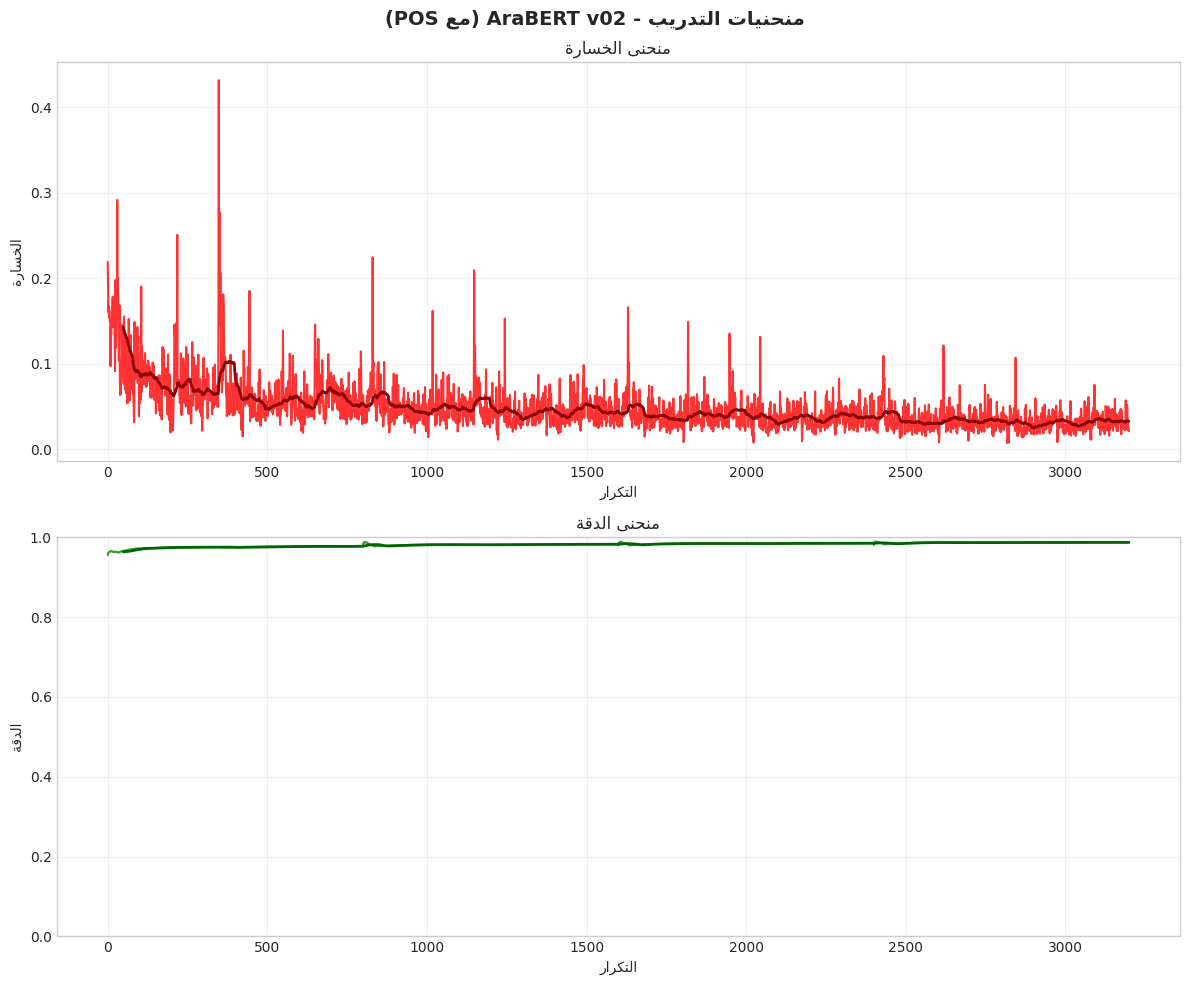

INFO:notebook_20251226_211055_visualizer:تم حفظ الرسم: ./logs/20251226_211055/plots/confusion_matrix_AraBERT v02_with_pos.png


[معلومات] [visualizer] تم حفظ الرسم: ./logs/20251226_211055/plots/confusion_matrix_AraBERT v02_with_pos.png


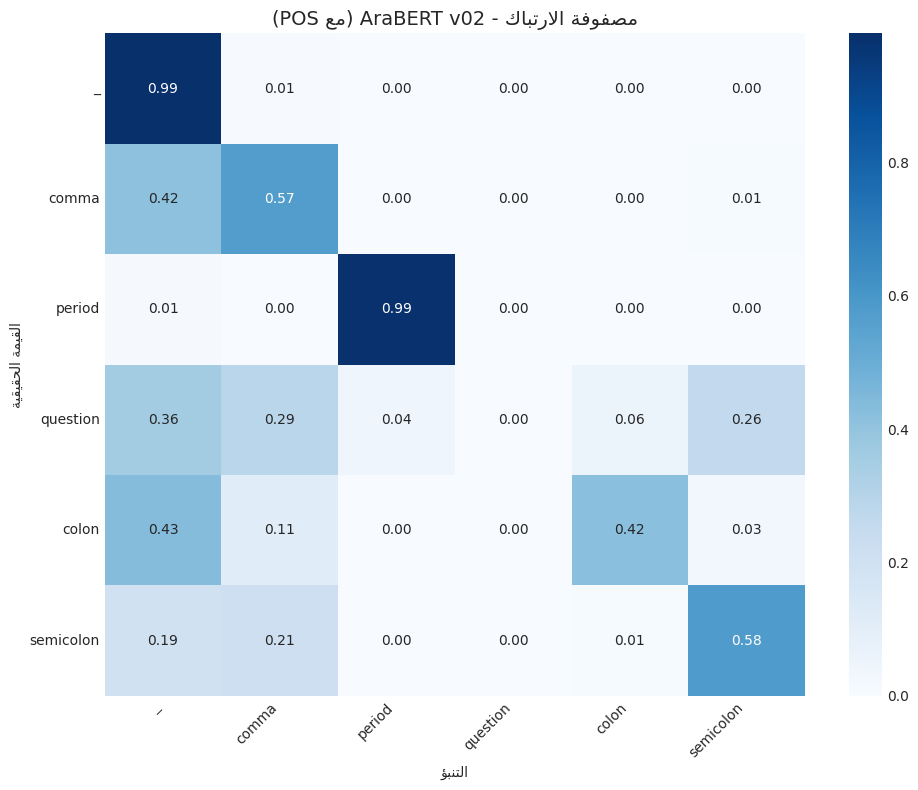

INFO:notebook_20251226_211055_visualizer:تم حفظ الرسم: ./logs/20251226_211055/plots/classification_report_AraBERT v02_with_pos.png


[معلومات] [visualizer] تم حفظ الرسم: ./logs/20251226_211055/plots/classification_report_AraBERT v02_with_pos.png


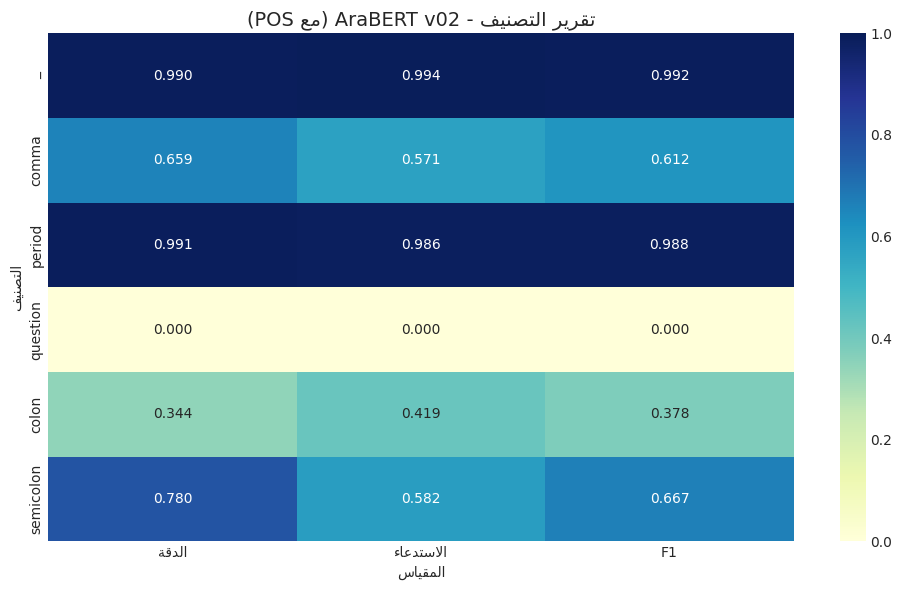

INFO:notebook_20251226_211055_visualizer:تم حفظ الرسم: ./logs/20251226_211055/plots/label_analysis_AraBERT v02_with_pos.png


[معلومات] [visualizer] تم حفظ الرسم: ./logs/20251226_211055/plots/label_analysis_AraBERT v02_with_pos.png


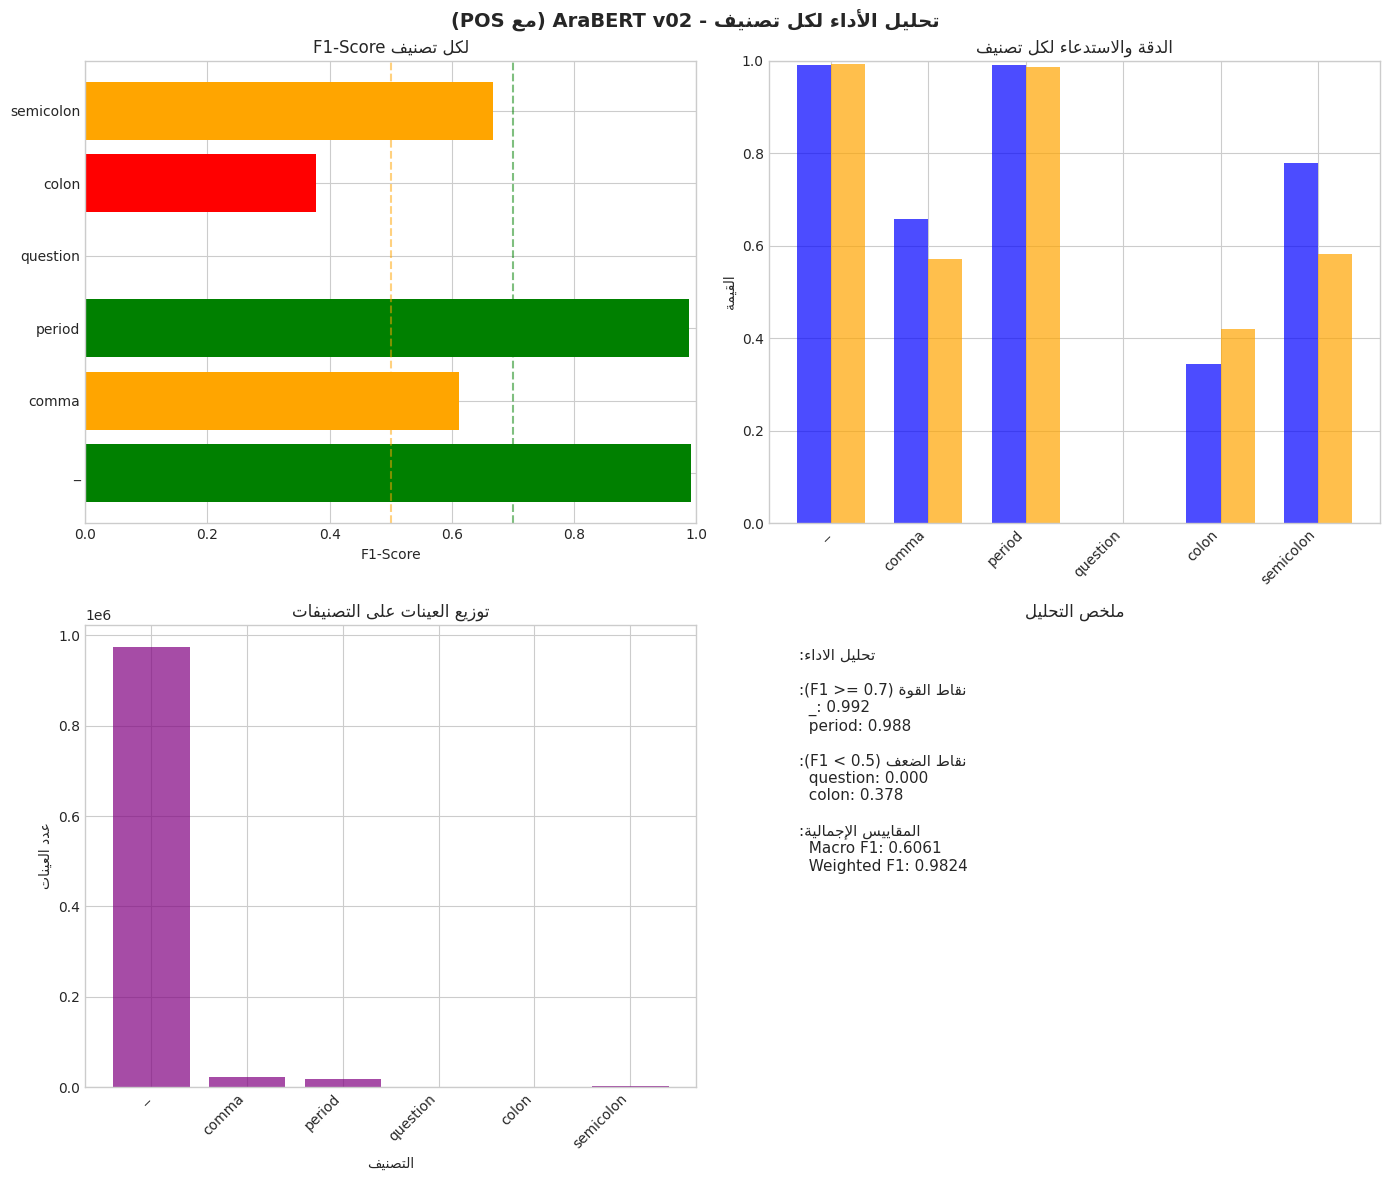

INFO:notebook_20251226_211055_main:SUCCESS: اكتملت التجربة: arabert_with_pos
INFO:notebook_20251226_211055_main:الدقة: 0.9831
INFO:notebook_20251226_211055_main:Macro F1: 0.6061
INFO:notebook_20251226_211055_main:Weighted F1: 0.9824
INFO:notebook_20251226_211055_main:----------------------------------------
INFO:notebook_20251226_211055_main:النموذج: AraELECTRA
INFO:notebook_20251226_211055_main:التجربة 2/3: AraELECTRA (مع POS)


[نجاح] [main] اكتملت التجربة: arabert_with_pos
[معلومات] [main] الدقة: 0.9831
[معلومات] [main] Macro F1: 0.6061
[معلومات] [main] Weighted F1: 0.9824
[معلومات] [main] ----------------------------------------
[معلومات] [main] النموذج: AraELECTRA
[معلومات] [main] التجربة 2/3: AraELECTRA (مع POS)


INFO:notebook_20251226_211055_main:تم العثور على نقطة تفتيش سابقة، جاري المحاولة للاستئناف...
INFO:notebook_20251226_211055_model_manager:جاري تحميل نقطة التفتيش من: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_last


[معلومات] [main] تم العثور على نقطة تفتيش سابقة، جاري المحاولة للاستئناف...
[معلومات] [model_manager] جاري تحميل نقطة التفتيش من: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_last


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم تحميل نقطة التفتيش بنجاح
INFO:notebook_20251226_211055_main:تم استئناف التدريب من الحقبة 1
DEBUG:notebook_20251226_211055_dataset:تم تهيئة مجموعة البيانات من: ./drive/MyDrive/train
DEBUG:notebook_20251226_211055_dataset:عدد الملفات: 74
DEBUG:notebook_20251226_211055_dataset:استخدام POS: True
DEBUG:notebook_20251226_211055_dataset:تم تهيئة مجموعة البيانات من: ./drive/MyDrive/test
DEBUG:notebook_20251226_211055_dataset:عدد الملفات: 5
DEBUG:notebook_20251226_211055_dataset:استخدام POS: True
INFO:notebook_20251226_211055_araelectra_with_pos:بدء تسجيل النموذج: araelectra
INFO:notebook_20251226_211055_araelectra_with_pos:استخدام تحليل أقسام الكلام: True
INFO:notebook_20251226_211055_araelectra_with_pos:تم تهيئة المدرب
INFO:notebook_20251226_211055_main:بدء التدريب...
INFO:notebook_20251226_211055_main:الحقبة 2/5


[نجاح] [model_manager] تم تحميل نقطة التفتيش بنجاح
[معلومات] [main] تم استئناف التدريب من الحقبة 1
[تصحيح] [dataset] تم تهيئة مجموعة البيانات من: ./drive/MyDrive/train
[تصحيح] [dataset] عدد الملفات: 74
[تصحيح] [dataset] استخدام POS: True
[تصحيح] [dataset] تم تهيئة مجموعة البيانات من: ./drive/MyDrive/test
[تصحيح] [dataset] عدد الملفات: 5
[تصحيح] [dataset] استخدام POS: True
[معلومات] [araelectra_with_pos] بدء تسجيل النموذج: araelectra
[معلومات] [araelectra_with_pos] استخدام تحليل أقسام الكلام: True
[معلومات] [araelectra_with_pos] تم تهيئة المدرب
[معلومات] [main] بدء التدريب...
[معلومات] [main] الحقبة 2/5


الحقبة 1: 49it [00:50,  1.05s/it, loss=0.2070, acc=0.9544]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.2070, الدقة: 0.9544
الحقبة 1: 50it [00:50,  1.03s/it, loss=0.2070, acc=0.9544]

[تقدم] [araelectra_with_pos] 50/800 (6.2%) - الخسارة: 0.2070, الدقة: 0.9544


الحقبة 1: 99it [01:37,  1.10it/s, loss=0.1258, acc=0.9584]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9584
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 100/800 (12.5%) - الخسارة: 0.1258, الدقة: 0.9584
الحقبة 1: 100it [01:54,  6.04s/it, loss=0.1258, acc=0.9584]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9584
[تقدم] [araelectra_with_pos] 100/800 (12.5%) - الخسارة: 0.1258, الدقة: 0.9584


الحقبة 1: 149it [02:49,  1.05s/it, loss=0.0839, acc=0.9627]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 150/800 (18.8%) - الخسارة: 0.0839, الدقة: 0.9627
الحقبة 1: 150it [02:49,  1.01s/it, loss=0.0839, acc=0.9627]

[تقدم] [araelectra_with_pos] 150/800 (18.8%) - الخسارة: 0.0839, الدقة: 0.9627


الحقبة 1: 199it [03:37,  1.02it/s, loss=0.0602, acc=0.9669]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9669
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 200/800 (25.0%) - الخسارة: 0.0602, الدقة: 0.9669
الحقبة 1: 200it [03:40,  1.74s/it, loss=0.0602, acc=0.9669]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9669
[تقدم] [araelectra_with_pos] 200/800 (25.0%) - الخسارة: 0.0602, الدقة: 0.9669


الحقبة 1: 249it [04:37,  1.08s/it, loss=0.0686, acc=0.9685]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 250/800 (31.2%) - الخسارة: 0.0686, الدقة: 0.9685
الحقبة 1: 250it [04:37,  1.12s/it, loss=0.0686, acc=0.9685]

[تقدم] [araelectra_with_pos] 250/800 (31.2%) - الخسارة: 0.0686, الدقة: 0.9685


الحقبة 1: 299it [05:26,  1.08it/s, loss=0.0906, acc=0.9703]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9703
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 300/800 (37.5%) - الخسارة: 0.0906, الدقة: 0.9703
الحقبة 1: 300it [05:30,  1.89s/it, loss=0.0906, acc=0.9703]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9703
[تقدم] [araelectra_with_pos] 300/800 (37.5%) - الخسارة: 0.0906, الدقة: 0.9703


الحقبة 1: 349it [06:25,  1.01it/s, loss=0.2177, acc=0.9707]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 350/800 (43.8%) - الخسارة: 0.2177, الدقة: 0.9707
الحقبة 1: 350it [06:25,  1.01s/it, loss=0.2177, acc=0.9707]

[تقدم] [araelectra_with_pos] 350/800 (43.8%) - الخسارة: 0.2177, الدقة: 0.9707


الحقبة 1: 399it [07:23,  1.67s/it, loss=0.0777, acc=0.9705]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9705
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 400/800 (50.0%) - الخسارة: 0.0777, الدقة: 0.9705
الحقبة 1: 400it [07:25,  2.69s/it, loss=0.0777, acc=0.9705]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9705
[تقدم] [araelectra_with_pos] 400/800 (50.0%) - الخسارة: 0.0777, الدقة: 0.9705


الحقبة 1: 449it [08:21,  1.04s/it, loss=0.0677, acc=0.9713]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 450/800 (56.2%) - الخسارة: 0.0677, الدقة: 0.9713
الحقبة 1: 450it [08:21,  1.03s/it, loss=0.0677, acc=0.9713]

[تقدم] [araelectra_with_pos] 450/800 (56.2%) - الخسارة: 0.0677, الدقة: 0.9713


الحقبة 1: 499it [09:11,  1.12s/it, loss=0.0394, acc=0.9724]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9724
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 500/800 (62.5%) - الخسارة: 0.0394, الدقة: 0.9724
الحقبة 1: 500it [09:17,  2.67s/it, loss=0.0394, acc=0.9724]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9724
[تقدم] [araelectra_with_pos] 500/800 (62.5%) - الخسارة: 0.0394, الدقة: 0.9724


الحقبة 1: 549it [10:18,  1.01it/s, loss=0.1340, acc=0.9730]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 550/800 (68.8%) - الخسارة: 0.1340, الدقة: 0.9730
الحقبة 1: 550it [10:18,  1.04s/it, loss=0.1340, acc=0.9730]

[تقدم] [araelectra_with_pos] 550/800 (68.8%) - الخسارة: 0.1340, الدقة: 0.9730


الحقبة 1: 599it [11:10,  1.07s/it, loss=0.0504, acc=0.9733]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9733
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 600/800 (75.0%) - الخسارة: 0.0504, الدقة: 0.9733
الحقبة 1: 600it [11:14,  2.00s/it, loss=0.0504, acc=0.9733]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9733
[تقدم] [araelectra_with_pos] 600/800 (75.0%) - الخسارة: 0.0504, الدقة: 0.9733


الحقبة 1: 649it [12:17,  1.00it/s, loss=0.1434, acc=0.9739]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 650/800 (81.2%) - الخسارة: 0.1434, الدقة: 0.9739
الحقبة 1: 650it [12:17,  1.06it/s, loss=0.1434, acc=0.9739]

[تقدم] [araelectra_with_pos] 650/800 (81.2%) - الخسارة: 0.1434, الدقة: 0.9739


الحقبة 1: 699it [13:05,  1.02s/it, loss=0.0924, acc=0.9739]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9739
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 700/800 (87.5%) - الخسارة: 0.0924, الدقة: 0.9739
الحقبة 1: 700it [13:08,  1.72s/it, loss=0.0924, acc=0.9739]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9739
[تقدم] [araelectra_with_pos] 700/800 (87.5%) - الخسارة: 0.0924, الدقة: 0.9739


الحقبة 1: 749it [14:03,  1.06s/it, loss=0.0423, acc=0.9741]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 750/800 (93.8%) - الخسارة: 0.0423, الدقة: 0.9741
الحقبة 1: 750it [14:03,  1.03s/it, loss=0.0423, acc=0.9741]

[تقدم] [araelectra_with_pos] 750/800 (93.8%) - الخسارة: 0.0423, الدقة: 0.9741


الحقبة 1: 799it [14:54,  1.13s/it, loss=0.0348, acc=0.9745]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9745
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 800/800 (100.0%) - الخسارة: 0.0348, الدقة: 0.9745
الحقبة 1: 800it [14:56,  1.12s/it, loss=0.0348, acc=0.9745]
INFO:notebook_20251226_211055_araelectra_with_pos:METRICS: loss: 0.0911 | accuracy: 0.9745 | epoch: 1.0000 | iterations: 800.0000
INFO:notebook_20251226_211055_main:الحقبة 3/5


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9745
[تقدم] [araelectra_with_pos] 800/800 (100.0%) - الخسارة: 0.0348, الدقة: 0.9745
[مقاييس] [araelectra_with_pos] loss: 0.0911 | accuracy: 0.9745 | epoch: 1.0000 | iterations: 800.0000
[معلومات] [main] الحقبة 3/5


الحقبة 2: 49it [00:55,  1.01s/it, loss=0.0655, acc=0.9772]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.0655, الدقة: 0.9772
الحقبة 2: 50it [00:55,  1.00s/it, loss=0.0655, acc=0.9772]

[تقدم] [araelectra_with_pos] 50/800 (6.2%) - الخسارة: 0.0655, الدقة: 0.9772


الحقبة 2: 99it [01:44,  1.03s/it, loss=0.0705, acc=0.9790]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9790
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 100/800 (12.5%) - الخسارة: 0.0705, الدقة: 0.9790
الحقبة 2: 100it [01:47,  1.98s/it, loss=0.0705, acc=0.9790]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9790
[تقدم] [araelectra_with_pos] 100/800 (12.5%) - الخسارة: 0.0705, الدقة: 0.9790


الحقبة 2: 149it [02:42,  1.01s/it, loss=0.0529, acc=0.9798]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 150/800 (18.8%) - الخسارة: 0.0529, الدقة: 0.9798
الحقبة 2: 150it [02:42,  1.02it/s, loss=0.0529, acc=0.9798]

[تقدم] [araelectra_with_pos] 150/800 (18.8%) - الخسارة: 0.0529, الدقة: 0.9798


الحقبة 2: 199it [03:31,  1.05s/it, loss=0.0406, acc=0.9807]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9807
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 200/800 (25.0%) - الخسارة: 0.0406, الدقة: 0.9807
الحقبة 2: 200it [03:36,  2.35s/it, loss=0.0406, acc=0.9807]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9807
[تقدم] [araelectra_with_pos] 200/800 (25.0%) - الخسارة: 0.0406, الدقة: 0.9807


الحقبة 2: 249it [04:33,  1.07s/it, loss=0.0459, acc=0.9804]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 250/800 (31.2%) - الخسارة: 0.0459, الدقة: 0.9804
الحقبة 2: 250it [04:33,  1.03s/it, loss=0.0459, acc=0.9804]

[تقدم] [araelectra_with_pos] 250/800 (31.2%) - الخسارة: 0.0459, الدقة: 0.9804


الحقبة 2: 299it [05:23,  1.09s/it, loss=0.0646, acc=0.9807]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 300/800 (37.5%) - الخسارة: 0.0646, الدقة: 0.9807
الحقبة 2: 300it [05:23,  1.05s/it, loss=0.0646, acc=0.9807]

[تقدم] [araelectra_with_pos] 300/800 (37.5%) - الخسارة: 0.0646, الدقة: 0.9807


الحقبة 2: 349it [06:11,  1.06it/s, loss=0.1631, acc=0.9804]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 350/800 (43.8%) - الخسارة: 0.1631, الدقة: 0.9804
الحقبة 2: 350it [06:11,  1.10it/s, loss=0.1631, acc=0.9804]

[تقدم] [araelectra_with_pos] 350/800 (43.8%) - الخسارة: 0.1631, الدقة: 0.9804


الحقبة 2: 399it [07:00,  1.01s/it, loss=0.0609, acc=0.9800]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 400/800 (50.0%) - الخسارة: 0.0609, الدقة: 0.9800
الحقبة 2: 400it [07:00,  1.01s/it, loss=0.0609, acc=0.9800]

[تقدم] [araelectra_with_pos] 400/800 (50.0%) - الخسارة: 0.0609, الدقة: 0.9800


الحقبة 2: 449it [07:49,  1.09s/it, loss=0.0496, acc=0.9802]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 450/800 (56.2%) - الخسارة: 0.0496, الدقة: 0.9802
الحقبة 2: 450it [07:49,  1.12s/it, loss=0.0496, acc=0.9802]

[تقدم] [araelectra_with_pos] 450/800 (56.2%) - الخسارة: 0.0496, الدقة: 0.9802


الحقبة 2: 499it [08:40,  1.06it/s, loss=0.0303, acc=0.9807]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 500/800 (62.5%) - الخسارة: 0.0303, الدقة: 0.9807
الحقبة 2: 500it [08:40,  1.03it/s, loss=0.0303, acc=0.9807]

[تقدم] [araelectra_with_pos] 500/800 (62.5%) - الخسارة: 0.0303, الدقة: 0.9807


الحقبة 2: 549it [09:31,  1.01s/it, loss=0.0977, acc=0.9808]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 550/800 (68.8%) - الخسارة: 0.0977, الدقة: 0.9808
الحقبة 2: 550it [09:31,  1.02it/s, loss=0.0977, acc=0.9808]

[تقدم] [araelectra_with_pos] 550/800 (68.8%) - الخسارة: 0.0977, الدقة: 0.9808


الحقبة 2: 599it [10:21,  1.01it/s, loss=0.0393, acc=0.9809]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9809
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 600/800 (75.0%) - الخسارة: 0.0393, الدقة: 0.9809
الحقبة 2: 600it [10:24,  1.89s/it, loss=0.0393, acc=0.9809]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9809
[تقدم] [araelectra_with_pos] 600/800 (75.0%) - الخسارة: 0.0393, الدقة: 0.9809


الحقبة 2: 649it [11:20,  1.01it/s, loss=0.0912, acc=0.9811]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 650/800 (81.2%) - الخسارة: 0.0912, الدقة: 0.9811
الحقبة 2: 650it [11:20,  1.06it/s, loss=0.0912, acc=0.9811]

[تقدم] [araelectra_with_pos] 650/800 (81.2%) - الخسارة: 0.0912, الدقة: 0.9811


الحقبة 2: 699it [12:08,  1.04it/s, loss=0.0772, acc=0.9810]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9810
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 700/800 (87.5%) - الخسارة: 0.0772, الدقة: 0.9810
الحقبة 2: 700it [12:10,  1.69s/it, loss=0.0772, acc=0.9810]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9810
[تقدم] [araelectra_with_pos] 700/800 (87.5%) - الخسارة: 0.0772, الدقة: 0.9810


الحقبة 2: 749it [13:06,  1.04s/it, loss=0.0314, acc=0.9811]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 750/800 (93.8%) - الخسارة: 0.0314, الدقة: 0.9811
الحقبة 2: 750it [13:06,  1.02s/it, loss=0.0314, acc=0.9811]

[تقدم] [araelectra_with_pos] 750/800 (93.8%) - الخسارة: 0.0314, الدقة: 0.9811


الحقبة 2: 799it [13:56,  1.04s/it, loss=0.0304, acc=0.9812]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9812
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 800/800 (100.0%) - الخسارة: 0.0304, الدقة: 0.9812
الحقبة 2: 800it [13:59,  1.05s/it, loss=0.0304, acc=0.9812]
INFO:notebook_20251226_211055_araelectra_with_pos:METRICS: loss: 0.0530 | accuracy: 0.9812 | epoch: 2.0000 | iterations: 800.0000
INFO:notebook_20251226_211055_main:الحقبة 4/5


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9812
[تقدم] [araelectra_with_pos] 800/800 (100.0%) - الخسارة: 0.0304, الدقة: 0.9812
[مقاييس] [araelectra_with_pos] loss: 0.0530 | accuracy: 0.9812 | epoch: 2.0000 | iterations: 800.0000
[معلومات] [main] الحقبة 4/5


الحقبة 3: 49it [00:56,  1.02it/s, loss=0.0527, acc=0.9798]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.0527, الدقة: 0.9798
الحقبة 3: 50it [00:56,  1.02it/s, loss=0.0527, acc=0.9798]

[تقدم] [araelectra_with_pos] 50/800 (6.2%) - الخسارة: 0.0527, الدقة: 0.9798


الحقبة 3: 99it [01:44,  1.03s/it, loss=0.0649, acc=0.9818]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9818
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 100/800 (12.5%) - الخسارة: 0.0649, الدقة: 0.9818
الحقبة 3: 100it [01:49,  2.35s/it, loss=0.0649, acc=0.9818]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9818
[تقدم] [araelectra_with_pos] 100/800 (12.5%) - الخسارة: 0.0649, الدقة: 0.9818


الحقبة 3: 149it [02:44,  1.04it/s, loss=0.0490, acc=0.9828]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 150/800 (18.8%) - الخسارة: 0.0490, الدقة: 0.9828
الحقبة 3: 150it [02:44,  1.05it/s, loss=0.0490, acc=0.9828]

[تقدم] [araelectra_with_pos] 150/800 (18.8%) - الخسارة: 0.0490, الدقة: 0.9828


الحقبة 3: 199it [03:33,  1.09s/it, loss=0.0350, acc=0.9836]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9836
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 200/800 (25.0%) - الخسارة: 0.0350, الدقة: 0.9836
الحقبة 3: 200it [03:37,  2.30s/it, loss=0.0350, acc=0.9836]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9836
[تقدم] [araelectra_with_pos] 200/800 (25.0%) - الخسارة: 0.0350, الدقة: 0.9836


الحقبة 3: 249it [04:34,  1.01s/it, loss=0.0383, acc=0.9833]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 250/800 (31.2%) - الخسارة: 0.0383, الدقة: 0.9833
الحقبة 3: 250it [04:34,  1.02it/s, loss=0.0383, acc=0.9833]

[تقدم] [araelectra_with_pos] 250/800 (31.2%) - الخسارة: 0.0383, الدقة: 0.9833


الحقبة 3: 299it [05:24,  1.05it/s, loss=0.0524, acc=0.9835]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 300/800 (37.5%) - الخسارة: 0.0524, الدقة: 0.9835
الحقبة 3: 300it [05:24,  1.05it/s, loss=0.0524, acc=0.9835]

[تقدم] [araelectra_with_pos] 300/800 (37.5%) - الخسارة: 0.0524, الدقة: 0.9835


الحقبة 3: 349it [06:13,  1.05s/it, loss=0.0934, acc=0.9833]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 350/800 (43.8%) - الخسارة: 0.0934, الدقة: 0.9833
الحقبة 3: 350it [06:13,  1.04s/it, loss=0.0934, acc=0.9833]

[تقدم] [araelectra_with_pos] 350/800 (43.8%) - الخسارة: 0.0934, الدقة: 0.9833


الحقبة 3: 399it [07:02,  1.03it/s, loss=0.0566, acc=0.9832]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 400/800 (50.0%) - الخسارة: 0.0566, الدقة: 0.9832
الحقبة 3: 400it [07:02,  1.02it/s, loss=0.0566, acc=0.9832]

[تقدم] [araelectra_with_pos] 400/800 (50.0%) - الخسارة: 0.0566, الدقة: 0.9832


الحقبة 3: 449it [07:51,  1.00it/s, loss=0.0406, acc=0.9833]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 450/800 (56.2%) - الخسارة: 0.0406, الدقة: 0.9833
الحقبة 3: 450it [07:51,  1.01it/s, loss=0.0406, acc=0.9833]

[تقدم] [araelectra_with_pos] 450/800 (56.2%) - الخسارة: 0.0406, الدقة: 0.9833


الحقبة 3: 499it [08:41,  1.12s/it, loss=0.0281, acc=0.9838]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9838
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 500/800 (62.5%) - الخسارة: 0.0281, الدقة: 0.9838
الحقبة 3: 500it [08:46,  2.76s/it, loss=0.0281, acc=0.9838]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9838
[تقدم] [araelectra_with_pos] 500/800 (62.5%) - الخسارة: 0.0281, الدقة: 0.9838


الحقبة 3: 549it [09:44,  1.01it/s, loss=0.0770, acc=0.9838]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 550/800 (68.8%) - الخسارة: 0.0770, الدقة: 0.9838
الحقبة 3: 550it [09:44,  1.03it/s, loss=0.0770, acc=0.9838]

[تقدم] [araelectra_with_pos] 550/800 (68.8%) - الخسارة: 0.0770, الدقة: 0.9838


الحقبة 3: 599it [10:34,  1.04it/s, loss=0.0352, acc=0.9839]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9839
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 600/800 (75.0%) - الخسارة: 0.0352, الدقة: 0.9839
الحقبة 3: 600it [10:38,  2.21s/it, loss=0.0352, acc=0.9839]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9839
[تقدم] [araelectra_with_pos] 600/800 (75.0%) - الخسارة: 0.0352, الدقة: 0.9839


الحقبة 3: 649it [11:34,  1.02it/s, loss=0.0650, acc=0.9841]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 650/800 (81.2%) - الخسارة: 0.0650, الدقة: 0.9841
الحقبة 3: 650it [11:34,  1.03it/s, loss=0.0650, acc=0.9841]

[تقدم] [araelectra_with_pos] 650/800 (81.2%) - الخسارة: 0.0650, الدقة: 0.9841


الحقبة 3: 699it [12:22,  1.08it/s, loss=0.0641, acc=0.9839]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9839
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 700/800 (87.5%) - الخسارة: 0.0641, الدقة: 0.9839
الحقبة 3: 700it [12:26,  2.25s/it, loss=0.0641, acc=0.9839]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9839
[تقدم] [araelectra_with_pos] 700/800 (87.5%) - الخسارة: 0.0641, الدقة: 0.9839


الحقبة 3: 749it [13:22,  1.01s/it, loss=0.0274, acc=0.9840]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 750/800 (93.8%) - الخسارة: 0.0274, الدقة: 0.9840
الحقبة 3: 750it [13:22,  1.01it/s, loss=0.0274, acc=0.9840]

[تقدم] [araelectra_with_pos] 750/800 (93.8%) - الخسارة: 0.0274, الدقة: 0.9840


الحقبة 3: 799it [14:12,  1.02it/s, loss=0.0269, acc=0.9840]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9840
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 800/800 (100.0%) - الخسارة: 0.0269, الدقة: 0.9840
الحقبة 3: 800it [14:15,  1.07s/it, loss=0.0269, acc=0.9840]
INFO:notebook_20251226_211055_araelectra_with_pos:METRICS: loss: 0.0428 | accuracy: 0.9840 | epoch: 3.0000 | iterations: 800.0000
INFO:notebook_20251226_211055_main:الحقبة 5/5


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9840
[تقدم] [araelectra_with_pos] 800/800 (100.0%) - الخسارة: 0.0269, الدقة: 0.9840
[مقاييس] [araelectra_with_pos] loss: 0.0428 | accuracy: 0.9840 | epoch: 3.0000 | iterations: 800.0000
[معلومات] [main] الحقبة 5/5


الحقبة 4: 49it [00:56,  1.04it/s, loss=0.0487, acc=0.9825]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.0487, الدقة: 0.9825
الحقبة 4: 50it [00:56,  1.03it/s, loss=0.0487, acc=0.9825]

[تقدم] [araelectra_with_pos] 50/800 (6.2%) - الخسارة: 0.0487, الدقة: 0.9825


الحقبة 4: 99it [01:45,  1.07it/s, loss=0.0522, acc=0.9845]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9845
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 100/800 (12.5%) - الخسارة: 0.0522, الدقة: 0.9845
الحقبة 4: 100it [01:47,  1.65s/it, loss=0.0522, acc=0.9845]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9845
[تقدم] [araelectra_with_pos] 100/800 (12.5%) - الخسارة: 0.0522, الدقة: 0.9845


الحقبة 4: 149it [02:42,  1.05it/s, loss=0.0375, acc=0.9854]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 150/800 (18.8%) - الخسارة: 0.0375, الدقة: 0.9854
الحقبة 4: 150it [02:42,  1.05it/s, loss=0.0375, acc=0.9854]

[تقدم] [araelectra_with_pos] 150/800 (18.8%) - الخسارة: 0.0375, الدقة: 0.9854


الحقبة 4: 199it [03:31,  1.03s/it, loss=0.0315, acc=0.9860]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9860
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 200/800 (25.0%) - الخسارة: 0.0315, الدقة: 0.9860
الحقبة 4: 200it [03:34,  1.91s/it, loss=0.0315, acc=0.9860]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9860
[تقدم] [araelectra_with_pos] 200/800 (25.0%) - الخسارة: 0.0315, الدقة: 0.9860


الحقبة 4: 249it [04:31,  1.04s/it, loss=0.0323, acc=0.9858]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 250/800 (31.2%) - الخسارة: 0.0323, الدقة: 0.9858
الحقبة 4: 250it [04:31,  1.01s/it, loss=0.0323, acc=0.9858]

[تقدم] [araelectra_with_pos] 250/800 (31.2%) - الخسارة: 0.0323, الدقة: 0.9858


الحقبة 4: 299it [05:22,  1.06it/s, loss=0.0372, acc=0.9859]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 300/800 (37.5%) - الخسارة: 0.0372, الدقة: 0.9859
الحقبة 4: 300it [05:22,  1.06it/s, loss=0.0372, acc=0.9859]

[تقدم] [araelectra_with_pos] 300/800 (37.5%) - الخسارة: 0.0372, الدقة: 0.9859


الحقبة 4: 349it [06:11,  1.06s/it, loss=0.0532, acc=0.9858]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 350/800 (43.8%) - الخسارة: 0.0532, الدقة: 0.9858
الحقبة 4: 350it [06:11,  1.01it/s, loss=0.0532, acc=0.9858]

[تقدم] [araelectra_with_pos] 350/800 (43.8%) - الخسارة: 0.0532, الدقة: 0.9858


الحقبة 4: 399it [07:00,  1.02it/s, loss=0.0513, acc=0.9858]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 400/800 (50.0%) - الخسارة: 0.0513, الدقة: 0.9858
الحقبة 4: 400it [07:00,  1.01it/s, loss=0.0513, acc=0.9858]

[تقدم] [araelectra_with_pos] 400/800 (50.0%) - الخسارة: 0.0513, الدقة: 0.9858


الحقبة 4: 449it [07:49,  1.02it/s, loss=0.0306, acc=0.9859]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 450/800 (56.2%) - الخسارة: 0.0306, الدقة: 0.9859
الحقبة 4: 450it [07:49,  1.02it/s, loss=0.0306, acc=0.9859]

[تقدم] [araelectra_with_pos] 450/800 (56.2%) - الخسارة: 0.0306, الدقة: 0.9859


الحقبة 4: 499it [08:39,  1.03s/it, loss=0.0167, acc=0.9863]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9863
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 500/800 (62.5%) - الخسارة: 0.0167, الدقة: 0.9863
الحقبة 4: 500it [08:49,  4.07s/it, loss=0.0167, acc=0.9863]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9863
[تقدم] [araelectra_with_pos] 500/800 (62.5%) - الخسارة: 0.0167, الدقة: 0.9863


الحقبة 4: 549it [09:46,  1.11s/it, loss=0.0568, acc=0.9864]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 550/800 (68.8%) - الخسارة: 0.0568, الدقة: 0.9864
الحقبة 4: 550it [09:46,  1.05s/it, loss=0.0568, acc=0.9864]

[تقدم] [araelectra_with_pos] 550/800 (68.8%) - الخسارة: 0.0568, الدقة: 0.9864


الحقبة 4: 599it [10:35,  1.02s/it, loss=0.0286, acc=0.9865]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9865
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 600/800 (75.0%) - الخسارة: 0.0286, الدقة: 0.9865
الحقبة 4: 600it [10:38,  1.89s/it, loss=0.0286, acc=0.9865]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9865
[تقدم] [araelectra_with_pos] 600/800 (75.0%) - الخسارة: 0.0286, الدقة: 0.9865


الحقبة 4: 649it [11:34,  1.08s/it, loss=0.0463, acc=0.9866]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 650/800 (81.2%) - الخسارة: 0.0463, الدقة: 0.9866
الحقبة 4: 650it [11:34,  1.00s/it, loss=0.0463, acc=0.9866]

[تقدم] [araelectra_with_pos] 650/800 (81.2%) - الخسارة: 0.0463, الدقة: 0.9866


الحقبة 4: 699it [12:21,  1.11it/s, loss=0.0498, acc=0.9866]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9866
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 700/800 (87.5%) - الخسارة: 0.0498, الدقة: 0.9866
الحقبة 4: 700it [12:24,  1.85s/it, loss=0.0498, acc=0.9866]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9866
[تقدم] [araelectra_with_pos] 700/800 (87.5%) - الخسارة: 0.0498, الدقة: 0.9866


الحقبة 4: 749it [13:20,  1.09s/it, loss=0.0215, acc=0.9867]INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 750/800 (93.8%) - الخسارة: 0.0215, الدقة: 0.9867
الحقبة 4: 750it [13:20,  1.15s/it, loss=0.0215, acc=0.9867]

[تقدم] [araelectra_with_pos] 750/800 (93.8%) - الخسارة: 0.0215, الدقة: 0.9867


الحقبة 4: 799it [14:10,  1.03it/s, loss=0.0245, acc=0.9866]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ أفضل نموذج بدقة: 0.9866
INFO:notebook_20251226_211055_araelectra_with_pos:PROGRESS: 800/800 (100.0%) - الخسارة: 0.0245, الدقة: 0.9866
الحقبة 4: 800it [14:13,  1.07s/it, loss=0.0245, acc=0.9866]
INFO:notebook_20251226_211055_araelectra_with_pos:METRICS: loss: 0.0349 | accuracy: 0.9866 | epoch: 4.0000 | iterations: 800.0000
INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_last


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ أفضل نموذج بدقة: 0.9866
[تقدم] [araelectra_with_pos] 800/800 (100.0%) - الخسارة: 0.0245, الدقة: 0.9866
[مقاييس] [araelectra_with_pos] loss: 0.0349 | accuracy: 0.9866 | epoch: 4.0000 | iterations: 800.0000
[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_with_pos_last


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_with_pos:تم حفظ آخر نموذج
INFO:notebook_20251226_211055_main:بدء التقييم...


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_with_pos] تم حفظ آخر نموذج
[معلومات] [main] بدء التقييم...


التقييم: 800it [07:55,  1.68it/s]
INFO:notebook_20251226_211055_araelectra_with_pos:دقة التقييم: 0.9819
INFO:notebook_20251226_211055_araelectra_with_pos:Macro F1: 0.5956
INFO:notebook_20251226_211055_araelectra_with_pos:Weighted F1: 0.9812
INFO:notebook_20251226_211055_araelectra_with_pos:METRICS: eval_accuracy: 0.9819 | macro_f1: 0.5956 | weighted_f1: 0.9812
INFO:notebook_20251226_211055_main:إنشاء الرسوم البيانية...


[معلومات] [araelectra_with_pos] دقة التقييم: 0.9819
[معلومات] [araelectra_with_pos] Macro F1: 0.5956
[معلومات] [araelectra_with_pos] Weighted F1: 0.9812
[مقاييس] [araelectra_with_pos] eval_accuracy: 0.9819 | macro_f1: 0.5956 | weighted_f1: 0.9812
[معلومات] [main] إنشاء الرسوم البيانية...


INFO:notebook_20251226_211055_visualizer:تم حفظ الرسم: ./logs/20251226_211055/plots/training_curves_AraELECTRA_with_pos.png


[معلومات] [visualizer] تم حفظ الرسم: ./logs/20251226_211055/plots/training_curves_AraELECTRA_with_pos.png


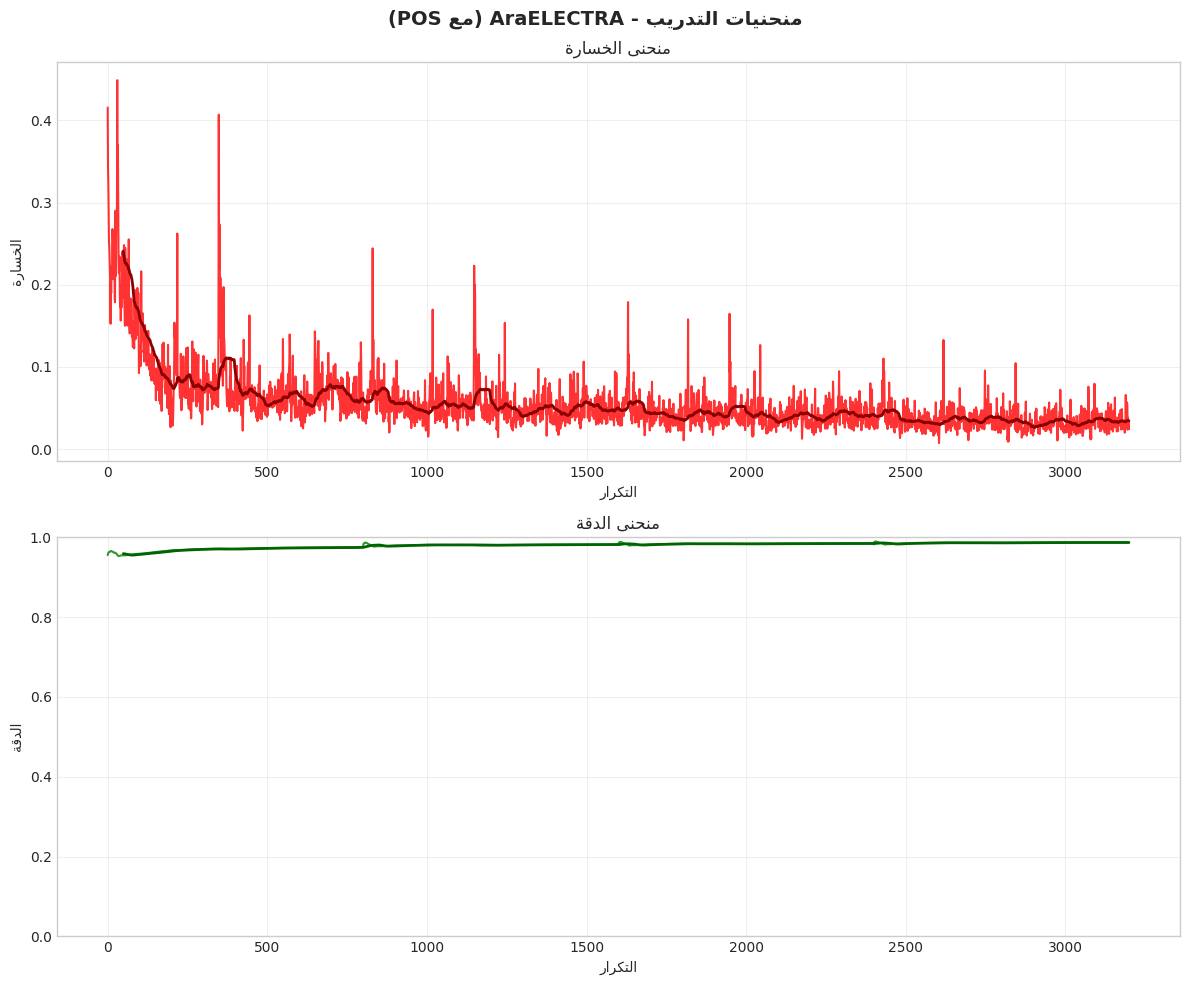

INFO:notebook_20251226_211055_visualizer:تم حفظ الرسم: ./logs/20251226_211055/plots/confusion_matrix_AraELECTRA_with_pos.png


[معلومات] [visualizer] تم حفظ الرسم: ./logs/20251226_211055/plots/confusion_matrix_AraELECTRA_with_pos.png


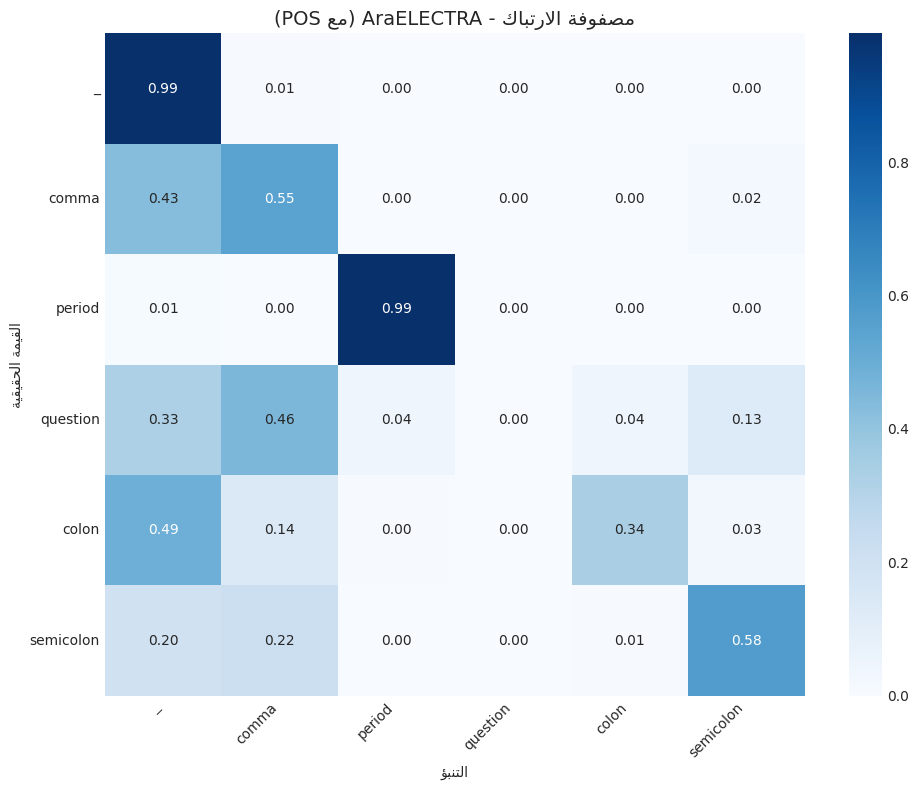

INFO:notebook_20251226_211055_visualizer:تم حفظ الرسم: ./logs/20251226_211055/plots/classification_report_AraELECTRA_with_pos.png


[معلومات] [visualizer] تم حفظ الرسم: ./logs/20251226_211055/plots/classification_report_AraELECTRA_with_pos.png


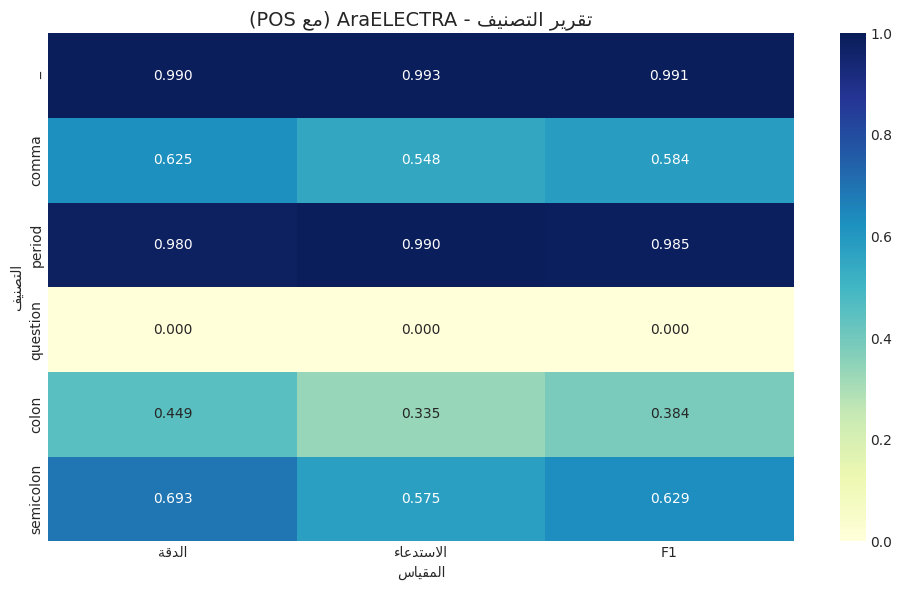

INFO:notebook_20251226_211055_visualizer:تم حفظ الرسم: ./logs/20251226_211055/plots/label_analysis_AraELECTRA_with_pos.png


[معلومات] [visualizer] تم حفظ الرسم: ./logs/20251226_211055/plots/label_analysis_AraELECTRA_with_pos.png


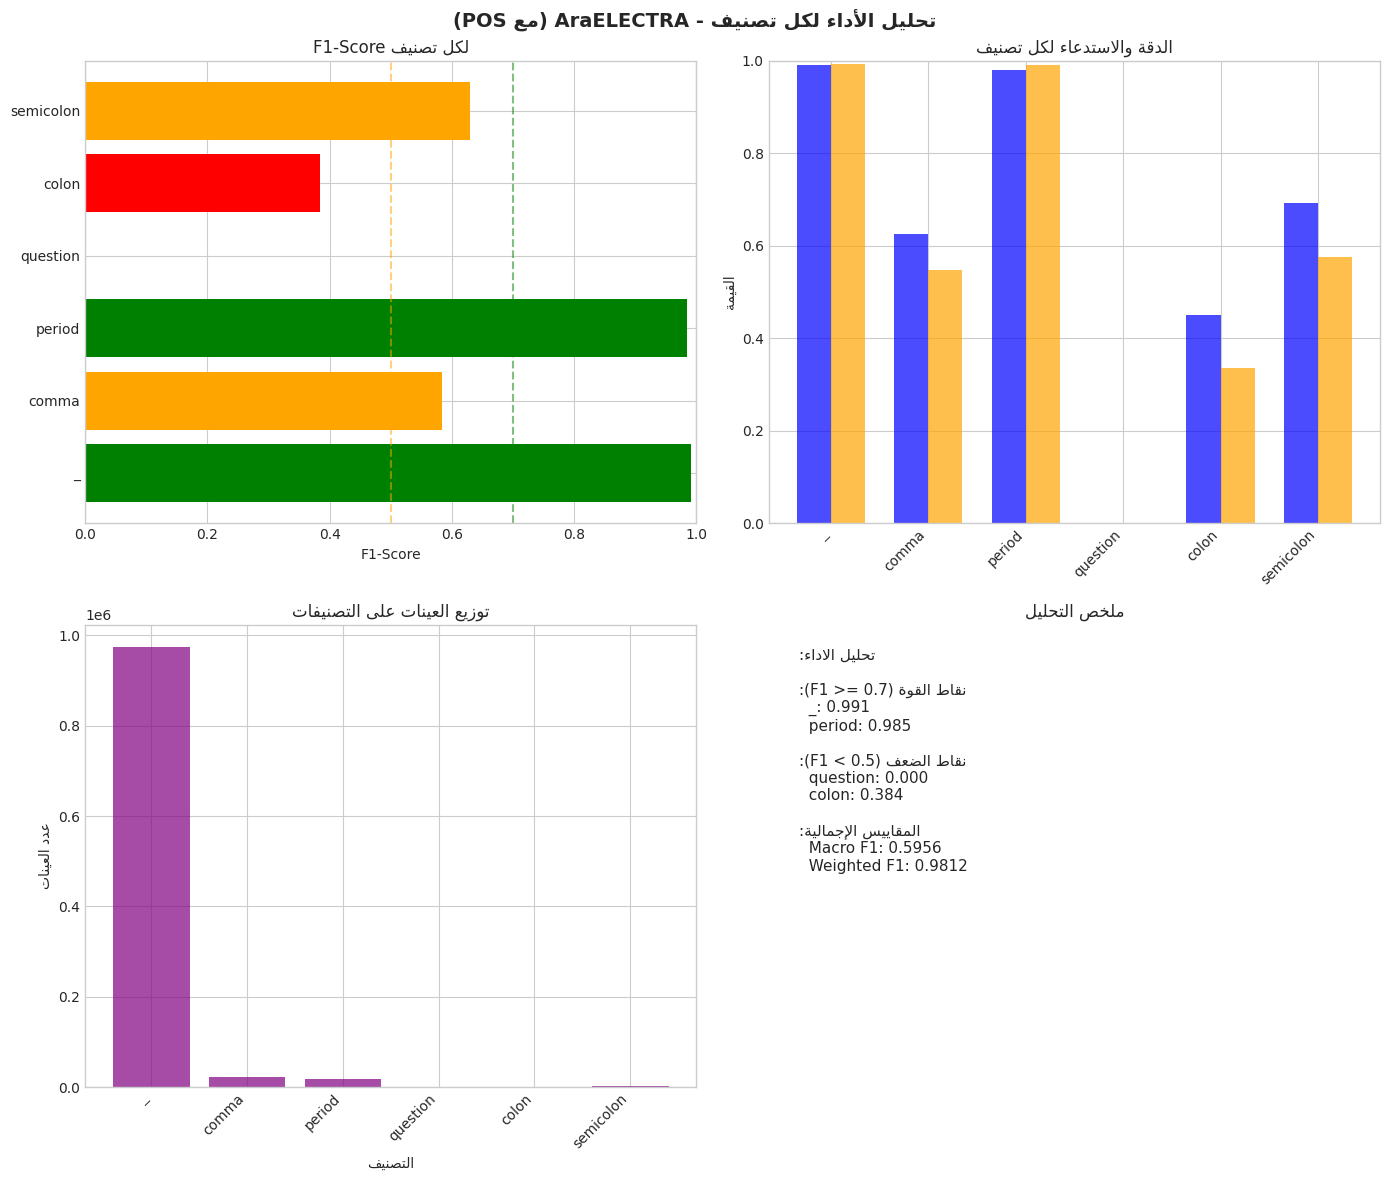

INFO:notebook_20251226_211055_main:SUCCESS: اكتملت التجربة: araelectra_with_pos
INFO:notebook_20251226_211055_main:الدقة: 0.9819
INFO:notebook_20251226_211055_main:Macro F1: 0.5956
INFO:notebook_20251226_211055_main:Weighted F1: 0.9812
INFO:notebook_20251226_211055_main:----------------------------------------
INFO:notebook_20251226_211055_main:النموذج: CAMeLBERT
INFO:notebook_20251226_211055_main:التجربة 3/3: CAMeLBERT (مع POS)
INFO:notebook_20251226_211055_main:جاري تحميل نموذج جديد...
INFO:notebook_20251226_211055_model_manager:جاري تحميل النموذج: CAMeL-Lab/bert-base-arabic-camelbert-mix


[نجاح] [main] اكتملت التجربة: araelectra_with_pos
[معلومات] [main] الدقة: 0.9819
[معلومات] [main] Macro F1: 0.5956
[معلومات] [main] Weighted F1: 0.9812
[معلومات] [main] ----------------------------------------
[معلومات] [main] النموذج: CAMeLBERT
[معلومات] [main] التجربة 3/3: CAMeLBERT (مع POS)
[معلومات] [main] جاري تحميل نموذج جديد...
[معلومات] [model_manager] جاري تحميل النموذج: CAMeL-Lab/bert-base-arabic-camelbert-mix


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:notebook_20251226_211055_model_manager:SUCCESS: تم تحميل النموذج بنجاح: CAMeL-Lab/bert-base-arabic-camelbert-mix
DEBUG:notebook_20251226_211055_dataset:تم تهيئة مجموعة البيانات من: ./drive/MyDrive/train
DEBUG:notebook_20251226_211055_dataset:عدد الملفات: 74
DEBUG:notebook_20251226_211055_dataset:استخدام POS: True
DEBUG:notebook_20251226_211055_dataset:تم تهيئة مجموعة البيانات من: ./drive/MyDrive/test
DEBUG:notebook_20251226_211055_dataset:عدد الملفات: 5
DEBUG:notebook_20251226_211055_dataset:استخدام POS: True
INFO:notebook_20251226_211055_camelbert_with_pos:بدء تسجيل النموذج: camelbert
INFO:notebook_20251226_211055_camelbert_with_pos:استخدام تحليل أقسام الكلام: True
INFO:no

[نجاح] [model_manager] تم تحميل النموذج بنجاح: CAMeL-Lab/bert-base-arabic-camelbert-mix
[تصحيح] [dataset] تم تهيئة مجموعة البيانات من: ./drive/MyDrive/train
[تصحيح] [dataset] عدد الملفات: 74
[تصحيح] [dataset] استخدام POS: True
[تصحيح] [dataset] تم تهيئة مجموعة البيانات من: ./drive/MyDrive/test
[تصحيح] [dataset] عدد الملفات: 5
[تصحيح] [dataset] استخدام POS: True
[معلومات] [camelbert_with_pos] بدء تسجيل النموذج: camelbert
[معلومات] [camelbert_with_pos] استخدام تحليل أقسام الكلام: True
[معلومات] [camelbert_with_pos] تم تهيئة المدرب
[معلومات] [main] بدء التدريب...
[معلومات] [main] الحقبة 1/5


الحقبة 1: 49it [00:46,  1.09it/s, loss=0.1603, acc=0.9358]INFO:notebook_20251226_211055_camelbert_with_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.1603, الدقة: 0.9358
الحقبة 1: 50it [00:46,  1.10it/s, loss=0.1603, acc=0.9358]

[تقدم] [camelbert_with_pos] 50/800 (6.2%) - الخسارة: 0.1603, الدقة: 0.9358


الحقبة 1: 99it [01:31,  1.16it/s, loss=0.0876, acc=0.9539]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/camelbert_with_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/camelbert_with_pos_best


ERROR:notebook_20251226_211055_model_manager:خطأ في حفظ النموذج: You are trying to save a non contiguous tensor: `bert.encoder.layer.0.attention.self.query.weight` which is not allowed. It either means you are trying to save tensors which are reference of each other in which case it's recommended to save only the full tensors, and reslice at load time, or simply call `.contiguous()` on your tensor to pack it before saving.
الحقبة 1: 99it [01:32,  1.07it/s, loss=0.0876, acc=0.9539]
ERROR:notebook_20251226_211055_main:خطأ في التجربة camelbert_with_pos: You are trying to save a non contiguous tensor: `bert.encoder.layer.0.attention.self.query.weight` which is not allowed. It either means you are trying to save tensors which are reference of each other in which case it's recommended to save only the full tensors, and reslice at load time, or simply call `.contiguous()` on your tensor to pack it before saving.
ERROR:notebook_20251226_211055_main:Traceback (most recent call last):
  File "/t

[خطأ] [model_manager] خطأ في حفظ النموذج: You are trying to save a non contiguous tensor: `bert.encoder.layer.0.attention.self.query.weight` which is not allowed. It either means you are trying to save tensors which are reference of each other in which case it's recommended to save only the full tensors, and reslice at load time, or simply call `.contiguous()` on your tensor to pack it before saving.
[خطأ] [main] خطأ في التجربة camelbert_with_pos: You are trying to save a non contiguous tensor: `bert.encoder.layer.0.attention.self.query.weight` which is not allowed. It either means you are trying to save tensors which are reference of each other in which case it's recommended to save only the full tensors, and reslice at load time, or simply call `.contiguous()` on your tensor to pack it before saving.
[خطأ] [main] Traceback (most recent call last):
  File "/tmp/ipython-input-1633466345.py", line 148, in run_all_experiments
    trainer.train_epoch(train_loader, max_iterations)
  File "

INFO:notebook_20251226_211055_visualizer:تم حفظ الرسم: ./logs/20251226_211055/plots/models_comparison.png


[معلومات] [visualizer] تم حفظ الرسم: ./logs/20251226_211055/plots/models_comparison.png


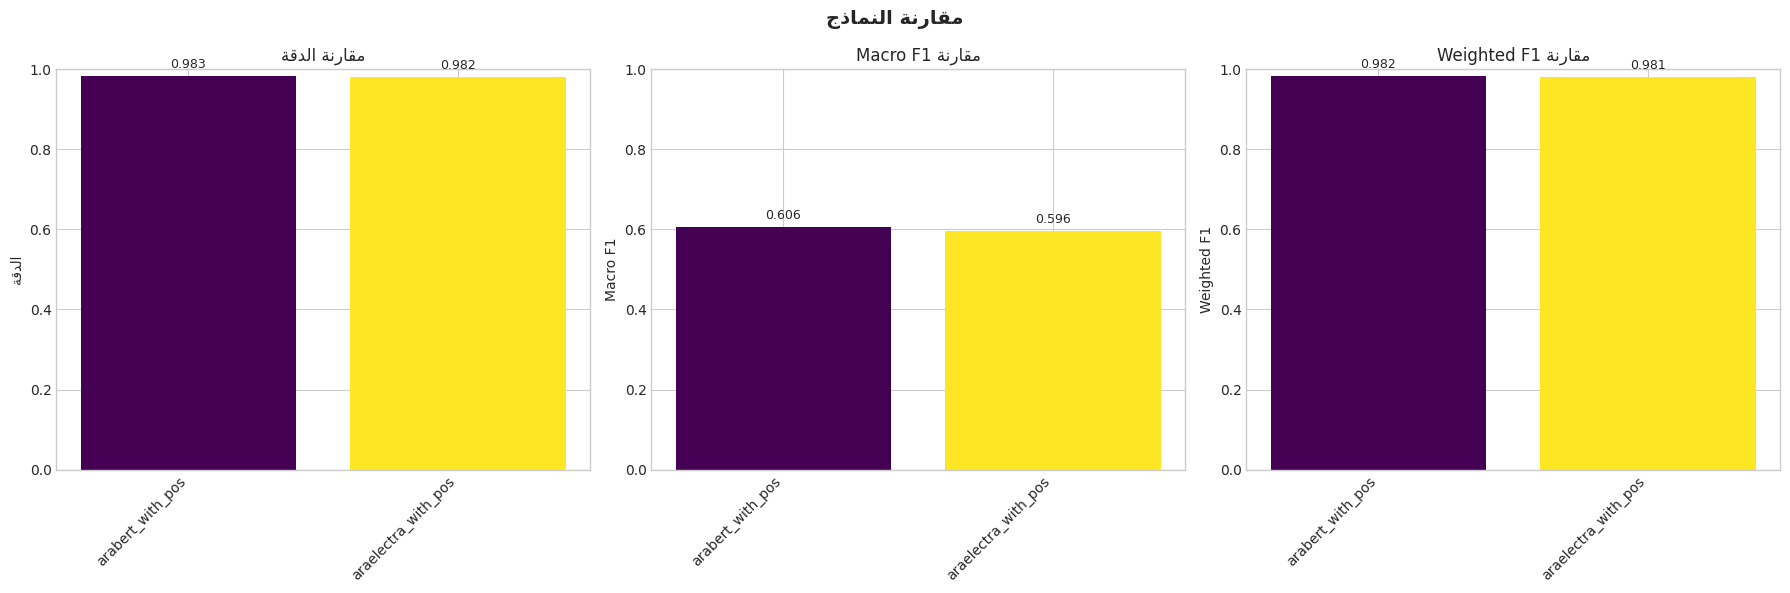

INFO:notebook_20251226_211055_main:تم حفظ النتائج في: ./logs/20251226_211055/all_results.json
INFO:notebook_20251226_211055_main:============================================================
INFO:notebook_20251226_211055_main:اكتملت جميع التجارب
INFO:notebook_20251226_211055_main:============================================================



جدول مقارنة النماذج:
            النموذج  الدقة الكلية  Macro F1  Weighted F1  الدقة (Macro)  الاستدعاء (Macro)
   arabert_with_pos      0.983070  0.606058     0.982423       0.627170           0.592004
araelectra_with_pos      0.981927  0.595622     0.981241       0.623031           0.573656
[معلومات] [main] تم حفظ النتائج في: ./logs/20251226_211055/all_results.json
[معلومات] [main] ============================================================
[معلومات] [main] اكتملت جميع التجارب
[معلومات] [main] ============================================================

اكتملت جميع التجارب!
عدد التجارب المكتملة: 2


In [13]:

# تشغيل جميع التجارب
results = run_all_experiments(
    models_config=MODELS_CONFIG,
    train_dir=TRAIN_DATA_DIR,
    test_dir=TEST_DATA_DIR,
    epochs=EPOCHS,
    max_iterations=MAX_ITERATIONS_PER_EPOCH,
    with_pos=RUN_WITH_POS,
    run_cross_validation=False
)

print("\nاكتملت جميع التجارب!")
print(f"عدد التجارب المكتملة: {len(results)}")

## تجريب النماذج بعكس التجربة السابقة بالنسبة لـ POS


INFO:notebook_20251226_211055_main:============================================================
INFO:notebook_20251226_211055_main:بدء التشغيل الديناميكي لجميع النماذج
INFO:notebook_20251226_211055_main:============================================================
INFO:notebook_20251226_211055_main:إجمالي التجارب: 3
INFO:notebook_20251226_211055_main:----------------------------------------
INFO:notebook_20251226_211055_main:النموذج: AraBERT v02
INFO:notebook_20251226_211055_main:التجربة 1/3: AraBERT v02 (بدون POS)
INFO:notebook_20251226_211055_main:جاري تحميل نموذج جديد...
INFO:notebook_20251226_211055_model_manager:جاري تحميل النموذج: aubmindlab/bert-base-arabertv02


[معلومات] [main] ============================================================
[معلومات] [main] بدء التشغيل الديناميكي لجميع النماذج
[معلومات] [main] ============================================================
[معلومات] [main] إجمالي التجارب: 3
[معلومات] [main] ----------------------------------------
[معلومات] [main] النموذج: AraBERT v02
[معلومات] [main] التجربة 1/3: AraBERT v02 (بدون POS)
[معلومات] [main] جاري تحميل نموذج جديد...
[معلومات] [model_manager] جاري تحميل النموذج: aubmindlab/bert-base-arabertv02


tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:notebook_20251226_211055_model_manager:SUCCESS: تم تحميل النموذج بنجاح: aubmindlab/bert-base-arabertv02
DEBUG:notebook_20251226_211055_dataset:تم تهيئة مجموعة البيانات من: ./drive/MyDrive/train
DEBUG:notebook_20251226_211055_dataset:عدد الملفات: 74
DEBUG:notebook_20251226_211055_dataset:استخدام POS: False
DEBUG:notebook_20251226_211055_dataset:تم تهيئة مجموعة البيانات من: ./drive/MyDrive/test
DEBUG:notebook_20251226_211055_dataset:عدد الملفات: 5
DEBUG:notebook_20251226_211055_dataset:استخدام POS: False
INFO:notebook_20251226_211055_arabert_without_pos:بدء تسجيل النموذج: arabert
INFO:notebook_20251226_211055_arabert_without_pos:استخدام تحليل أقسام الكلام: False
INFO:notebook_20251226

[نجاح] [model_manager] تم تحميل النموذج بنجاح: aubmindlab/bert-base-arabertv02
[تصحيح] [dataset] تم تهيئة مجموعة البيانات من: ./drive/MyDrive/train
[تصحيح] [dataset] عدد الملفات: 74
[تصحيح] [dataset] استخدام POS: False
[تصحيح] [dataset] تم تهيئة مجموعة البيانات من: ./drive/MyDrive/test
[تصحيح] [dataset] عدد الملفات: 5
[تصحيح] [dataset] استخدام POS: False
[معلومات] [arabert_without_pos] بدء تسجيل النموذج: arabert
[معلومات] [arabert_without_pos] استخدام تحليل أقسام الكلام: False
[معلومات] [arabert_without_pos] تم تهيئة المدرب
[معلومات] [main] بدء التدريب...
[معلومات] [main] الحقبة 1/5


الحقبة 1: 49it [00:11,  4.57it/s, loss=0.1796, acc=0.8913]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.1796, الدقة: 0.8913
الحقبة 1: 50it [00:11,  4.58it/s, loss=0.1796, acc=0.8913]

[تقدم] [arabert_without_pos] 50/800 (6.2%) - الخسارة: 0.1796, الدقة: 0.8913


الحقبة 1: 99it [00:24,  3.78it/s, loss=0.1714, acc=0.9230]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9230
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 100/800 (12.5%) - الخسارة: 0.1714, الدقة: 0.9230
الحقبة 1: 100it [00:27,  1.00it/s, loss=0.1714, acc=0.9230]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9230
[تقدم] [arabert_without_pos] 100/800 (12.5%) - الخسارة: 0.1714, الدقة: 0.9230


الحقبة 1: 149it [00:40,  4.34it/s, loss=0.1212, acc=0.9325]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 150/800 (18.8%) - الخسارة: 0.1212, الدقة: 0.9325
الحقبة 1: 150it [00:40,  4.45it/s, loss=0.1212, acc=0.9325]

[تقدم] [arabert_without_pos] 150/800 (18.8%) - الخسارة: 0.1212, الدقة: 0.9325


الحقبة 1: 199it [00:53,  3.81it/s, loss=0.0911, acc=0.9396]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9396
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 200/800 (25.0%) - الخسارة: 0.0911, الدقة: 0.9396
الحقبة 1: 200it [00:56,  1.16s/it, loss=0.0911, acc=0.9396]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9396
[تقدم] [arabert_without_pos] 200/800 (25.0%) - الخسارة: 0.0911, الدقة: 0.9396


الحقبة 1: 249it [01:07,  4.58it/s, loss=0.0928, acc=0.9423]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 250/800 (31.2%) - الخسارة: 0.0928, الدقة: 0.9423
الحقبة 1: 250it [01:07,  4.57it/s, loss=0.0928, acc=0.9423]

[تقدم] [arabert_without_pos] 250/800 (31.2%) - الخسارة: 0.0928, الدقة: 0.9423


الحقبة 1: 299it [01:27,  4.10it/s, loss=0.1535, acc=0.9453]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9453
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 300/800 (37.5%) - الخسارة: 0.1535, الدقة: 0.9453
الحقبة 1: 300it [01:30,  1.04it/s, loss=0.1535, acc=0.9453]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9453
[تقدم] [arabert_without_pos] 300/800 (37.5%) - الخسارة: 0.1535, الدقة: 0.9453


الحقبة 1: 349it [01:42,  3.77it/s, loss=0.3536, acc=0.9467]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 350/800 (43.8%) - الخسارة: 0.3536, الدقة: 0.9467
الحقبة 1: 350it [01:42,  3.70it/s, loss=0.3536, acc=0.9467]

[تقدم] [arabert_without_pos] 350/800 (43.8%) - الخسارة: 0.3536, الدقة: 0.9467


الحقبة 1: 399it [02:03,  3.84it/s, loss=0.1348, acc=0.9467]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9467
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 400/800 (50.0%) - الخسارة: 0.1348, الدقة: 0.9467
الحقبة 1: 400it [02:06,  1.09s/it, loss=0.1348, acc=0.9467]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9467
[تقدم] [arabert_without_pos] 400/800 (50.0%) - الخسارة: 0.1348, الدقة: 0.9467


الحقبة 1: 449it [02:18,  4.07it/s, loss=0.0943, acc=0.9484]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 450/800 (56.2%) - الخسارة: 0.0943, الدقة: 0.9484
الحقبة 1: 450it [02:18,  3.86it/s, loss=0.0943, acc=0.9484]

[تقدم] [arabert_without_pos] 450/800 (56.2%) - الخسارة: 0.0943, الدقة: 0.9484


الحقبة 1: 499it [02:38,  4.66it/s, loss=0.0636, acc=0.9507]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9507
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 500/800 (62.5%) - الخسارة: 0.0636, الدقة: 0.9507
الحقبة 1: 500it [02:42,  1.52s/it, loss=0.0636, acc=0.9507]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9507
[تقدم] [arabert_without_pos] 500/800 (62.5%) - الخسارة: 0.0636, الدقة: 0.9507


الحقبة 1: 549it [02:54,  4.40it/s, loss=0.1965, acc=0.9520]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 550/800 (68.8%) - الخسارة: 0.1965, الدقة: 0.9520
الحقبة 1: 550it [02:54,  4.14it/s, loss=0.1965, acc=0.9520]

[تقدم] [arabert_without_pos] 550/800 (68.8%) - الخسارة: 0.1965, الدقة: 0.9520


الحقبة 1: 599it [03:13,  4.55it/s, loss=0.0809, acc=0.9530]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9530
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 600/800 (75.0%) - الخسارة: 0.0809, الدقة: 0.9530
الحقبة 1: 600it [03:23,  3.29s/it, loss=0.0809, acc=0.9530]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9530
[تقدم] [arabert_without_pos] 600/800 (75.0%) - الخسارة: 0.0809, الدقة: 0.9530


الحقبة 1: 649it [03:35,  4.61it/s, loss=0.2766, acc=0.9540]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 650/800 (81.2%) - الخسارة: 0.2766, الدقة: 0.9540
الحقبة 1: 650it [03:35,  4.11it/s, loss=0.2766, acc=0.9540]

[تقدم] [arabert_without_pos] 650/800 (81.2%) - الخسارة: 0.2766, الدقة: 0.9540


الحقبة 1: 699it [03:55,  3.61it/s, loss=0.1651, acc=0.9541]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9541
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 700/800 (87.5%) - الخسارة: 0.1651, الدقة: 0.9541
الحقبة 1: 700it [03:58,  1.19s/it, loss=0.1651, acc=0.9541]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9541
[تقدم] [arabert_without_pos] 700/800 (87.5%) - الخسارة: 0.1651, الدقة: 0.9541


الحقبة 1: 749it [04:10,  4.09it/s, loss=0.0529, acc=0.9548]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 750/800 (93.8%) - الخسارة: 0.0529, الدقة: 0.9548
الحقبة 1: 750it [04:10,  4.06it/s, loss=0.0529, acc=0.9548]

[تقدم] [arabert_without_pos] 750/800 (93.8%) - الخسارة: 0.0529, الدقة: 0.9548


الحقبة 1: 799it [04:29,  4.42it/s, loss=0.0560, acc=0.9555]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9555
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 800/800 (100.0%) - الخسارة: 0.0560, الدقة: 0.9555
الحقبة 1: 800it [04:32,  2.93it/s, loss=0.0560, acc=0.9555]
INFO:notebook_20251226_211055_arabert_without_pos:METRICS: loss: 0.1336 | accuracy: 0.9555 | epoch: 1.0000 | iterations: 800.0000
INFO:notebook_20251226_211055_main:الحقبة 2/5


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9555
[تقدم] [arabert_without_pos] 800/800 (100.0%) - الخسارة: 0.0560, الدقة: 0.9555
[مقاييس] [arabert_without_pos] loss: 0.1336 | accuracy: 0.9555 | epoch: 1.0000 | iterations: 800.0000
[معلومات] [main] الحقبة 2/5


الحقبة 2: 49it [00:11,  4.29it/s, loss=0.1143, acc=0.9595]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.1143, الدقة: 0.9595
الحقبة 2: 50it [00:11,  4.34it/s, loss=0.1143, acc=0.9595]

[تقدم] [arabert_without_pos] 50/800 (6.2%) - الخسارة: 0.1143, الدقة: 0.9595


الحقبة 2: 99it [00:32,  3.71it/s, loss=0.1416, acc=0.9634]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9634
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 100/800 (12.5%) - الخسارة: 0.1416, الدقة: 0.9634
الحقبة 2: 100it [00:34,  1.02s/it, loss=0.1416, acc=0.9634]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9634
[تقدم] [arabert_without_pos] 100/800 (12.5%) - الخسارة: 0.1416, الدقة: 0.9634


الحقبة 2: 149it [00:47,  4.04it/s, loss=0.0791, acc=0.9656]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 150/800 (18.8%) - الخسارة: 0.0791, الدقة: 0.9656
الحقبة 2: 150it [00:47,  4.15it/s, loss=0.0791, acc=0.9656]

[تقدم] [arabert_without_pos] 150/800 (18.8%) - الخسارة: 0.0791, الدقة: 0.9656


الحقبة 2: 199it [01:09,  3.70it/s, loss=0.0673, acc=0.9672]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9672
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 200/800 (25.0%) - الخسارة: 0.0673, الدقة: 0.9672
الحقبة 2: 200it [01:14,  1.74s/it, loss=0.0673, acc=0.9672]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9672
[تقدم] [arabert_without_pos] 200/800 (25.0%) - الخسارة: 0.0673, الدقة: 0.9672


الحقبة 2: 249it [01:26,  3.76it/s, loss=0.0621, acc=0.9668]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 250/800 (31.2%) - الخسارة: 0.0621, الدقة: 0.9668
الحقبة 2: 250it [01:26,  3.83it/s, loss=0.0621, acc=0.9668]

[تقدم] [arabert_without_pos] 250/800 (31.2%) - الخسارة: 0.0621, الدقة: 0.9668


الحقبة 2: 299it [01:46,  4.08it/s, loss=0.1156, acc=0.9674]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9674
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 300/800 (37.5%) - الخسارة: 0.1156, الدقة: 0.9674
الحقبة 2: 300it [01:49,  1.04s/it, loss=0.1156, acc=0.9674]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9674
[تقدم] [arabert_without_pos] 300/800 (37.5%) - الخسارة: 0.1156, الدقة: 0.9674


الحقبة 2: 349it [02:02,  3.86it/s, loss=0.1663, acc=0.9673]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 350/800 (43.8%) - الخسارة: 0.1663, الدقة: 0.9673
الحقبة 2: 350it [02:02,  3.77it/s, loss=0.1663, acc=0.9673]

[تقدم] [arabert_without_pos] 350/800 (43.8%) - الخسارة: 0.1663, الدقة: 0.9673


الحقبة 2: 399it [02:21,  3.69it/s, loss=0.1065, acc=0.9672]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 400/800 (50.0%) - الخسارة: 0.1065, الدقة: 0.9672
الحقبة 2: 400it [02:21,  3.75it/s, loss=0.1065, acc=0.9672]

[تقدم] [arabert_without_pos] 400/800 (50.0%) - الخسارة: 0.1065, الدقة: 0.9672


الحقبة 2: 449it [02:33,  4.22it/s, loss=0.0615, acc=0.9674]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 450/800 (56.2%) - الخسارة: 0.0615, الدقة: 0.9674
الحقبة 2: 450it [02:33,  4.02it/s, loss=0.0615, acc=0.9674]

[تقدم] [arabert_without_pos] 450/800 (56.2%) - الخسارة: 0.0615, الدقة: 0.9674


الحقبة 2: 499it [02:44,  4.61it/s, loss=0.0446, acc=0.9684]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9684
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 500/800 (62.5%) - الخسارة: 0.0446, الدقة: 0.9684
الحقبة 2: 500it [02:48,  1.25s/it, loss=0.0446, acc=0.9684]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9684
[تقدم] [arabert_without_pos] 500/800 (62.5%) - الخسارة: 0.0446, الدقة: 0.9684


الحقبة 2: 549it [02:59,  4.12it/s, loss=0.1270, acc=0.9686]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 550/800 (68.8%) - الخسارة: 0.1270, الدقة: 0.9686
الحقبة 2: 550it [02:59,  3.84it/s, loss=0.1270, acc=0.9686]

[تقدم] [arabert_without_pos] 550/800 (68.8%) - الخسارة: 0.1270, الدقة: 0.9686


الحقبة 2: 599it [03:19,  4.62it/s, loss=0.0707, acc=0.9687]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9687
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 600/800 (75.0%) - الخسارة: 0.0707, الدقة: 0.9687
الحقبة 2: 600it [03:22,  1.03it/s, loss=0.0707, acc=0.9687]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9687
[تقدم] [arabert_without_pos] 600/800 (75.0%) - الخسارة: 0.0707, الدقة: 0.9687


الحقبة 2: 649it [03:34,  4.46it/s, loss=0.1392, acc=0.9690]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 650/800 (81.2%) - الخسارة: 0.1392, الدقة: 0.9690
الحقبة 2: 650it [03:34,  3.94it/s, loss=0.1392, acc=0.9690]

[تقدم] [arabert_without_pos] 650/800 (81.2%) - الخسارة: 0.1392, الدقة: 0.9690


الحقبة 2: 699it [03:55,  3.84it/s, loss=0.1226, acc=0.9687]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9687
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 700/800 (87.5%) - الخسارة: 0.1226, الدقة: 0.9687
الحقبة 2: 700it [03:58,  1.25s/it, loss=0.1226, acc=0.9687]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9687
[تقدم] [arabert_without_pos] 700/800 (87.5%) - الخسارة: 0.1226, الدقة: 0.9687


الحقبة 2: 749it [04:10,  3.99it/s, loss=0.0490, acc=0.9687]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 750/800 (93.8%) - الخسارة: 0.0490, الدقة: 0.9687
الحقبة 2: 750it [04:10,  4.07it/s, loss=0.0490, acc=0.9687]

[تقدم] [arabert_without_pos] 750/800 (93.8%) - الخسارة: 0.0490, الدقة: 0.9687


الحقبة 2: 799it [04:29,  4.46it/s, loss=0.0554, acc=0.9688]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9688
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 800/800 (100.0%) - الخسارة: 0.0554, الدقة: 0.9688
الحقبة 2: 800it [04:32,  2.94it/s, loss=0.0554, acc=0.9688]
INFO:notebook_20251226_211055_arabert_without_pos:METRICS: loss: 0.0809 | accuracy: 0.9688 | epoch: 2.0000 | iterations: 800.0000
INFO:notebook_20251226_211055_main:الحقبة 3/5


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9688
[تقدم] [arabert_without_pos] 800/800 (100.0%) - الخسارة: 0.0554, الدقة: 0.9688
[مقاييس] [arabert_without_pos] loss: 0.0809 | accuracy: 0.9688 | epoch: 2.0000 | iterations: 800.0000
[معلومات] [main] الحقبة 3/5


الحقبة 3: 49it [00:12,  4.30it/s, loss=0.0880, acc=0.9653]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.0880, الدقة: 0.9653
الحقبة 3: 50it [00:12,  4.31it/s, loss=0.0880, acc=0.9653]

[تقدم] [arabert_without_pos] 50/800 (6.2%) - الخسارة: 0.0880, الدقة: 0.9653


الحقبة 3: 99it [00:32,  3.81it/s, loss=0.1106, acc=0.9697]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9697
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 100/800 (12.5%) - الخسارة: 0.1106, الدقة: 0.9697
الحقبة 3: 100it [00:35,  1.18s/it, loss=0.1106, acc=0.9697]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9697
[تقدم] [arabert_without_pos] 100/800 (12.5%) - الخسارة: 0.1106, الدقة: 0.9697


الحقبة 3: 149it [00:48,  3.91it/s, loss=0.0744, acc=0.9717]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 150/800 (18.8%) - الخسارة: 0.0744, الدقة: 0.9717
الحقبة 3: 150it [00:48,  4.02it/s, loss=0.0744, acc=0.9717]

[تقدم] [arabert_without_pos] 150/800 (18.8%) - الخسارة: 0.0744, الدقة: 0.9717


الحقبة 3: 199it [01:09,  3.72it/s, loss=0.0668, acc=0.9724]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9724
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 200/800 (25.0%) - الخسارة: 0.0668, الدقة: 0.9724
الحقبة 3: 200it [01:14,  1.71s/it, loss=0.0668, acc=0.9724]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9724
[تقدم] [arabert_without_pos] 200/800 (25.0%) - الخسارة: 0.0668, الدقة: 0.9724


الحقبة 3: 249it [01:26,  3.85it/s, loss=0.0552, acc=0.9718]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 250/800 (31.2%) - الخسارة: 0.0552, الدقة: 0.9718
الحقبة 3: 250it [01:26,  3.85it/s, loss=0.0552, acc=0.9718]

[تقدم] [arabert_without_pos] 250/800 (31.2%) - الخسارة: 0.0552, الدقة: 0.9718


الحقبة 3: 299it [01:46,  4.09it/s, loss=0.1020, acc=0.9721]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 300/800 (37.5%) - الخسارة: 0.1020, الدقة: 0.9721
الحقبة 3: 300it [01:46,  4.08it/s, loss=0.1020, acc=0.9721]

[تقدم] [arabert_without_pos] 300/800 (37.5%) - الخسارة: 0.1020, الدقة: 0.9721


الحقبة 3: 349it [01:59,  3.94it/s, loss=0.1063, acc=0.9722]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 350/800 (43.8%) - الخسارة: 0.1063, الدقة: 0.9722
الحقبة 3: 350it [01:59,  3.89it/s, loss=0.1063, acc=0.9722]

[تقدم] [arabert_without_pos] 350/800 (43.8%) - الخسارة: 0.1063, الدقة: 0.9722


الحقبة 3: 399it [02:11,  3.82it/s, loss=0.0885, acc=0.9724]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 400/800 (50.0%) - الخسارة: 0.0885, الدقة: 0.9724
الحقبة 3: 400it [02:11,  3.89it/s, loss=0.0885, acc=0.9724]

[تقدم] [arabert_without_pos] 400/800 (50.0%) - الخسارة: 0.0885, الدقة: 0.9724


الحقبة 3: 449it [02:24,  4.53it/s, loss=0.0514, acc=0.9726]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 450/800 (56.2%) - الخسارة: 0.0514, الدقة: 0.9726
الحقبة 3: 450it [02:24,  4.38it/s, loss=0.0514, acc=0.9726]

[تقدم] [arabert_without_pos] 450/800 (56.2%) - الخسارة: 0.0514, الدقة: 0.9726


الحقبة 3: 499it [02:36,  4.67it/s, loss=0.0386, acc=0.9734]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9734
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 500/800 (62.5%) - الخسارة: 0.0386, الدقة: 0.9734
الحقبة 3: 500it [02:39,  1.14s/it, loss=0.0386, acc=0.9734]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9734
[تقدم] [arabert_without_pos] 500/800 (62.5%) - الخسارة: 0.0386, الدقة: 0.9734


الحقبة 3: 549it [02:50,  4.58it/s, loss=0.0940, acc=0.9736]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 550/800 (68.8%) - الخسارة: 0.0940, الدقة: 0.9736
الحقبة 3: 550it [02:50,  4.21it/s, loss=0.0940, acc=0.9736]

[تقدم] [arabert_without_pos] 550/800 (68.8%) - الخسارة: 0.0940, الدقة: 0.9736


الحقبة 3: 599it [03:10,  4.70it/s, loss=0.0706, acc=0.9736]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9736
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 600/800 (75.0%) - الخسارة: 0.0706, الدقة: 0.9736
الحقبة 3: 600it [03:12,  1.02it/s, loss=0.0706, acc=0.9736]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9736
[تقدم] [arabert_without_pos] 600/800 (75.0%) - الخسارة: 0.0706, الدقة: 0.9736


الحقبة 3: 649it [03:24,  4.62it/s, loss=0.1002, acc=0.9738]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 650/800 (81.2%) - الخسارة: 0.1002, الدقة: 0.9738
الحقبة 3: 650it [03:24,  4.02it/s, loss=0.1002, acc=0.9738]

[تقدم] [arabert_without_pos] 650/800 (81.2%) - الخسارة: 0.1002, الدقة: 0.9738


الحقبة 3: 699it [03:37,  3.71it/s, loss=0.0956, acc=0.9737]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9737
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 700/800 (87.5%) - الخسارة: 0.0956, الدقة: 0.9737
الحقبة 3: 700it [03:50,  4.17s/it, loss=0.0956, acc=0.9737]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9737
[تقدم] [arabert_without_pos] 700/800 (87.5%) - الخسارة: 0.0956, الدقة: 0.9737


الحقبة 3: 749it [04:01,  4.56it/s, loss=0.0442, acc=0.9737]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 750/800 (93.8%) - الخسارة: 0.0442, الدقة: 0.9737
الحقبة 3: 750it [04:01,  4.65it/s, loss=0.0442, acc=0.9737]

[تقدم] [arabert_without_pos] 750/800 (93.8%) - الخسارة: 0.0442, الدقة: 0.9737


الحقبة 3: 799it [04:13,  4.36it/s, loss=0.0476, acc=0.9737]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9737
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 800/800 (100.0%) - الخسارة: 0.0476, الدقة: 0.9737
الحقبة 3: 800it [04:15,  3.13it/s, loss=0.0476, acc=0.9737]
INFO:notebook_20251226_211055_arabert_without_pos:METRICS: loss: 0.0671 | accuracy: 0.9737 | epoch: 3.0000 | iterations: 800.0000
INFO:notebook_20251226_211055_main:الحقبة 4/5


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9737
[تقدم] [arabert_without_pos] 800/800 (100.0%) - الخسارة: 0.0476, الدقة: 0.9737
[مقاييس] [arabert_without_pos] loss: 0.0671 | accuracy: 0.9737 | epoch: 3.0000 | iterations: 800.0000
[معلومات] [main] الحقبة 4/5


الحقبة 4: 49it [00:11,  4.53it/s, loss=0.0722, acc=0.9700]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.0722, الدقة: 0.9700
الحقبة 4: 50it [00:11,  4.55it/s, loss=0.0722, acc=0.9700]

[تقدم] [arabert_without_pos] 50/800 (6.2%) - الخسارة: 0.0722, الدقة: 0.9700


الحقبة 4: 99it [00:33,  2.13it/s, loss=0.0802, acc=0.9740]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9740
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 100/800 (12.5%) - الخسارة: 0.0802, الدقة: 0.9740
الحقبة 4: 100it [00:38,  1.77s/it, loss=0.0802, acc=0.9740]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9740
[تقدم] [arabert_without_pos] 100/800 (12.5%) - الخسارة: 0.0802, الدقة: 0.9740


الحقبة 4: 149it [00:50,  4.41it/s, loss=0.0646, acc=0.9762]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 150/800 (18.8%) - الخسارة: 0.0646, الدقة: 0.9762
الحقبة 4: 150it [00:50,  4.51it/s, loss=0.0646, acc=0.9762]

[تقدم] [arabert_without_pos] 150/800 (18.8%) - الخسارة: 0.0646, الدقة: 0.9762


الحقبة 4: 199it [01:03,  3.50it/s, loss=0.0411, acc=0.9767]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9767
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 200/800 (25.0%) - الخسارة: 0.0411, الدقة: 0.9767
الحقبة 4: 200it [01:17,  4.45s/it, loss=0.0411, acc=0.9767]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9767
[تقدم] [arabert_without_pos] 200/800 (25.0%) - الخسارة: 0.0411, الدقة: 0.9767


الحقبة 4: 249it [01:29,  4.54it/s, loss=0.0462, acc=0.9764]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 250/800 (31.2%) - الخسارة: 0.0462, الدقة: 0.9764
الحقبة 4: 250it [01:29,  4.60it/s, loss=0.0462, acc=0.9764]

[تقدم] [arabert_without_pos] 250/800 (31.2%) - الخسارة: 0.0462, الدقة: 0.9764


الحقبة 4: 299it [01:41,  3.89it/s, loss=0.0762, acc=0.9766]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 300/800 (37.5%) - الخسارة: 0.0762, الدقة: 0.9766
الحقبة 4: 300it [01:41,  3.89it/s, loss=0.0762, acc=0.9766]

[تقدم] [arabert_without_pos] 300/800 (37.5%) - الخسارة: 0.0762, الدقة: 0.9766


الحقبة 4: 349it [01:54,  3.88it/s, loss=0.0504, acc=0.9767]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 350/800 (43.8%) - الخسارة: 0.0504, الدقة: 0.9767
الحقبة 4: 350it [01:54,  3.81it/s, loss=0.0504, acc=0.9767]

[تقدم] [arabert_without_pos] 350/800 (43.8%) - الخسارة: 0.0504, الدقة: 0.9767


الحقبة 4: 399it [02:06,  3.44it/s, loss=0.0798, acc=0.9771]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9771
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 400/800 (50.0%) - الخسارة: 0.0798, الدقة: 0.9771
الحقبة 4: 400it [02:18,  3.77s/it, loss=0.0798, acc=0.9771]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9771
[تقدم] [arabert_without_pos] 400/800 (50.0%) - الخسارة: 0.0798, الدقة: 0.9771


الحقبة 4: 449it [02:39,  1.14s/it, loss=0.0292, acc=0.9774]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 450/800 (56.2%) - الخسارة: 0.0292, الدقة: 0.9774
الحقبة 4: 450it [02:39,  1.14it/s, loss=0.0292, acc=0.9774]

[تقدم] [arabert_without_pos] 450/800 (56.2%) - الخسارة: 0.0292, الدقة: 0.9774


الحقبة 4: 499it [02:50,  4.50it/s, loss=0.0326, acc=0.9781]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9781
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 500/800 (62.5%) - الخسارة: 0.0326, الدقة: 0.9781
الحقبة 4: 500it [02:55,  1.54s/it, loss=0.0326, acc=0.9781]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9781
[تقدم] [arabert_without_pos] 500/800 (62.5%) - الخسارة: 0.0326, الدقة: 0.9781


الحقبة 4: 549it [03:07,  4.20it/s, loss=0.0668, acc=0.9782]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 550/800 (68.8%) - الخسارة: 0.0668, الدقة: 0.9782
الحقبة 4: 550it [03:07,  3.97it/s, loss=0.0668, acc=0.9782]

[تقدم] [arabert_without_pos] 550/800 (68.8%) - الخسارة: 0.0668, الدقة: 0.9782


الحقبة 4: 599it [03:28,  4.56it/s, loss=0.0689, acc=0.9782]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9782
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 600/800 (75.0%) - الخسارة: 0.0689, الدقة: 0.9782
الحقبة 4: 600it [03:33,  1.76s/it, loss=0.0689, acc=0.9782]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9782
[تقدم] [arabert_without_pos] 600/800 (75.0%) - الخسارة: 0.0689, الدقة: 0.9782


الحقبة 4: 649it [03:45,  4.40it/s, loss=0.0598, acc=0.9783]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 650/800 (81.2%) - الخسارة: 0.0598, الدقة: 0.9783
الحقبة 4: 650it [03:45,  3.97it/s, loss=0.0598, acc=0.9783]

[تقدم] [arabert_without_pos] 650/800 (81.2%) - الخسارة: 0.0598, الدقة: 0.9783


الحقبة 4: 699it [04:05,  3.98it/s, loss=0.0677, acc=0.9783]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9783
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 700/800 (87.5%) - الخسارة: 0.0677, الدقة: 0.9783
الحقبة 4: 700it [04:08,  1.00s/it, loss=0.0677, acc=0.9783]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9783
[تقدم] [arabert_without_pos] 700/800 (87.5%) - الخسارة: 0.0677, الدقة: 0.9783


الحقبة 4: 749it [04:20,  4.35it/s, loss=0.0368, acc=0.9783]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 750/800 (93.8%) - الخسارة: 0.0368, الدقة: 0.9783
الحقبة 4: 750it [04:20,  4.45it/s, loss=0.0368, acc=0.9783]

[تقدم] [arabert_without_pos] 750/800 (93.8%) - الخسارة: 0.0368, الدقة: 0.9783


الحقبة 4: 799it [04:39,  4.36it/s, loss=0.0362, acc=0.9782]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 800/800 (100.0%) - الخسارة: 0.0362, الدقة: 0.9782
الحقبة 4: 800it [04:39,  2.86it/s, loss=0.0362, acc=0.9782]
INFO:notebook_20251226_211055_arabert_without_pos:METRICS: loss: 0.0555 | accuracy: 0.9782 | epoch: 4.0000 | iterations: 800.0000
INFO:notebook_20251226_211055_main:الحقبة 5/5


[تقدم] [arabert_without_pos] 800/800 (100.0%) - الخسارة: 0.0362, الدقة: 0.9782
[مقاييس] [arabert_without_pos] loss: 0.0555 | accuracy: 0.9782 | epoch: 4.0000 | iterations: 800.0000
[معلومات] [main] الحقبة 5/5


الحقبة 5: 49it [00:11,  4.34it/s, loss=0.0513, acc=0.9765]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.0513, الدقة: 0.9765
الحقبة 5: 50it [00:11,  4.43it/s, loss=0.0513, acc=0.9765]

[تقدم] [arabert_without_pos] 50/800 (6.2%) - الخسارة: 0.0513, الدقة: 0.9765


الحقبة 5: 99it [00:24,  3.74it/s, loss=0.0587, acc=0.9792]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9792
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 100/800 (12.5%) - الخسارة: 0.0587, الدقة: 0.9792
الحقبة 5: 100it [00:29,  1.60s/it, loss=0.0587, acc=0.9792]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9792
[تقدم] [arabert_without_pos] 100/800 (12.5%) - الخسارة: 0.0587, الدقة: 0.9792


الحقبة 5: 149it [00:41,  4.43it/s, loss=0.0483, acc=0.9810]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 150/800 (18.8%) - الخسارة: 0.0483, الدقة: 0.9810
الحقبة 5: 150it [00:41,  4.48it/s, loss=0.0483, acc=0.9810]

[تقدم] [arabert_without_pos] 150/800 (18.8%) - الخسارة: 0.0483, الدقة: 0.9810


الحقبة 5: 199it [00:54,  3.72it/s, loss=0.0455, acc=0.9811]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9811
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 200/800 (25.0%) - الخسارة: 0.0455, الدقة: 0.9811
الحقبة 5: 200it [00:57,  1.01s/it, loss=0.0455, acc=0.9811]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9811
[تقدم] [arabert_without_pos] 200/800 (25.0%) - الخسارة: 0.0455, الدقة: 0.9811


الحقبة 5: 249it [01:08,  4.38it/s, loss=0.0379, acc=0.9810]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 250/800 (31.2%) - الخسارة: 0.0379, الدقة: 0.9810
الحقبة 5: 250it [01:08,  4.48it/s, loss=0.0379, acc=0.9810]

[تقدم] [arabert_without_pos] 250/800 (31.2%) - الخسارة: 0.0379, الدقة: 0.9810


الحقبة 5: 299it [01:30,  4.06it/s, loss=0.0609, acc=0.9812]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9812
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 300/800 (37.5%) - الخسارة: 0.0609, الدقة: 0.9812
الحقبة 5: 300it [01:38,  2.68s/it, loss=0.0609, acc=0.9812]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9812
[تقدم] [arabert_without_pos] 300/800 (37.5%) - الخسارة: 0.0609, الدقة: 0.9812


الحقبة 5: 349it [01:51,  3.74it/s, loss=0.0394, acc=0.9814]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 350/800 (43.8%) - الخسارة: 0.0394, الدقة: 0.9814
الحقبة 5: 350it [01:51,  3.67it/s, loss=0.0394, acc=0.9814]

[تقدم] [arabert_without_pos] 350/800 (43.8%) - الخسارة: 0.0394, الدقة: 0.9814


الحقبة 5: 399it [02:11,  3.78it/s, loss=0.0516, acc=0.9820]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9820
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 400/800 (50.0%) - الخسارة: 0.0516, الدقة: 0.9820
الحقبة 5: 400it [02:17,  2.10s/it, loss=0.0516, acc=0.9820]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9820
[تقدم] [arabert_without_pos] 400/800 (50.0%) - الخسارة: 0.0516, الدقة: 0.9820


الحقبة 5: 449it [02:29,  4.32it/s, loss=0.0412, acc=0.9822]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 450/800 (56.2%) - الخسارة: 0.0412, الدقة: 0.9822
الحقبة 5: 450it [02:29,  4.12it/s, loss=0.0412, acc=0.9822]

[تقدم] [arabert_without_pos] 450/800 (56.2%) - الخسارة: 0.0412, الدقة: 0.9822


الحقبة 5: 499it [02:48,  4.50it/s, loss=0.0256, acc=0.9828]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9828
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 500/800 (62.5%) - الخسارة: 0.0256, الدقة: 0.9828
الحقبة 5: 500it [02:51,  1.19s/it, loss=0.0256, acc=0.9828]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9828
[تقدم] [arabert_without_pos] 500/800 (62.5%) - الخسارة: 0.0256, الدقة: 0.9828


الحقبة 5: 549it [03:03,  4.40it/s, loss=0.0495, acc=0.9830]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 550/800 (68.8%) - الخسارة: 0.0495, الدقة: 0.9830
الحقبة 5: 550it [03:03,  4.14it/s, loss=0.0495, acc=0.9830]

[تقدم] [arabert_without_pos] 550/800 (68.8%) - الخسارة: 0.0495, الدقة: 0.9830


الحقبة 5: 599it [03:23,  4.67it/s, loss=0.0547, acc=0.9830]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9830
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 600/800 (75.0%) - الخسارة: 0.0547, الدقة: 0.9830
الحقبة 5: 600it [03:25,  1.03it/s, loss=0.0547, acc=0.9830]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9830
[تقدم] [arabert_without_pos] 600/800 (75.0%) - الخسارة: 0.0547, الدقة: 0.9830


الحقبة 5: 649it [03:37,  4.38it/s, loss=0.0479, acc=0.9832]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 650/800 (81.2%) - الخسارة: 0.0479, الدقة: 0.9832
الحقبة 5: 650it [03:37,  3.93it/s, loss=0.0479, acc=0.9832]

[تقدم] [arabert_without_pos] 650/800 (81.2%) - الخسارة: 0.0479, الدقة: 0.9832


الحقبة 5: 699it [03:58,  4.00it/s, loss=0.0608, acc=0.9832]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ أفضل نموذج بدقة: 0.9832
INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 700/800 (87.5%) - الخسارة: 0.0608, الدقة: 0.9832
الحقبة 5: 700it [04:02,  1.30s/it, loss=0.0608, acc=0.9832]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ أفضل نموذج بدقة: 0.9832
[تقدم] [arabert_without_pos] 700/800 (87.5%) - الخسارة: 0.0608, الدقة: 0.9832


الحقبة 5: 749it [04:14,  3.96it/s, loss=0.0222, acc=0.9831]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 750/800 (93.8%) - الخسارة: 0.0222, الدقة: 0.9831
الحقبة 5: 750it [04:14,  4.00it/s, loss=0.0222, acc=0.9831]

[تقدم] [arabert_without_pos] 750/800 (93.8%) - الخسارة: 0.0222, الدقة: 0.9831


الحقبة 5: 799it [04:34,  4.42it/s, loss=0.0370, acc=0.9831]INFO:notebook_20251226_211055_arabert_without_pos:PROGRESS: 800/800 (100.0%) - الخسارة: 0.0370, الدقة: 0.9831
الحقبة 5: 800it [04:34,  2.91it/s, loss=0.0370, acc=0.9831]
INFO:notebook_20251226_211055_arabert_without_pos:METRICS: loss: 0.0441 | accuracy: 0.9831 | epoch: 5.0000 | iterations: 800.0000
INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_last


[تقدم] [arabert_without_pos] 800/800 (100.0%) - الخسارة: 0.0370, الدقة: 0.9831
[مقاييس] [arabert_without_pos] loss: 0.0441 | accuracy: 0.9831 | epoch: 5.0000 | iterations: 800.0000
[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/arabert_without_pos_last


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_arabert_without_pos:تم حفظ آخر نموذج
INFO:notebook_20251226_211055_main:بدء التقييم...


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [arabert_without_pos] تم حفظ آخر نموذج
[معلومات] [main] بدء التقييم...


التقييم: 800it [00:59, 13.39it/s]
INFO:notebook_20251226_211055_arabert_without_pos:دقة التقييم: 0.9670
INFO:notebook_20251226_211055_arabert_without_pos:Macro F1: 0.6169
INFO:notebook_20251226_211055_arabert_without_pos:Weighted F1: 0.9657
INFO:notebook_20251226_211055_arabert_without_pos:METRICS: eval_accuracy: 0.9670 | macro_f1: 0.6169 | weighted_f1: 0.9657
INFO:notebook_20251226_211055_main:إنشاء الرسوم البيانية...


[معلومات] [arabert_without_pos] دقة التقييم: 0.9670
[معلومات] [arabert_without_pos] Macro F1: 0.6169
[معلومات] [arabert_without_pos] Weighted F1: 0.9657
[مقاييس] [arabert_without_pos] eval_accuracy: 0.9670 | macro_f1: 0.6169 | weighted_f1: 0.9657
[معلومات] [main] إنشاء الرسوم البيانية...


INFO:notebook_20251226_211055_visualizer:تم حفظ الرسم: ./logs/20251226_211055/plots/training_curves_AraBERT v02_without_pos.png


[معلومات] [visualizer] تم حفظ الرسم: ./logs/20251226_211055/plots/training_curves_AraBERT v02_without_pos.png


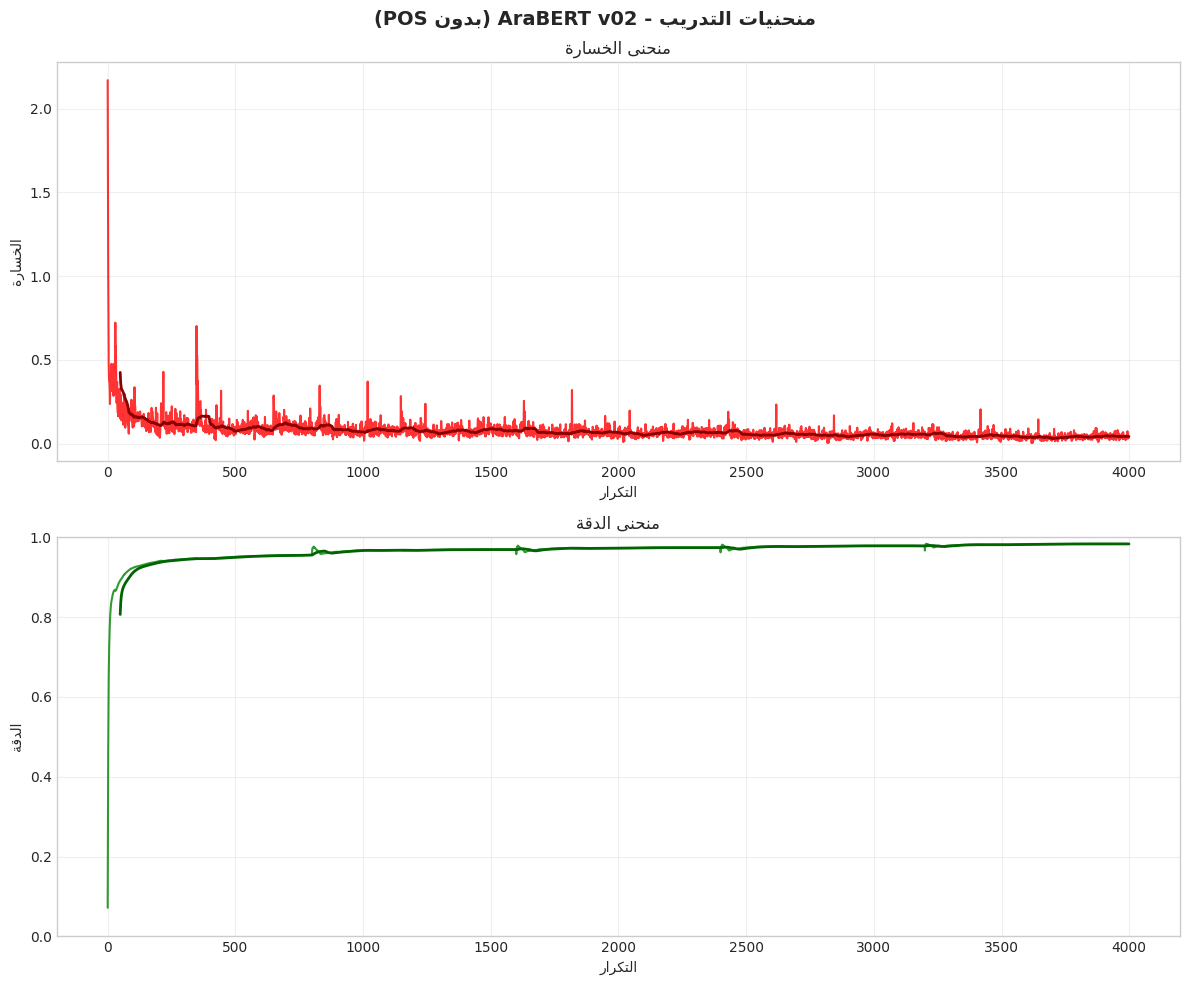

INFO:notebook_20251226_211055_visualizer:تم حفظ الرسم: ./logs/20251226_211055/plots/confusion_matrix_AraBERT v02_without_pos.png


[معلومات] [visualizer] تم حفظ الرسم: ./logs/20251226_211055/plots/confusion_matrix_AraBERT v02_without_pos.png


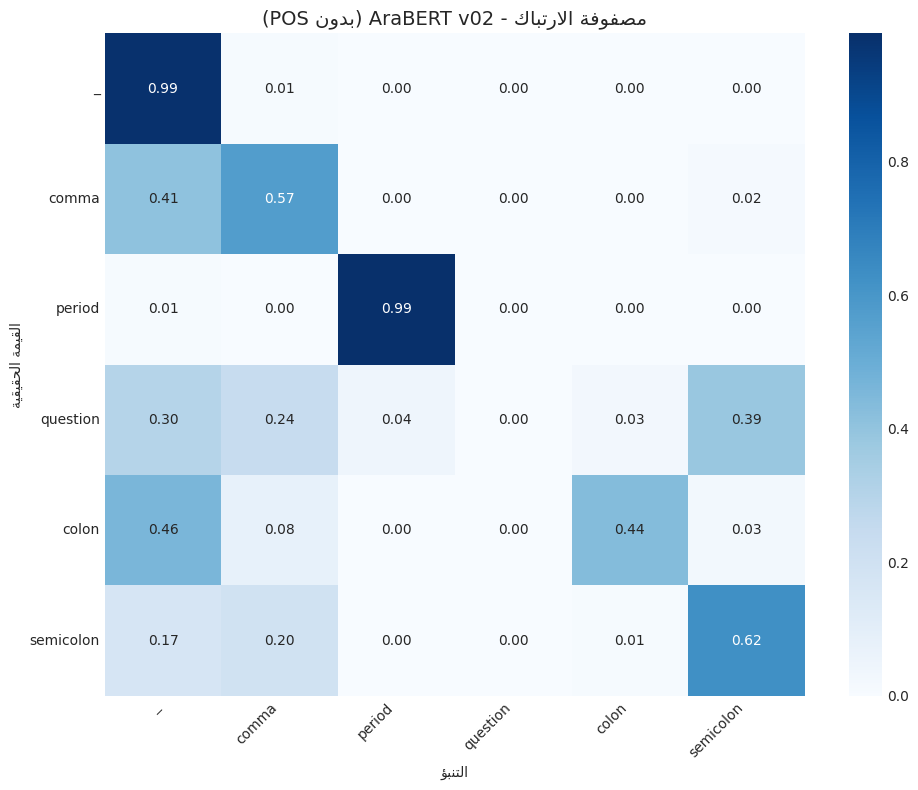

INFO:notebook_20251226_211055_visualizer:تم حفظ الرسم: ./logs/20251226_211055/plots/classification_report_AraBERT v02_without_pos.png


[معلومات] [visualizer] تم حفظ الرسم: ./logs/20251226_211055/plots/classification_report_AraBERT v02_without_pos.png


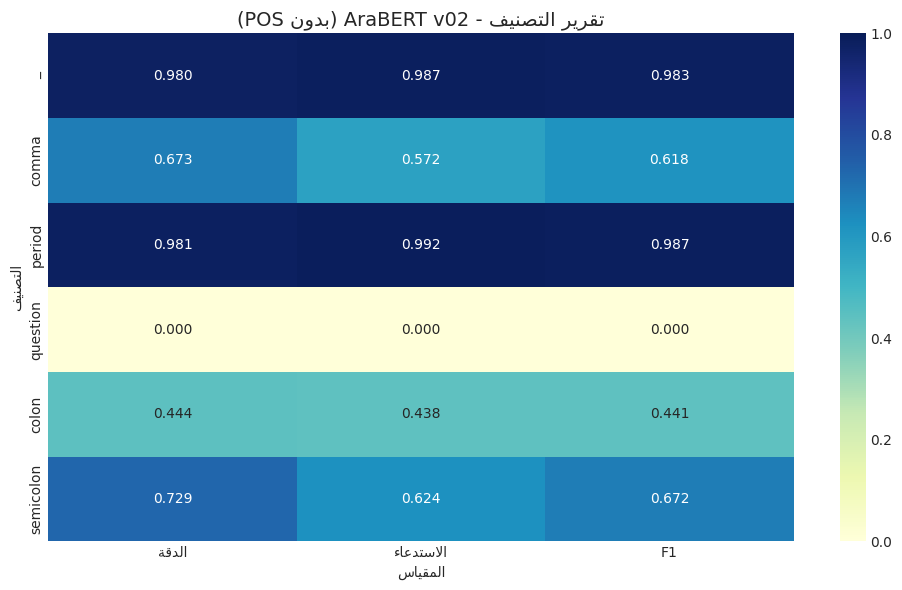

INFO:notebook_20251226_211055_visualizer:تم حفظ الرسم: ./logs/20251226_211055/plots/label_analysis_AraBERT v02_without_pos.png


[معلومات] [visualizer] تم حفظ الرسم: ./logs/20251226_211055/plots/label_analysis_AraBERT v02_without_pos.png


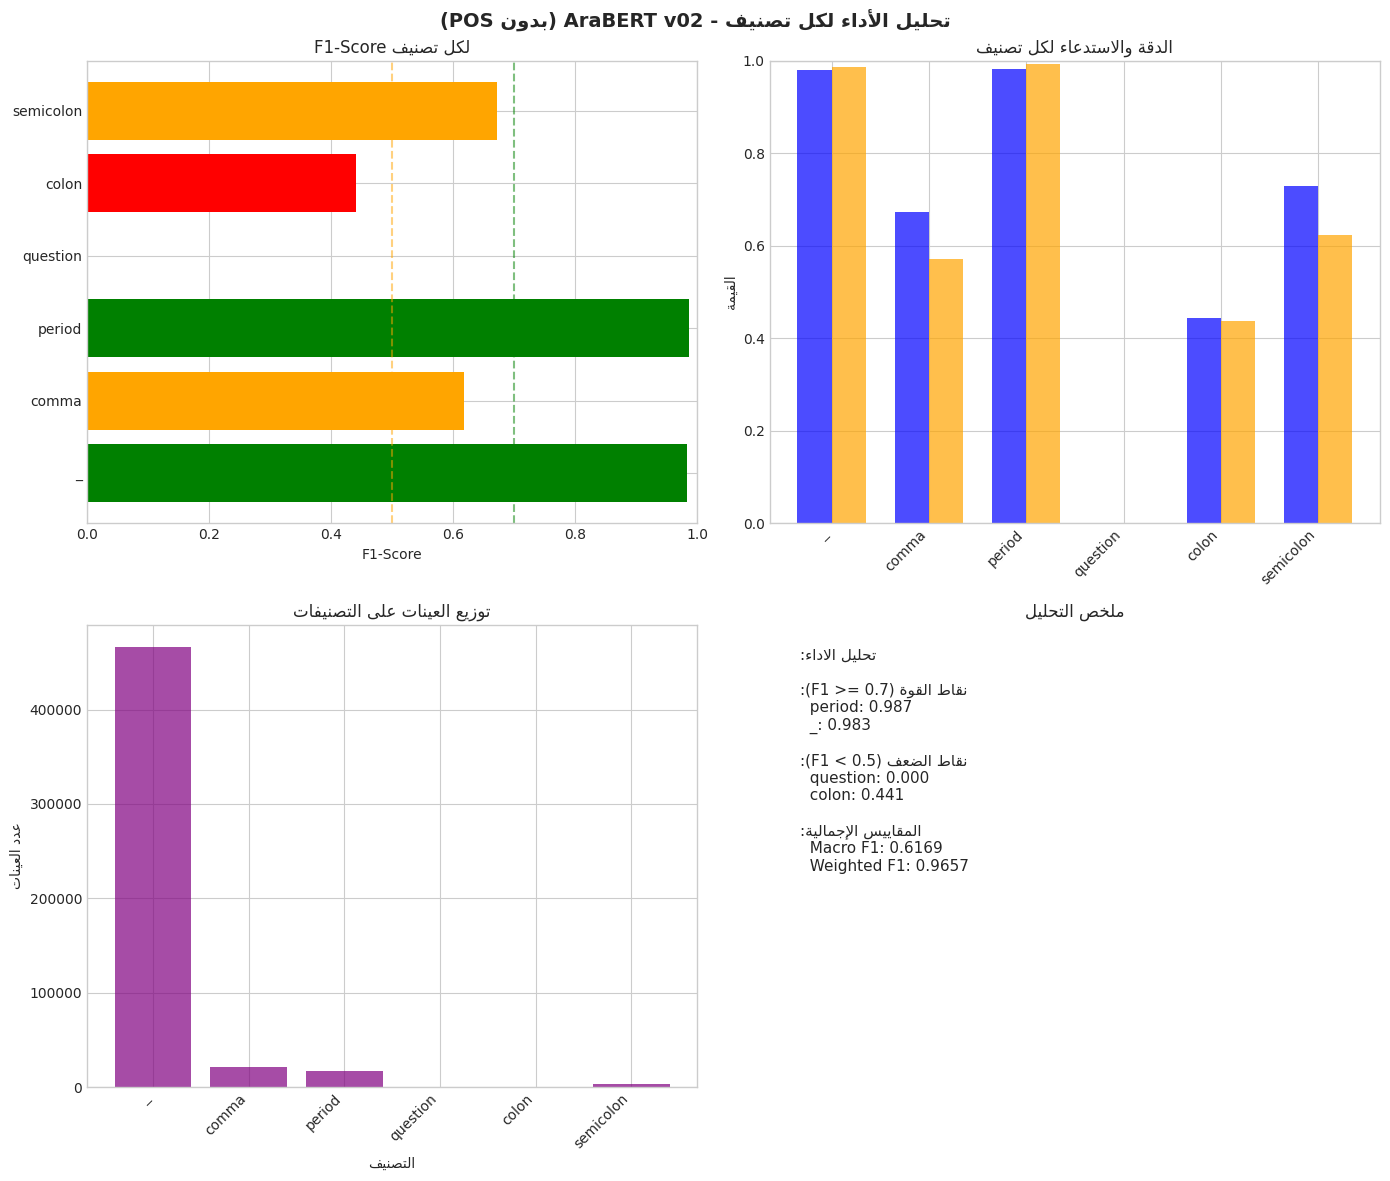

INFO:notebook_20251226_211055_main:SUCCESS: اكتملت التجربة: arabert_without_pos
INFO:notebook_20251226_211055_main:الدقة: 0.9670
INFO:notebook_20251226_211055_main:Macro F1: 0.6169
INFO:notebook_20251226_211055_main:Weighted F1: 0.9657
INFO:notebook_20251226_211055_main:----------------------------------------
INFO:notebook_20251226_211055_main:النموذج: AraELECTRA
INFO:notebook_20251226_211055_main:التجربة 2/3: AraELECTRA (بدون POS)
INFO:notebook_20251226_211055_main:جاري تحميل نموذج جديد...
INFO:notebook_20251226_211055_model_manager:جاري تحميل النموذج: aubmindlab/araelectra-base-discriminator


[نجاح] [main] اكتملت التجربة: arabert_without_pos
[معلومات] [main] الدقة: 0.9670
[معلومات] [main] Macro F1: 0.6169
[معلومات] [main] Weighted F1: 0.9657
[معلومات] [main] ----------------------------------------
[معلومات] [main] النموذج: AraELECTRA
[معلومات] [main] التجربة 2/3: AraELECTRA (بدون POS)
[معلومات] [main] جاري تحميل نموذج جديد...
[معلومات] [model_manager] جاري تحميل النموذج: aubmindlab/araelectra-base-discriminator


tokenizer_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at aubmindlab/araelectra-base-discriminator and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:notebook_20251226_211055_model_manager:SUCCESS: تم تحميل النموذج بنجاح: aubmindlab/araelectra-base-discriminator
DEBUG:notebook_20251226_211055_dataset:تم تهيئة مجموعة البيانات من: ./drive/MyDrive/train
DEBUG:notebook_20251226_211055_dataset:عدد الملفات: 74
DEBUG:notebook_20251226_211055_dataset:استخدام POS: False
DEBUG:notebook_20251226_211055_dataset:تم تهيئة مجموعة البيانات من: ./drive/MyDrive/test
DEBUG:notebook_20251226_211055_dataset:عدد الملفات: 5
DEBUG:notebook_20251226_211055_dataset:استخدام POS: False
INFO:notebook_20251226_211055_araelectra_without_pos:بدء تسجيل النموذج: araelectra
INFO:notebook_20251226_211055_araelectra_without_pos:استخدام تحليل أقسام الكلام

[نجاح] [model_manager] تم تحميل النموذج بنجاح: aubmindlab/araelectra-base-discriminator
[تصحيح] [dataset] تم تهيئة مجموعة البيانات من: ./drive/MyDrive/train
[تصحيح] [dataset] عدد الملفات: 74
[تصحيح] [dataset] استخدام POS: False
[تصحيح] [dataset] تم تهيئة مجموعة البيانات من: ./drive/MyDrive/test
[تصحيح] [dataset] عدد الملفات: 5
[تصحيح] [dataset] استخدام POS: False
[معلومات] [araelectra_without_pos] بدء تسجيل النموذج: araelectra
[معلومات] [araelectra_without_pos] استخدام تحليل أقسام الكلام: False
[معلومات] [araelectra_without_pos] تم تهيئة المدرب
[معلومات] [main] بدء التدريب...
[معلومات] [main] الحقبة 1/5


الحقبة 1: 49it [00:12,  4.45it/s, loss=0.3898, acc=0.8569]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.3898, الدقة: 0.8569
الحقبة 1: 50it [00:12,  4.49it/s, loss=0.3898, acc=0.8569]

[تقدم] [araelectra_without_pos] 50/800 (6.2%) - الخسارة: 0.3898, الدقة: 0.8569


الحقبة 1: 99it [00:26,  3.72it/s, loss=0.2042, acc=0.8925]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.8925
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 100/800 (12.5%) - الخسارة: 0.2042, الدقة: 0.8925
الحقبة 1: 100it [00:29,  1.01s/it, loss=0.2042, acc=0.8925]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.8925
[تقدم] [araelectra_without_pos] 100/800 (12.5%) - الخسارة: 0.2042, الدقة: 0.8925


الحقبة 1: 149it [00:42,  4.06it/s, loss=0.1463, acc=0.9119]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 150/800 (18.8%) - الخسارة: 0.1463, الدقة: 0.9119
الحقبة 1: 150it [00:42,  4.12it/s, loss=0.1463, acc=0.9119]

[تقدم] [araelectra_without_pos] 150/800 (18.8%) - الخسارة: 0.1463, الدقة: 0.9119


الحقبة 1: 199it [00:55,  3.71it/s, loss=0.1097, acc=0.9244]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9244
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 200/800 (25.0%) - الخسارة: 0.1097, الدقة: 0.9244
الحقبة 1: 200it [00:58,  1.22s/it, loss=0.1097, acc=0.9244]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9244
[تقدم] [araelectra_without_pos] 200/800 (25.0%) - الخسارة: 0.1097, الدقة: 0.9244


الحقبة 1: 249it [01:10,  4.29it/s, loss=0.1153, acc=0.9299]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 250/800 (31.2%) - الخسارة: 0.1153, الدقة: 0.9299
الحقبة 1: 250it [01:10,  4.40it/s, loss=0.1153, acc=0.9299]

[تقدم] [araelectra_without_pos] 250/800 (31.2%) - الخسارة: 0.1153, الدقة: 0.9299


الحقبة 1: 299it [01:31,  3.82it/s, loss=0.1633, acc=0.9348]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9348
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 300/800 (37.5%) - الخسارة: 0.1633, الدقة: 0.9348
الحقبة 1: 300it [01:34,  1.09s/it, loss=0.1633, acc=0.9348]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9348
[تقدم] [araelectra_without_pos] 300/800 (37.5%) - الخسارة: 0.1633, الدقة: 0.9348


الحقبة 1: 349it [01:47,  3.52it/s, loss=0.4173, acc=0.9372]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 350/800 (43.8%) - الخسارة: 0.4173, الدقة: 0.9372
الحقبة 1: 350it [01:47,  3.48it/s, loss=0.4173, acc=0.9372]

[تقدم] [araelectra_without_pos] 350/800 (43.8%) - الخسارة: 0.4173, الدقة: 0.9372


الحقبة 1: 399it [02:08,  3.75it/s, loss=0.1499, acc=0.9378]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9378
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 400/800 (50.0%) - الخسارة: 0.1499, الدقة: 0.9378
الحقبة 1: 400it [02:11,  1.29s/it, loss=0.1499, acc=0.9378]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9378
[تقدم] [araelectra_without_pos] 400/800 (50.0%) - الخسارة: 0.1499, الدقة: 0.9378


الحقبة 1: 449it [02:24,  3.82it/s, loss=0.1236, acc=0.9401]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 450/800 (56.2%) - الخسارة: 0.1236, الدقة: 0.9401
الحقبة 1: 450it [02:24,  3.63it/s, loss=0.1236, acc=0.9401]

[تقدم] [araelectra_without_pos] 450/800 (56.2%) - الخسارة: 0.1236, الدقة: 0.9401


الحقبة 1: 499it [02:45,  4.50it/s, loss=0.0810, acc=0.9429]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9429
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 500/800 (62.5%) - الخسارة: 0.0810, الدقة: 0.9429
الحقبة 1: 500it [02:48,  1.03it/s, loss=0.0810, acc=0.9429]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9429
[تقدم] [araelectra_without_pos] 500/800 (62.5%) - الخسارة: 0.0810, الدقة: 0.9429


الحقبة 1: 549it [03:00,  4.18it/s, loss=0.2864, acc=0.9445]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 550/800 (68.8%) - الخسارة: 0.2864, الدقة: 0.9445
الحقبة 1: 550it [03:00,  3.85it/s, loss=0.2864, acc=0.9445]

[تقدم] [araelectra_without_pos] 550/800 (68.8%) - الخسارة: 0.2864, الدقة: 0.9445


الحقبة 1: 599it [03:20,  4.25it/s, loss=0.0863, acc=0.9457]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9457
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 600/800 (75.0%) - الخسارة: 0.0863, الدقة: 0.9457
الحقبة 1: 600it [03:24,  1.31s/it, loss=0.0863, acc=0.9457]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9457
[تقدم] [araelectra_without_pos] 600/800 (75.0%) - الخسارة: 0.0863, الدقة: 0.9457


الحقبة 1: 649it [03:36,  3.89it/s, loss=0.3363, acc=0.9471]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 650/800 (81.2%) - الخسارة: 0.3363, الدقة: 0.9471
الحقبة 1: 650it [03:36,  3.55it/s, loss=0.3363, acc=0.9471]

[تقدم] [araelectra_without_pos] 650/800 (81.2%) - الخسارة: 0.3363, الدقة: 0.9471


الحقبة 1: 699it [03:58,  3.82it/s, loss=0.1803, acc=0.9474]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9474
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 700/800 (87.5%) - الخسارة: 0.1803, الدقة: 0.9474
الحقبة 1: 700it [04:00,  1.01s/it, loss=0.1803, acc=0.9474]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9474
[تقدم] [araelectra_without_pos] 700/800 (87.5%) - الخسارة: 0.1803, الدقة: 0.9474


الحقبة 1: 749it [04:12,  4.31it/s, loss=0.0684, acc=0.9481]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 750/800 (93.8%) - الخسارة: 0.0684, الدقة: 0.9481
الحقبة 1: 750it [04:12,  4.28it/s, loss=0.0684, acc=0.9481]

[تقدم] [araelectra_without_pos] 750/800 (93.8%) - الخسارة: 0.0684, الدقة: 0.9481


الحقبة 1: 799it [04:33,  4.35it/s, loss=0.0662, acc=0.9491]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9491
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 800/800 (100.0%) - الخسارة: 0.0662, الدقة: 0.9491
الحقبة 1: 800it [04:36,  2.89it/s, loss=0.0662, acc=0.9491]
INFO:notebook_20251226_211055_araelectra_without_pos:METRICS: loss: 0.1796 | accuracy: 0.9491 | epoch: 1.0000 | iterations: 800.0000
INFO:notebook_20251226_211055_main:الحقبة 2/5


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9491
[تقدم] [araelectra_without_pos] 800/800 (100.0%) - الخسارة: 0.0662, الدقة: 0.9491
[مقاييس] [araelectra_without_pos] loss: 0.1796 | accuracy: 0.9491 | epoch: 1.0000 | iterations: 800.0000
[معلومات] [main] الحقبة 2/5


الحقبة 2: 49it [00:12,  3.99it/s, loss=0.1147, acc=0.9555]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.1147, الدقة: 0.9555
الحقبة 2: 50it [00:12,  4.03it/s, loss=0.1147, acc=0.9555]

[تقدم] [araelectra_without_pos] 50/800 (6.2%) - الخسارة: 0.1147, الدقة: 0.9555


الحقبة 2: 99it [00:33,  3.78it/s, loss=0.1462, acc=0.9600]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9600
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 100/800 (12.5%) - الخسارة: 0.1462, الدقة: 0.9600
الحقبة 2: 100it [00:36,  1.14s/it, loss=0.1462, acc=0.9600]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9600
[تقدم] [araelectra_without_pos] 100/800 (12.5%) - الخسارة: 0.1462, الدقة: 0.9600


الحقبة 2: 149it [00:49,  3.68it/s, loss=0.0993, acc=0.9619]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 150/800 (18.8%) - الخسارة: 0.0993, الدقة: 0.9619
الحقبة 2: 150it [00:49,  3.76it/s, loss=0.0993, acc=0.9619]

[تقدم] [araelectra_without_pos] 150/800 (18.8%) - الخسارة: 0.0993, الدقة: 0.9619


الحقبة 2: 199it [01:10,  3.68it/s, loss=0.0837, acc=0.9638]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9638
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 200/800 (25.0%) - الخسارة: 0.0837, الدقة: 0.9638
الحقبة 2: 200it [01:13,  1.23s/it, loss=0.0837, acc=0.9638]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9638
[تقدم] [araelectra_without_pos] 200/800 (25.0%) - الخسارة: 0.0837, الدقة: 0.9638


الحقبة 2: 249it [01:25,  4.20it/s, loss=0.0768, acc=0.9636]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 250/800 (31.2%) - الخسارة: 0.0768, الدقة: 0.9636
الحقبة 2: 250it [01:25,  4.19it/s, loss=0.0768, acc=0.9636]

[تقدم] [araelectra_without_pos] 250/800 (31.2%) - الخسارة: 0.0768, الدقة: 0.9636


الحقبة 2: 299it [01:47,  4.01it/s, loss=0.1311, acc=0.9641]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9641
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 300/800 (37.5%) - الخسارة: 0.1311, الدقة: 0.9641
الحقبة 2: 300it [01:52,  1.57s/it, loss=0.1311, acc=0.9641]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9641
[تقدم] [araelectra_without_pos] 300/800 (37.5%) - الخسارة: 0.1311, الدقة: 0.9641


الحقبة 2: 349it [02:05,  3.72it/s, loss=0.2556, acc=0.9637]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 350/800 (43.8%) - الخسارة: 0.2556, الدقة: 0.9637
الحقبة 2: 350it [02:05,  3.61it/s, loss=0.2556, acc=0.9637]

[تقدم] [araelectra_without_pos] 350/800 (43.8%) - الخسارة: 0.2556, الدقة: 0.9637


الحقبة 2: 399it [02:26,  3.67it/s, loss=0.1205, acc=0.9632]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 400/800 (50.0%) - الخسارة: 0.1205, الدقة: 0.9632
الحقبة 2: 400it [02:26,  3.74it/s, loss=0.1205, acc=0.9632]

[تقدم] [araelectra_without_pos] 400/800 (50.0%) - الخسارة: 0.1205, الدقة: 0.9632


الحقبة 2: 449it [02:39,  4.00it/s, loss=0.0896, acc=0.9637]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 450/800 (56.2%) - الخسارة: 0.0896, الدقة: 0.9637
الحقبة 2: 450it [02:39,  3.85it/s, loss=0.0896, acc=0.9637]

[تقدم] [araelectra_without_pos] 450/800 (56.2%) - الخسارة: 0.0896, الدقة: 0.9637


الحقبة 2: 499it [02:51,  4.35it/s, loss=0.0503, acc=0.9648]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9648
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 500/800 (62.5%) - الخسارة: 0.0503, الدقة: 0.9648
الحقبة 2: 500it [02:56,  1.69s/it, loss=0.0503, acc=0.9648]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9648
[تقدم] [araelectra_without_pos] 500/800 (62.5%) - الخسارة: 0.0503, الدقة: 0.9648


الحقبة 2: 549it [03:07,  4.38it/s, loss=0.1530, acc=0.9651]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 550/800 (68.8%) - الخسارة: 0.1530, الدقة: 0.9651
الحقبة 2: 550it [03:07,  4.15it/s, loss=0.1530, acc=0.9651]

[تقدم] [araelectra_without_pos] 550/800 (68.8%) - الخسارة: 0.1530, الدقة: 0.9651


الحقبة 2: 599it [03:19,  4.40it/s, loss=0.0669, acc=0.9654]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9654
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 600/800 (75.0%) - الخسارة: 0.0669, الدقة: 0.9654
الحقبة 2: 600it [03:22,  1.05s/it, loss=0.0669, acc=0.9654]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9654
[تقدم] [araelectra_without_pos] 600/800 (75.0%) - الخسارة: 0.0669, الدقة: 0.9654


الحقبة 2: 649it [03:33,  4.40it/s, loss=0.2142, acc=0.9659]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 650/800 (81.2%) - الخسارة: 0.2142, الدقة: 0.9659
الحقبة 2: 650it [03:34,  3.96it/s, loss=0.2142, acc=0.9659]

[تقدم] [araelectra_without_pos] 650/800 (81.2%) - الخسارة: 0.2142, الدقة: 0.9659


الحقبة 2: 699it [03:46,  3.78it/s, loss=0.1309, acc=0.9655]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9655
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 700/800 (87.5%) - الخسارة: 0.1309, الدقة: 0.9655
الحقبة 2: 700it [03:50,  1.28s/it, loss=0.1309, acc=0.9655]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9655
[تقدم] [araelectra_without_pos] 700/800 (87.5%) - الخسارة: 0.1309, الدقة: 0.9655


الحقبة 2: 749it [04:02,  4.26it/s, loss=0.0497, acc=0.9658]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 750/800 (93.8%) - الخسارة: 0.0497, الدقة: 0.9658
الحقبة 2: 750it [04:02,  4.33it/s, loss=0.0497, acc=0.9658]

[تقدم] [araelectra_without_pos] 750/800 (93.8%) - الخسارة: 0.0497, الدقة: 0.9658


الحقبة 2: 799it [04:13,  4.13it/s, loss=0.0534, acc=0.9659]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9659
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 800/800 (100.0%) - الخسارة: 0.0534, الدقة: 0.9659
الحقبة 2: 800it [04:18,  3.10it/s, loss=0.0534, acc=0.9659]
INFO:notebook_20251226_211055_araelectra_without_pos:METRICS: loss: 0.0953 | accuracy: 0.9659 | epoch: 2.0000 | iterations: 800.0000
INFO:notebook_20251226_211055_main:الحقبة 3/5


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9659
[تقدم] [araelectra_without_pos] 800/800 (100.0%) - الخسارة: 0.0534, الدقة: 0.9659
[مقاييس] [araelectra_without_pos] loss: 0.0953 | accuracy: 0.9659 | epoch: 2.0000 | iterations: 800.0000
[معلومات] [main] الحقبة 3/5


الحقبة 3: 49it [00:12,  4.40it/s, loss=0.0979, acc=0.9623]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.0979, الدقة: 0.9623
الحقبة 3: 50it [00:12,  4.47it/s, loss=0.0979, acc=0.9623]

[تقدم] [araelectra_without_pos] 50/800 (6.2%) - الخسارة: 0.0979, الدقة: 0.9623


الحقبة 3: 99it [00:25,  3.77it/s, loss=0.1087, acc=0.9668]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9668
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 100/800 (12.5%) - الخسارة: 0.1087, الدقة: 0.9668
الحقبة 3: 100it [00:28,  1.20s/it, loss=0.1087, acc=0.9668]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9668
[تقدم] [araelectra_without_pos] 100/800 (12.5%) - الخسارة: 0.1087, الدقة: 0.9668


الحقبة 3: 149it [00:41,  4.20it/s, loss=0.0777, acc=0.9690]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 150/800 (18.8%) - الخسارة: 0.0777, الدقة: 0.9690
الحقبة 3: 150it [00:41,  4.31it/s, loss=0.0777, acc=0.9690]

[تقدم] [araelectra_without_pos] 150/800 (18.8%) - الخسارة: 0.0777, الدقة: 0.9690


الحقبة 3: 199it [00:54,  3.65it/s, loss=0.0657, acc=0.9702]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9702
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 200/800 (25.0%) - الخسارة: 0.0657, الدقة: 0.9702
الحقبة 3: 200it [00:56,  1.04s/it, loss=0.0657, acc=0.9702]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9702
[تقدم] [araelectra_without_pos] 200/800 (25.0%) - الخسارة: 0.0657, الدقة: 0.9702


الحقبة 3: 249it [01:08,  4.43it/s, loss=0.0647, acc=0.9696]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 250/800 (31.2%) - الخسارة: 0.0647, الدقة: 0.9696
الحقبة 3: 250it [01:08,  4.49it/s, loss=0.0647, acc=0.9696]

[تقدم] [araelectra_without_pos] 250/800 (31.2%) - الخسارة: 0.0647, الدقة: 0.9696


الحقبة 3: 299it [01:20,  4.00it/s, loss=0.0997, acc=0.9698]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 300/800 (37.5%) - الخسارة: 0.0997, الدقة: 0.9698
الحقبة 3: 300it [01:20,  4.05it/s, loss=0.0997, acc=0.9698]

[تقدم] [araelectra_without_pos] 300/800 (37.5%) - الخسارة: 0.0997, الدقة: 0.9698


الحقبة 3: 349it [01:33,  3.98it/s, loss=0.1483, acc=0.9696]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 350/800 (43.8%) - الخسارة: 0.1483, الدقة: 0.9696
الحقبة 3: 350it [01:33,  3.90it/s, loss=0.1483, acc=0.9696]

[تقدم] [araelectra_without_pos] 350/800 (43.8%) - الخسارة: 0.1483, الدقة: 0.9696


الحقبة 3: 399it [01:45,  3.73it/s, loss=0.0983, acc=0.9698]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 400/800 (50.0%) - الخسارة: 0.0983, الدقة: 0.9698
الحقبة 3: 400it [01:45,  3.79it/s, loss=0.0983, acc=0.9698]

[تقدم] [araelectra_without_pos] 400/800 (50.0%) - الخسارة: 0.0983, الدقة: 0.9698


الحقبة 3: 449it [01:57,  4.24it/s, loss=0.0664, acc=0.9701]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 450/800 (56.2%) - الخسارة: 0.0664, الدقة: 0.9701
الحقبة 3: 450it [01:57,  4.08it/s, loss=0.0664, acc=0.9701]

[تقدم] [araelectra_without_pos] 450/800 (56.2%) - الخسارة: 0.0664, الدقة: 0.9701


الحقبة 3: 499it [02:09,  4.55it/s, loss=0.0431, acc=0.9711]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9711
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 500/800 (62.5%) - الخسارة: 0.0431, الدقة: 0.9711
الحقبة 3: 500it [02:12,  1.27s/it, loss=0.0431, acc=0.9711]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9711
[تقدم] [araelectra_without_pos] 500/800 (62.5%) - الخسارة: 0.0431, الدقة: 0.9711


الحقبة 3: 549it [02:24,  4.43it/s, loss=0.1074, acc=0.9713]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 550/800 (68.8%) - الخسارة: 0.1074, الدقة: 0.9713
الحقبة 3: 550it [02:24,  4.18it/s, loss=0.1074, acc=0.9713]

[تقدم] [araelectra_without_pos] 550/800 (68.8%) - الخسارة: 0.1074, الدقة: 0.9713


الحقبة 3: 599it [02:35,  4.58it/s, loss=0.0621, acc=0.9713]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9713
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 600/800 (75.0%) - الخسارة: 0.0621, الدقة: 0.9713
الحقبة 3: 600it [02:38,  1.00it/s, loss=0.0621, acc=0.9713]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9713
[تقدم] [araelectra_without_pos] 600/800 (75.0%) - الخسارة: 0.0621, الدقة: 0.9713


الحقبة 3: 649it [02:50,  4.28it/s, loss=0.1159, acc=0.9717]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 650/800 (81.2%) - الخسارة: 0.1159, الدقة: 0.9717
الحقبة 3: 650it [02:50,  3.81it/s, loss=0.1159, acc=0.9717]

[تقدم] [araelectra_without_pos] 650/800 (81.2%) - الخسارة: 0.1159, الدقة: 0.9717


الحقبة 3: 699it [03:12,  3.90it/s, loss=0.0936, acc=0.9715]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9715
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 700/800 (87.5%) - الخسارة: 0.0936, الدقة: 0.9715
الحقبة 3: 700it [03:17,  1.63s/it, loss=0.0936, acc=0.9715]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9715
[تقدم] [araelectra_without_pos] 700/800 (87.5%) - الخسارة: 0.0936, الدقة: 0.9715


الحقبة 3: 749it [03:29,  4.01it/s, loss=0.0454, acc=0.9717]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 750/800 (93.8%) - الخسارة: 0.0454, الدقة: 0.9717
الحقبة 3: 750it [03:29,  4.08it/s, loss=0.0454, acc=0.9717]

[تقدم] [araelectra_without_pos] 750/800 (93.8%) - الخسارة: 0.0454, الدقة: 0.9717


الحقبة 3: 799it [03:48,  4.25it/s, loss=0.0432, acc=0.9717]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9717
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 800/800 (100.0%) - الخسارة: 0.0432, الدقة: 0.9717
الحقبة 3: 800it [03:51,  3.45it/s, loss=0.0432, acc=0.9717]
INFO:notebook_20251226_211055_araelectra_without_pos:METRICS: loss: 0.0758 | accuracy: 0.9717 | epoch: 3.0000 | iterations: 800.0000
INFO:notebook_20251226_211055_main:الحقبة 4/5


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9717
[تقدم] [araelectra_without_pos] 800/800 (100.0%) - الخسارة: 0.0432, الدقة: 0.9717
[مقاييس] [araelectra_without_pos] loss: 0.0758 | accuracy: 0.9717 | epoch: 3.0000 | iterations: 800.0000
[معلومات] [main] الحقبة 4/5


الحقبة 4: 49it [00:12,  3.92it/s, loss=0.0859, acc=0.9685]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.0859, الدقة: 0.9685
الحقبة 4: 50it [00:12,  3.93it/s, loss=0.0859, acc=0.9685]

[تقدم] [araelectra_without_pos] 50/800 (6.2%) - الخسارة: 0.0859, الدقة: 0.9685


الحقبة 4: 99it [00:34,  3.84it/s, loss=0.0905, acc=0.9726]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9726
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 100/800 (12.5%) - الخسارة: 0.0905, الدقة: 0.9726
الحقبة 4: 100it [00:37,  1.23s/it, loss=0.0905, acc=0.9726]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9726
[تقدم] [araelectra_without_pos] 100/800 (12.5%) - الخسارة: 0.0905, الدقة: 0.9726


الحقبة 4: 149it [00:50,  3.65it/s, loss=0.0704, acc=0.9746]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 150/800 (18.8%) - الخسارة: 0.0704, الدقة: 0.9746
الحقبة 4: 150it [00:50,  3.72it/s, loss=0.0704, acc=0.9746]

[تقدم] [araelectra_without_pos] 150/800 (18.8%) - الخسارة: 0.0704, الدقة: 0.9746


الحقبة 4: 199it [01:12,  3.65it/s, loss=0.0525, acc=0.9755]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9755
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 200/800 (25.0%) - الخسارة: 0.0525, الدقة: 0.9755
الحقبة 4: 200it [01:16,  1.61s/it, loss=0.0525, acc=0.9755]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9755
[تقدم] [araelectra_without_pos] 200/800 (25.0%) - الخسارة: 0.0525, الدقة: 0.9755


الحقبة 4: 249it [01:29,  4.20it/s, loss=0.0516, acc=0.9749]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 250/800 (31.2%) - الخسارة: 0.0516, الدقة: 0.9749
الحقبة 4: 250it [01:29,  4.17it/s, loss=0.0516, acc=0.9749]

[تقدم] [araelectra_without_pos] 250/800 (31.2%) - الخسارة: 0.0516, الدقة: 0.9749


الحقبة 4: 299it [01:51,  3.93it/s, loss=0.0799, acc=0.9751]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 300/800 (37.5%) - الخسارة: 0.0799, الدقة: 0.9751
الحقبة 4: 300it [01:51,  3.95it/s, loss=0.0799, acc=0.9751]

[تقدم] [araelectra_without_pos] 300/800 (37.5%) - الخسارة: 0.0799, الدقة: 0.9751


الحقبة 4: 349it [02:04,  3.79it/s, loss=0.0692, acc=0.9749]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 350/800 (43.8%) - الخسارة: 0.0692, الدقة: 0.9749
الحقبة 4: 350it [02:04,  3.75it/s, loss=0.0692, acc=0.9749]

[تقدم] [araelectra_without_pos] 350/800 (43.8%) - الخسارة: 0.0692, الدقة: 0.9749


الحقبة 4: 399it [02:16,  3.76it/s, loss=0.0860, acc=0.9751]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 400/800 (50.0%) - الخسارة: 0.0860, الدقة: 0.9751
الحقبة 4: 400it [02:16,  3.78it/s, loss=0.0860, acc=0.9751]

[تقدم] [araelectra_without_pos] 400/800 (50.0%) - الخسارة: 0.0860, الدقة: 0.9751


الحقبة 4: 449it [02:29,  4.33it/s, loss=0.0459, acc=0.9753]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 450/800 (56.2%) - الخسارة: 0.0459, الدقة: 0.9753
الحقبة 4: 450it [02:29,  4.17it/s, loss=0.0459, acc=0.9753]

[تقدم] [araelectra_without_pos] 450/800 (56.2%) - الخسارة: 0.0459, الدقة: 0.9753


الحقبة 4: 499it [02:41,  4.43it/s, loss=0.0340, acc=0.9761]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9761
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 500/800 (62.5%) - الخسارة: 0.0340, الدقة: 0.9761
الحقبة 4: 500it [02:44,  1.17s/it, loss=0.0340, acc=0.9761]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9761
[تقدم] [araelectra_without_pos] 500/800 (62.5%) - الخسارة: 0.0340, الدقة: 0.9761


الحقبة 4: 549it [02:56,  4.25it/s, loss=0.0794, acc=0.9763]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 550/800 (68.8%) - الخسارة: 0.0794, الدقة: 0.9763
الحقبة 4: 550it [02:56,  4.06it/s, loss=0.0794, acc=0.9763]

[تقدم] [araelectra_without_pos] 550/800 (68.8%) - الخسارة: 0.0794, الدقة: 0.9763


الحقبة 4: 599it [03:17,  4.61it/s, loss=0.0590, acc=0.9765]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9765
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 600/800 (75.0%) - الخسارة: 0.0590, الدقة: 0.9765
الحقبة 4: 600it [03:19,  1.02it/s, loss=0.0590, acc=0.9765]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9765
[تقدم] [araelectra_without_pos] 600/800 (75.0%) - الخسارة: 0.0590, الدقة: 0.9765


الحقبة 4: 649it [03:31,  4.41it/s, loss=0.0902, acc=0.9768]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 650/800 (81.2%) - الخسارة: 0.0902, الدقة: 0.9768
الحقبة 4: 650it [03:31,  3.92it/s, loss=0.0902, acc=0.9768]

[تقدم] [araelectra_without_pos] 650/800 (81.2%) - الخسارة: 0.0902, الدقة: 0.9768


الحقبة 4: 699it [03:45,  3.65it/s, loss=0.0859, acc=0.9768]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9768
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 700/800 (87.5%) - الخسارة: 0.0859, الدقة: 0.9768
الحقبة 4: 700it [03:58,  4.04s/it, loss=0.0859, acc=0.9768]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9768
[تقدم] [araelectra_without_pos] 700/800 (87.5%) - الخسارة: 0.0859, الدقة: 0.9768


الحقبة 4: 749it [04:10,  4.10it/s, loss=0.0385, acc=0.9769]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 750/800 (93.8%) - الخسارة: 0.0385, الدقة: 0.9769
الحقبة 4: 750it [04:10,  4.14it/s, loss=0.0385, acc=0.9769]

[تقدم] [araelectra_without_pos] 750/800 (93.8%) - الخسارة: 0.0385, الدقة: 0.9769


الحقبة 4: 799it [04:29,  4.03it/s, loss=0.0383, acc=0.9768]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9768
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 800/800 (100.0%) - الخسارة: 0.0383, الدقة: 0.9768
الحقبة 4: 800it [04:32,  2.93it/s, loss=0.0383, acc=0.9768]
INFO:notebook_20251226_211055_araelectra_without_pos:METRICS: loss: 0.0610 | accuracy: 0.9768 | epoch: 4.0000 | iterations: 800.0000
INFO:notebook_20251226_211055_main:الحقبة 5/5


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9768
[تقدم] [araelectra_without_pos] 800/800 (100.0%) - الخسارة: 0.0383, الدقة: 0.9768
[مقاييس] [araelectra_without_pos] loss: 0.0610 | accuracy: 0.9768 | epoch: 4.0000 | iterations: 800.0000
[معلومات] [main] الحقبة 5/5


الحقبة 5: 49it [00:12,  3.72it/s, loss=0.0663, acc=0.9762]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.0663, الدقة: 0.9762
الحقبة 5: 50it [00:12,  3.76it/s, loss=0.0663, acc=0.9762]

[تقدم] [araelectra_without_pos] 50/800 (6.2%) - الخسارة: 0.0663, الدقة: 0.9762


الحقبة 5: 99it [00:33,  3.84it/s, loss=0.0623, acc=0.9785]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9785
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 100/800 (12.5%) - الخسارة: 0.0623, الدقة: 0.9785
الحقبة 5: 100it [00:35,  1.03s/it, loss=0.0623, acc=0.9785]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9785
[تقدم] [araelectra_without_pos] 100/800 (12.5%) - الخسارة: 0.0623, الدقة: 0.9785


الحقبة 5: 149it [00:48,  4.11it/s, loss=0.0625, acc=0.9805]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 150/800 (18.8%) - الخسارة: 0.0625, الدقة: 0.9805
الحقبة 5: 150it [00:48,  4.23it/s, loss=0.0625, acc=0.9805]

[تقدم] [araelectra_without_pos] 150/800 (18.8%) - الخسارة: 0.0625, الدقة: 0.9805


الحقبة 5: 199it [01:11,  3.68it/s, loss=0.0351, acc=0.9809]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9809
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 200/800 (25.0%) - الخسارة: 0.0351, الدقة: 0.9809
الحقبة 5: 200it [01:13,  1.05s/it, loss=0.0351, acc=0.9809]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9809
[تقدم] [araelectra_without_pos] 200/800 (25.0%) - الخسارة: 0.0351, الدقة: 0.9809


الحقبة 5: 249it [01:26,  4.04it/s, loss=0.0449, acc=0.9804]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 250/800 (31.2%) - الخسارة: 0.0449, الدقة: 0.9804
الحقبة 5: 250it [01:26,  4.03it/s, loss=0.0449, acc=0.9804]

[تقدم] [araelectra_without_pos] 250/800 (31.2%) - الخسارة: 0.0449, الدقة: 0.9804


الحقبة 5: 299it [01:46,  4.03it/s, loss=0.0583, acc=0.9805]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 300/800 (37.5%) - الخسارة: 0.0583, الدقة: 0.9805
الحقبة 5: 300it [01:46,  4.05it/s, loss=0.0583, acc=0.9805]

[تقدم] [araelectra_without_pos] 300/800 (37.5%) - الخسارة: 0.0583, الدقة: 0.9805


الحقبة 5: 349it [01:59,  3.79it/s, loss=0.0481, acc=0.9805]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 350/800 (43.8%) - الخسارة: 0.0481, الدقة: 0.9805
الحقبة 5: 350it [01:59,  3.70it/s, loss=0.0481, acc=0.9805]

[تقدم] [araelectra_without_pos] 350/800 (43.8%) - الخسارة: 0.0481, الدقة: 0.9805


الحقبة 5: 399it [02:11,  3.74it/s, loss=0.0546, acc=0.9808]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 400/800 (50.0%) - الخسارة: 0.0546, الدقة: 0.9808
الحقبة 5: 400it [02:11,  3.83it/s, loss=0.0546, acc=0.9808]

[تقدم] [araelectra_without_pos] 400/800 (50.0%) - الخسارة: 0.0546, الدقة: 0.9808


الحقبة 5: 449it [02:24,  4.10it/s, loss=0.0326, acc=0.9811]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 450/800 (56.2%) - الخسارة: 0.0326, الدقة: 0.9811
الحقبة 5: 450it [02:24,  4.02it/s, loss=0.0326, acc=0.9811]

[تقدم] [araelectra_without_pos] 450/800 (56.2%) - الخسارة: 0.0326, الدقة: 0.9811


الحقبة 5: 499it [02:35,  4.54it/s, loss=0.0261, acc=0.9817]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9817
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 500/800 (62.5%) - الخسارة: 0.0261, الدقة: 0.9817
الحقبة 5: 500it [02:40,  1.53s/it, loss=0.0261, acc=0.9817]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9817
[تقدم] [araelectra_without_pos] 500/800 (62.5%) - الخسارة: 0.0261, الدقة: 0.9817


الحقبة 5: 549it [02:51,  4.51it/s, loss=0.0453, acc=0.9819]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 550/800 (68.8%) - الخسارة: 0.0453, الدقة: 0.9819
الحقبة 5: 550it [02:51,  4.18it/s, loss=0.0453, acc=0.9819]

[تقدم] [araelectra_without_pos] 550/800 (68.8%) - الخسارة: 0.0453, الدقة: 0.9819


الحقبة 5: 599it [03:11,  4.60it/s, loss=0.0492, acc=0.9820]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9820
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 600/800 (75.0%) - الخسارة: 0.0492, الدقة: 0.9820
الحقبة 5: 600it [03:16,  1.52s/it, loss=0.0492, acc=0.9820]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9820
[تقدم] [araelectra_without_pos] 600/800 (75.0%) - الخسارة: 0.0492, الدقة: 0.9820


الحقبة 5: 649it [03:28,  4.44it/s, loss=0.0774, acc=0.9823]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 650/800 (81.2%) - الخسارة: 0.0774, الدقة: 0.9823
الحقبة 5: 650it [03:28,  3.91it/s, loss=0.0774, acc=0.9823]

[تقدم] [araelectra_without_pos] 650/800 (81.2%) - الخسارة: 0.0774, الدقة: 0.9823


الحقبة 5: 699it [03:41,  3.63it/s, loss=0.0751, acc=0.9823]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9823
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 700/800 (87.5%) - الخسارة: 0.0751, الدقة: 0.9823
الحقبة 5: 700it [04:02,  6.43s/it, loss=0.0751, acc=0.9823]

[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9823
[تقدم] [araelectra_without_pos] 700/800 (87.5%) - الخسارة: 0.0751, الدقة: 0.9823


الحقبة 5: 749it [04:13,  4.48it/s, loss=0.0362, acc=0.9824]INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 750/800 (93.8%) - الخسارة: 0.0362, الدقة: 0.9824
الحقبة 5: 750it [04:13,  4.56it/s, loss=0.0362, acc=0.9824]

[تقدم] [araelectra_without_pos] 750/800 (93.8%) - الخسارة: 0.0362, الدقة: 0.9824


الحقبة 5: 799it [04:25,  4.12it/s, loss=0.0324, acc=0.9823]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ أفضل نموذج بدقة: 0.9823
INFO:notebook_20251226_211055_araelectra_without_pos:PROGRESS: 800/800 (100.0%) - الخسارة: 0.0324, الدقة: 0.9823
الحقبة 5: 800it [04:35,  2.90it/s, loss=0.0324, acc=0.9823]
INFO:notebook_20251226_211055_araelectra_without_pos:METRICS: loss: 0.0475 | accuracy: 0.9823 | epoch: 5.0000 | iterations: 800.0000
INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_last


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ أفضل نموذج بدقة: 0.9823
[تقدم] [araelectra_without_pos] 800/800 (100.0%) - الخسارة: 0.0324, الدقة: 0.9823
[مقاييس] [araelectra_without_pos] loss: 0.0475 | accuracy: 0.9823 | epoch: 5.0000 | iterations: 800.0000
[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/araelectra_without_pos_last


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم حفظ النموذج بنجاح
INFO:notebook_20251226_211055_araelectra_without_pos:تم حفظ آخر نموذج
INFO:notebook_20251226_211055_main:بدء التقييم...


[نجاح] [model_manager] تم حفظ النموذج بنجاح
[معلومات] [araelectra_without_pos] تم حفظ آخر نموذج
[معلومات] [main] بدء التقييم...


التقييم: 800it [01:17, 10.35it/s]
INFO:notebook_20251226_211055_araelectra_without_pos:دقة التقييم: 0.9657
INFO:notebook_20251226_211055_araelectra_without_pos:Macro F1: 0.5979
INFO:notebook_20251226_211055_araelectra_without_pos:Weighted F1: 0.9650
INFO:notebook_20251226_211055_araelectra_without_pos:METRICS: eval_accuracy: 0.9657 | macro_f1: 0.5979 | weighted_f1: 0.9650
INFO:notebook_20251226_211055_main:إنشاء الرسوم البيانية...


[معلومات] [araelectra_without_pos] دقة التقييم: 0.9657
[معلومات] [araelectra_without_pos] Macro F1: 0.5979
[معلومات] [araelectra_without_pos] Weighted F1: 0.9650
[مقاييس] [araelectra_without_pos] eval_accuracy: 0.9657 | macro_f1: 0.5979 | weighted_f1: 0.9650
[معلومات] [main] إنشاء الرسوم البيانية...


INFO:notebook_20251226_211055_visualizer:تم حفظ الرسم: ./logs/20251226_211055/plots/training_curves_AraELECTRA_without_pos.png


[معلومات] [visualizer] تم حفظ الرسم: ./logs/20251226_211055/plots/training_curves_AraELECTRA_without_pos.png


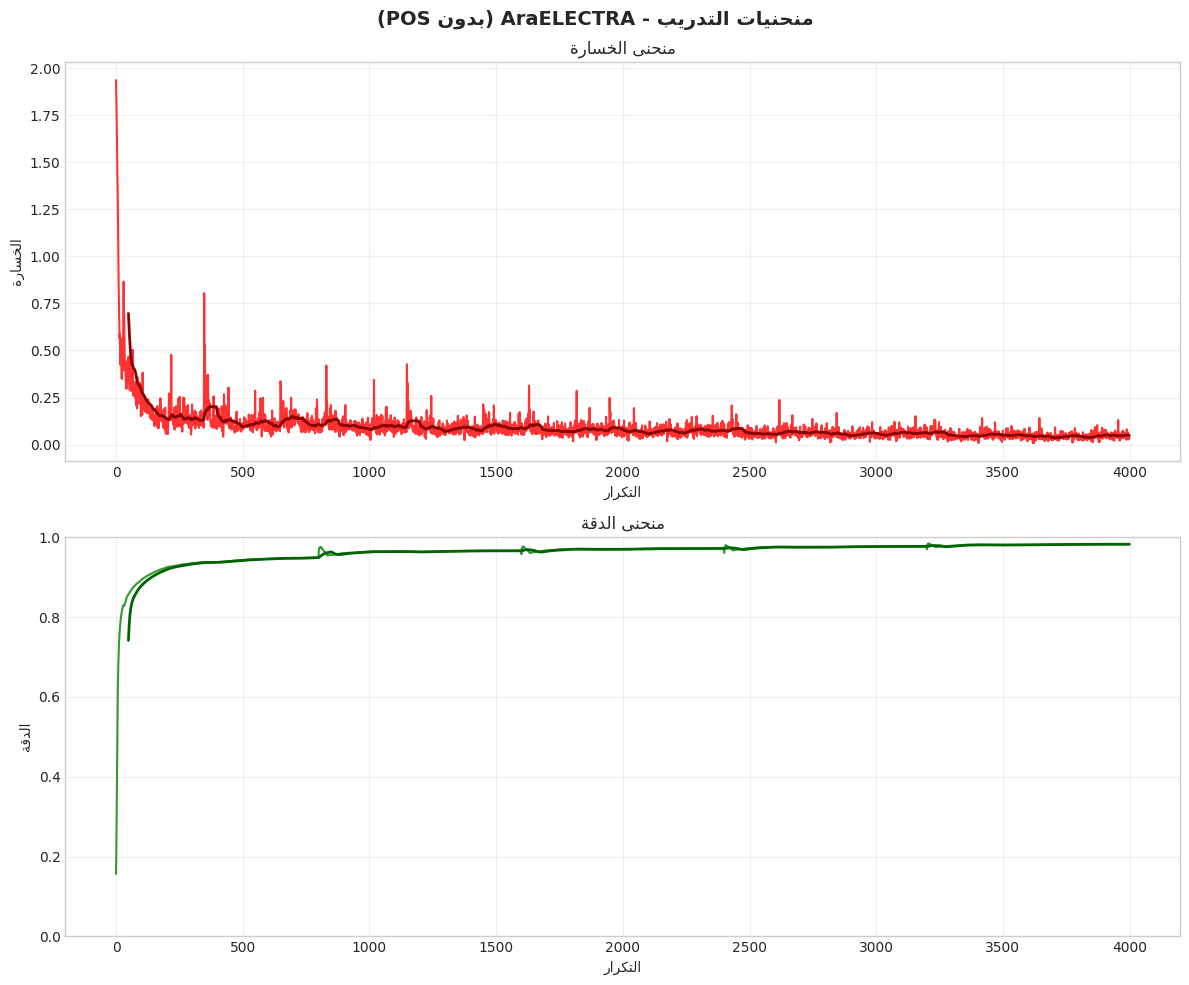

INFO:notebook_20251226_211055_visualizer:تم حفظ الرسم: ./logs/20251226_211055/plots/confusion_matrix_AraELECTRA_without_pos.png


[معلومات] [visualizer] تم حفظ الرسم: ./logs/20251226_211055/plots/confusion_matrix_AraELECTRA_without_pos.png


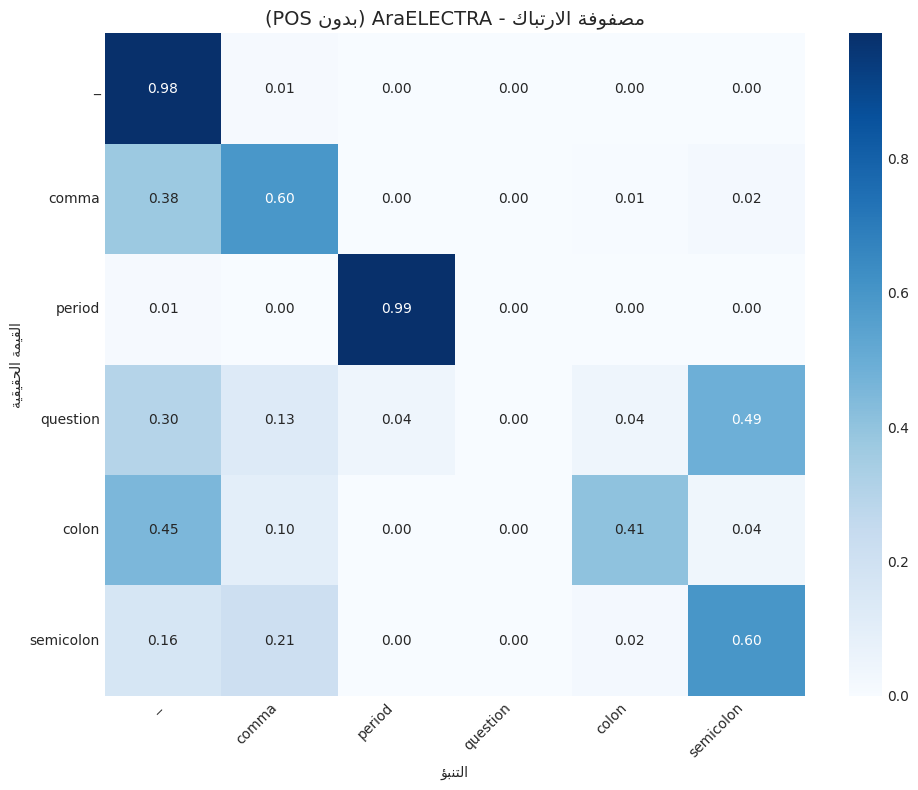

INFO:notebook_20251226_211055_visualizer:تم حفظ الرسم: ./logs/20251226_211055/plots/classification_report_AraELECTRA_without_pos.png


[معلومات] [visualizer] تم حفظ الرسم: ./logs/20251226_211055/plots/classification_report_AraELECTRA_without_pos.png


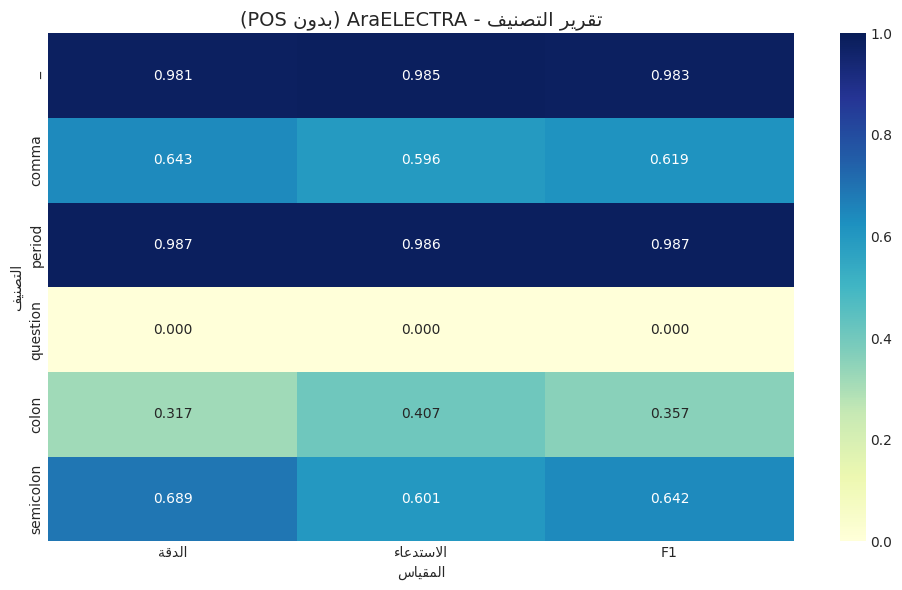

INFO:notebook_20251226_211055_visualizer:تم حفظ الرسم: ./logs/20251226_211055/plots/label_analysis_AraELECTRA_without_pos.png


[معلومات] [visualizer] تم حفظ الرسم: ./logs/20251226_211055/plots/label_analysis_AraELECTRA_without_pos.png


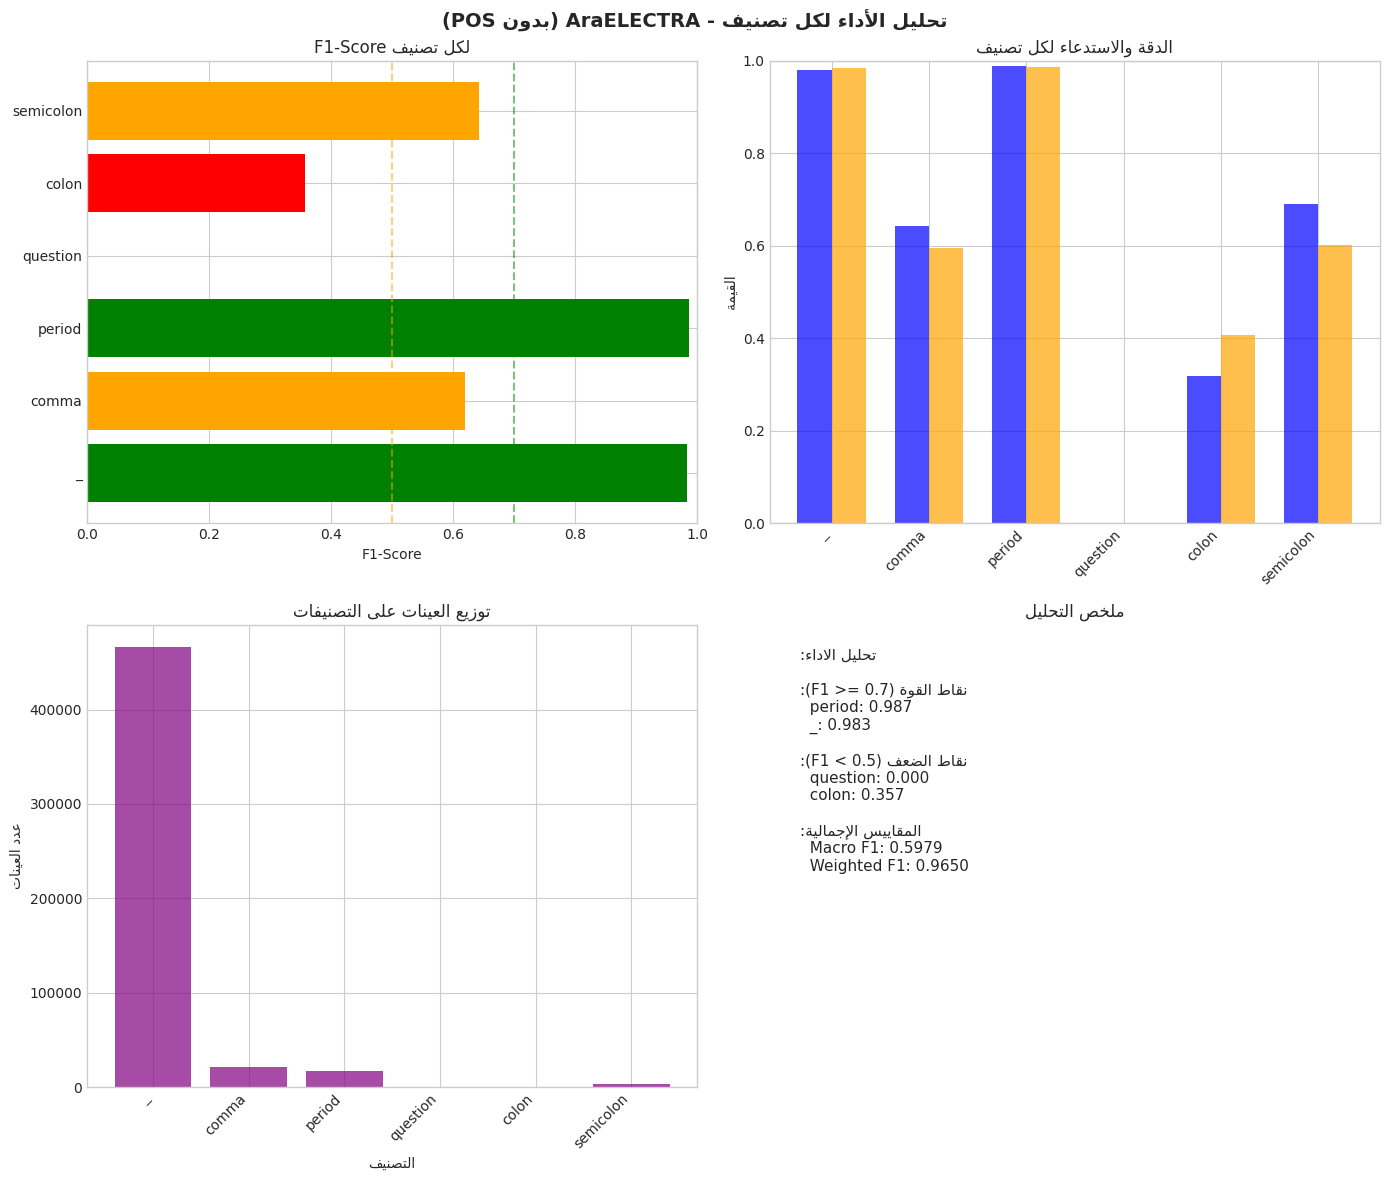

INFO:notebook_20251226_211055_main:SUCCESS: اكتملت التجربة: araelectra_without_pos
INFO:notebook_20251226_211055_main:الدقة: 0.9657
INFO:notebook_20251226_211055_main:Macro F1: 0.5979
INFO:notebook_20251226_211055_main:Weighted F1: 0.9650
INFO:notebook_20251226_211055_main:----------------------------------------
INFO:notebook_20251226_211055_main:النموذج: CAMeLBERT
INFO:notebook_20251226_211055_main:التجربة 3/3: CAMeLBERT (بدون POS)
INFO:notebook_20251226_211055_main:جاري تحميل نموذج جديد...
INFO:notebook_20251226_211055_model_manager:جاري تحميل النموذج: CAMeL-Lab/bert-base-arabic-camelbert-mix


[نجاح] [main] اكتملت التجربة: araelectra_without_pos
[معلومات] [main] الدقة: 0.9657
[معلومات] [main] Macro F1: 0.5979
[معلومات] [main] Weighted F1: 0.9650
[معلومات] [main] ----------------------------------------
[معلومات] [main] النموذج: CAMeLBERT
[معلومات] [main] التجربة 3/3: CAMeLBERT (بدون POS)
[معلومات] [main] جاري تحميل نموذج جديد...
[معلومات] [model_manager] جاري تحميل النموذج: CAMeL-Lab/bert-base-arabic-camelbert-mix


Some weights of BertForTokenClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:notebook_20251226_211055_model_manager:SUCCESS: تم تحميل النموذج بنجاح: CAMeL-Lab/bert-base-arabic-camelbert-mix
DEBUG:notebook_20251226_211055_dataset:تم تهيئة مجموعة البيانات من: ./drive/MyDrive/train
DEBUG:notebook_20251226_211055_dataset:عدد الملفات: 74
DEBUG:notebook_20251226_211055_dataset:استخدام POS: False
DEBUG:notebook_20251226_211055_dataset:تم تهيئة مجموعة البيانات من: ./drive/MyDrive/test
DEBUG:notebook_20251226_211055_dataset:عدد الملفات: 5
DEBUG:notebook_20251226_211055_dataset:استخدام POS: False
INFO:notebook_20251226_211055_camelbert_without_pos:بدء تسجيل النموذج: camelbert
INFO:notebook_20251226_211055_camelbert_without_pos:استخدام تحليل أقسام الكلام: Fals

[نجاح] [model_manager] تم تحميل النموذج بنجاح: CAMeL-Lab/bert-base-arabic-camelbert-mix
[تصحيح] [dataset] تم تهيئة مجموعة البيانات من: ./drive/MyDrive/train
[تصحيح] [dataset] عدد الملفات: 74
[تصحيح] [dataset] استخدام POS: False
[تصحيح] [dataset] تم تهيئة مجموعة البيانات من: ./drive/MyDrive/test
[تصحيح] [dataset] عدد الملفات: 5
[تصحيح] [dataset] استخدام POS: False
[معلومات] [camelbert_without_pos] بدء تسجيل النموذج: camelbert
[معلومات] [camelbert_without_pos] استخدام تحليل أقسام الكلام: False
[معلومات] [camelbert_without_pos] تم تهيئة المدرب
[معلومات] [main] بدء التدريب...
[معلومات] [main] الحقبة 1/5


الحقبة 1: 49it [00:11,  4.15it/s, loss=0.1743, acc=0.9006]INFO:notebook_20251226_211055_camelbert_without_pos:PROGRESS: 50/800 (6.2%) - الخسارة: 0.1743, الدقة: 0.9006
الحقبة 1: 50it [00:11,  4.12it/s, loss=0.1743, acc=0.9006]

[تقدم] [camelbert_without_pos] 50/800 (6.2%) - الخسارة: 0.1743, الدقة: 0.9006


الحقبة 1: 99it [00:25,  3.57it/s, loss=0.1744, acc=0.9269]INFO:notebook_20251226_211055_model_manager:جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/camelbert_without_pos_best


[معلومات] [model_manager] جاري حفظ النموذج في: ./drive/MyDrive/AP/saved_models/camelbert_without_pos_best


ERROR:notebook_20251226_211055_model_manager:خطأ في حفظ النموذج: You are trying to save a non contiguous tensor: `bert.encoder.layer.0.attention.self.query.weight` which is not allowed. It either means you are trying to save tensors which are reference of each other in which case it's recommended to save only the full tensors, and reslice at load time, or simply call `.contiguous()` on your tensor to pack it before saving.
الحقبة 1: 99it [00:25,  3.92it/s, loss=0.1744, acc=0.9269]
ERROR:notebook_20251226_211055_main:خطأ في التجربة camelbert_without_pos: You are trying to save a non contiguous tensor: `bert.encoder.layer.0.attention.self.query.weight` which is not allowed. It either means you are trying to save tensors which are reference of each other in which case it's recommended to save only the full tensors, and reslice at load time, or simply call `.contiguous()` on your tensor to pack it before saving.
ERROR:notebook_20251226_211055_main:Traceback (most recent call last):
  File 

[خطأ] [model_manager] خطأ في حفظ النموذج: You are trying to save a non contiguous tensor: `bert.encoder.layer.0.attention.self.query.weight` which is not allowed. It either means you are trying to save tensors which are reference of each other in which case it's recommended to save only the full tensors, and reslice at load time, or simply call `.contiguous()` on your tensor to pack it before saving.
[خطأ] [main] خطأ في التجربة camelbert_without_pos: You are trying to save a non contiguous tensor: `bert.encoder.layer.0.attention.self.query.weight` which is not allowed. It either means you are trying to save tensors which are reference of each other in which case it's recommended to save only the full tensors, and reslice at load time, or simply call `.contiguous()` on your tensor to pack it before saving.
[خطأ] [main] Traceback (most recent call last):
  File "/tmp/ipython-input-1633466345.py", line 148, in run_all_experiments
    trainer.train_epoch(train_loader, max_iterations)
  Fil

INFO:notebook_20251226_211055_visualizer:تم حفظ الرسم: ./logs/20251226_211055/plots/models_comparison.png


[معلومات] [visualizer] تم حفظ الرسم: ./logs/20251226_211055/plots/models_comparison.png


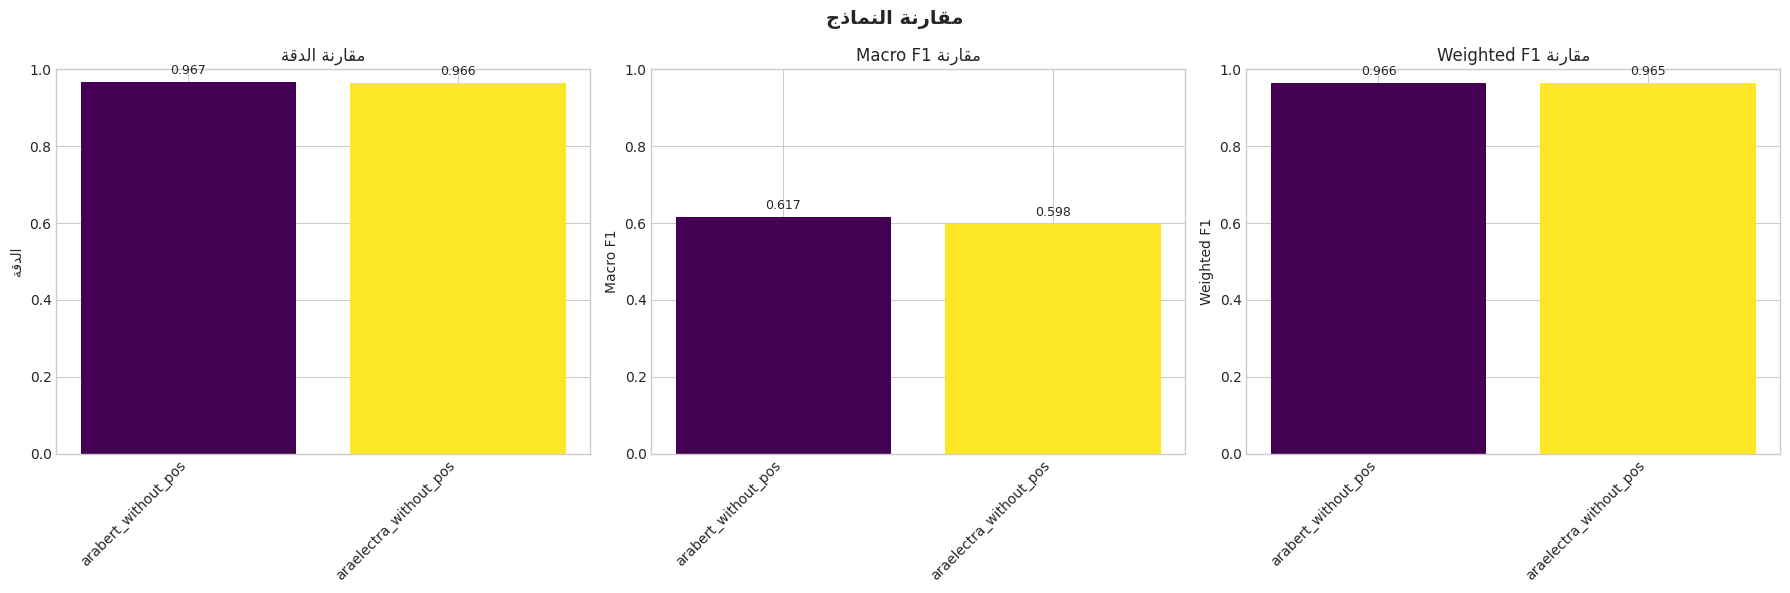

INFO:notebook_20251226_211055_main:تم حفظ النتائج في: ./logs/20251226_211055/all_results.json
INFO:notebook_20251226_211055_main:============================================================
INFO:notebook_20251226_211055_main:اكتملت جميع التجارب
INFO:notebook_20251226_211055_main:============================================================



جدول مقارنة النماذج:
               النموذج  الدقة الكلية  Macro F1  Weighted F1  الدقة (Macro)  الاستدعاء (Macro)
   arabert_without_pos      0.967034  0.616867     0.965689       0.634423           0.602044
araelectra_without_pos      0.965713  0.597851     0.965041       0.603028           0.595829
[معلومات] [main] تم حفظ النتائج في: ./logs/20251226_211055/all_results.json
[معلومات] [main] ============================================================
[معلومات] [main] اكتملت جميع التجارب
[معلومات] [main] ============================================================

اكتملت جميع التجارب!
عدد التجارب المكتملة: 4


In [18]:
# تشغيل جميع التجارب
results |= run_all_experiments(
    models_config=MODELS_CONFIG,
    train_dir=TRAIN_DATA_DIR,
    test_dir=TEST_DATA_DIR,
    epochs=EPOCHS,
    max_iterations=MAX_ITERATIONS_PER_EPOCH,
    with_pos=not RUN_WITH_POS,
    run_cross_validation=False
)

print("\nاكتملت جميع التجارب!")
print(f"عدد التجارب المكتملة: {len(results)}")

### نتائج التشغيل و تفصيل نصي

أظهرت النتائج تفوق النماذج المدربة على POS على النماذج التي بدونها على قياسات الدقة و Weighted F1

في حين كانت أقل على قياس macro F1

تظهر النتائج جلية و واضحة مع مقارنة بداية عملية التعلم على النماذج .. حيث الفرق فعلاً كان واضحاً كما يظهر من المنحنيات التدريبية للدقة و الخسارة على كلا النموذجين


يتضح في ذلك أثر ال POS على نماذج قليلة من البيانات في دعم عملية التعميم لدى النماذج

كما تظهر قوة النماذج المدروسة على سرعة تعلمها من البيانات العربية و استنتاجها النمط ولو بدون وجود POS عندما تبدأ عملية التعلم بالتوسع و التعرض لبيانات أكثر

#عرض ملخص النتائج

##هذه الخلية تعرض ملخصاً لجميع النتائج

In [14]:

# إنشاء جدول الملخص
if results:
    # إنشاء DataFrame للنتائج
    summary_data = []

    for key, result in results.items():
        report = result["classification_report"]

        row = {
            "النموذج": result["display_name"],
            "POS": "نعم" if result["with_pos"] else "لا",
            "الدقة": f"{result['accuracy']:.4f}",
        }

        if "macro avg" in report:
            row["F1 (Macro)"] = f"{report['macro avg']['f1-score']:.4f}"

        if "weighted avg" in report:
            row["F1 (Weighted)"] = f"{report['weighted avg']['f1-score']:.4f}"

        summary_data.append(row)

    summary_df = pd.DataFrame(summary_data)

    print("=" * 60)
    print("ملخص النتائج")
    print("=" * 60)
    print(summary_df.to_string(index=False))
    print("=" * 60)

    # العثور على أفضل نموذج
    best_result = max(results.items(), key=lambda x: x[1]["accuracy"])
    print(f"\nأفضل نموذج: {best_result[1]['display_name']}")
    print(f"الإعداد: {'مع POS' if best_result[1]['with_pos'] else 'بدون POS'}")
    print(f"الدقة: {best_result[1]['accuracy']:.4f}")

ملخص النتائج
    النموذج POS  الدقة F1 (Macro) F1 (Weighted)
AraBERT v02 نعم 0.9831     0.6061        0.9824
 AraELECTRA نعم 0.9819     0.5956        0.9812

أفضل نموذج: AraBERT v02
الإعداد: مع POS
الدقة: 0.9831


#مثال على الاختبار المباشر

##هذه الخلية توضح كيفية استخدام النموذج للتنبؤ بعلامات الترقيم

In [15]:

# اختيار أفضل نموذج للاختبار
if results:
    # العثور على أفضل نموذج
    best_key = max(results.keys(), key=lambda k: results[k]["accuracy"])
    best_result = results[best_key]

    model_name = best_result["model_name"]
    with_pos = best_result["with_pos"]

    # إنشاء المتنبئ
    predictor = create_predictor_from_checkpoint(model_name, with_pos, "best")

    if predictor:
        # جمل للاختبار
        test_sentences = [
            "قال سعيد إني أريد أن أكون سعيداً ألا ترون ذلك",
            "ذهب الطالب إلى المدرسة وقابل أصدقاءه هناك",
            "ما اسمك وأين تسكن",
            "هذا كتاب جميل جداً",
            "لماذا لم تحضر الاجتماع أمس",
        ]

        print("=" * 60)
        print("أمثلة على التنبؤ بعلامات الترقيم")
        print(f"النموذج: {best_result['display_name']}")
        print(f"الإعداد: {'مع POS' if with_pos else 'بدون POS'}")
        print("=" * 60)

        for sentence in test_sentences:
            # التنبؤ
            punctuated = predictor.predict(sentence)

            print(f"\nالمدخل:  {sentence}")
            print(f"المخرج:  {punctuated}")
            print("-" * 40)

        # اختبار مع درجات الثقة
        print("\n" + "=" * 60)
        print("اختبار مع درجات الثقة")
        print("=" * 60)

        test_sentence = "كيف حالك اليوم"
        punctuated, confidence = predictor.predict_with_confidence(test_sentence)

        print(f"\nالمدخل:  {test_sentence}")
        print(f"المخرج:  {punctuated}")
        print("\nدرجات الثقة لكل كلمة:")

        words = test_sentence.split()
        for i, (word, conf) in enumerate(zip(words, confidence)):
            best_label = max(conf, key=conf.get)
            print(f"  {word}: {best_label} ({conf[best_label]:.3f})")

INFO:notebook_20251226_211055_model_manager:جاري تحميل نقطة التفتيش من: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


[معلومات] [model_manager] جاري تحميل نقطة التفتيش من: ./drive/MyDrive/AP/saved_models/arabert_with_pos_best


INFO:notebook_20251226_211055_model_manager:SUCCESS: تم تحميل نقطة التفتيش بنجاح
INFO:notebook_20251226_211055_predictor:تم تهيئة المتنبئ
INFO:notebook_20251226_211055_predictor:تم إنشاء المتنبئ من: arabert


[نجاح] [model_manager] تم تحميل نقطة التفتيش بنجاح
[معلومات] [predictor] تم تهيئة المتنبئ
[معلومات] [predictor] تم إنشاء المتنبئ من: arabert
أمثلة على التنبؤ بعلامات الترقيم
النموذج: AraBERT v02
الإعداد: مع POS

المدخل:  قال سعيد إني أريد أن أكون سعيداً ألا ترون ذلك
المخرج:  قال سعيد إني أريد أن أكون سعيداً ألا ترون ذلك
----------------------------------------

المدخل:  ذهب الطالب إلى المدرسة وقابل أصدقاءه هناك
المخرج:  ذهب الطالب إلى المدرسة وقابل أصدقاءه هناك
----------------------------------------

المدخل:  ما اسمك وأين تسكن
المخرج:  ما اسمك وأين تسكن
----------------------------------------

المدخل:  هذا كتاب جميل جداً
المخرج:  هذا كتاب جميل جداً
----------------------------------------

المدخل:  لماذا لم تحضر الاجتماع أمس
المخرج:  لماذا لم تحضر الاجتماع أمس
----------------------------------------

اختبار مع درجات الثقة

المدخل:  كيف حالك اليوم
المخرج:  كيف حالك اليوم

درجات الثقة لكل كلمة:
  كيف: _ (0.975)
  حالك: _ (0.945)
  اليوم: _ (0.784)


#دالة للاختبار التفاعلي

##هذه الدالة تتيح اختبار النموذج بشكل تفاعلي

In [16]:
def interactive_test(model_name: str = None, with_pos: bool = None):
    """
    اختبار تفاعلي للنموذج

    Args:
        model_name: اسم النموذج (اختياري)
        with_pos: استخدام POS (اختياري)
    """
    # تحديد النموذج
    if model_name is None and results:
        best_key = max(results.keys(), key=lambda k: results[k]["accuracy"])
        model_name = results[best_key]["model_name"]
        with_pos = results[best_key]["with_pos"]

    if model_name is None:
        print("لم يتم تحديد نموذج!")
        return

    # إنشاء المتنبئ
    predictor = create_predictor_from_checkpoint(model_name, with_pos, "best")

    if predictor is None:
        print("فشل في تحميل النموذج!")
        return

    print("=" * 60)
    print("الاختبار التفاعلي")
    print(f"النموذج: {model_name}")
    print(f"POS: {'نعم' if with_pos else 'لا'}")
    print("اكتب 'خروج' للإنهاء")
    print("=" * 60)

    while True:
        # قراءة المدخل
        sentence = input("\nأدخل جملة: ").strip()

        if sentence.lower() in ['خروج', 'exit', 'quit']:
            print("شكراً لاستخدام البرنامج!")
            break

        if not sentence:
            continue

        # التنبؤ
        punctuated = predictor.predict(sentence)

        print(f"النتيجة: {punctuated}")


# مثال على الاستخدام (يمكن تشغيله يدوياً)
# interactive_test()

print("تم تعريف دالة الاختبار التفاعلي")
print("يمكنك تشغيلها باستخدام: interactive_test()")

تم تعريف دالة الاختبار التفاعلي
يمكنك تشغيلها باستخدام: interactive_test()


#إغلاق المسجل وعرض ملخص الجلسة

##هذه الخلية تقوم بإغلاق ملفات السجلات وعرض ملخص الجلسة

In [17]:

# عرض معلومات الجلسة
print("=" * 60)
print("ملخص الجلسة")
print("=" * 60)
print(f"مجلد السجلات: {logger.session_dir}")
print(f"مجلد النماذج: {MODELS_SAVE_DIR}")

# قائمة الملفات المحفوظة
print("\nالملفات المحفوظة:")

# ملفات السجلات
log_files = [f for f in os.listdir(logger.session_dir) if f.endswith('.log')]
print(f"\nملفات السجلات ({len(log_files)}):")
for f in log_files:
    print(f"  - {f}")

# ملفات JSON
json_files = [f for f in os.listdir(logger.session_dir) if f.endswith('.json')]
print(f"\nملفات النتائج ({len(json_files)}):")
for f in json_files:
    print(f"  - {f}")

# ملفات الرسوم
plots_dir = os.path.join(logger.session_dir, "plots")
if os.path.exists(plots_dir):
    plot_files = [f for f in os.listdir(plots_dir) if f.endswith('.png')]
    print(f"\nملفات الرسوم ({len(plot_files)}):")
    for f in plot_files:
        print(f"  - {f}")

# النماذج المحفوظة
if os.path.exists(MODELS_SAVE_DIR):
    model_dirs = [d for d in os.listdir(MODELS_SAVE_DIR) if os.path.isdir(os.path.join(MODELS_SAVE_DIR, d))]
    print(f"\nالنماذج المحفوظة ({len(model_dirs)}):")
    for d in model_dirs:
        print(f"  - {d}")

# إغلاق المسجل
logger.close()

print("\n" + "=" * 60)
print("تم إغلاق الجلسة بنجاح")
print("=" * 60)

INFO:notebook_20251226_211055_main:تم إغلاق جميع ملفات السجلات


ملخص الجلسة
مجلد السجلات: ./logs/20251226_211055
مجلد النماذج: ./drive/MyDrive/AP/saved_models

الملفات المحفوظة:

ملفات السجلات (8):
  - dataset.log
  - arabert_with_pos.log
  - predictor.log
  - visualizer.log
  - main.log
  - model_manager.log
  - camelbert_with_pos.log
  - araelectra_with_pos.log

ملفات النتائج (1):
  - all_results.json

ملفات الرسوم (9):
  - label_analysis_AraELECTRA_with_pos.png
  - confusion_matrix_AraBERT v02_with_pos.png
  - classification_report_AraBERT v02_with_pos.png
  - classification_report_AraELECTRA_with_pos.png
  - confusion_matrix_AraELECTRA_with_pos.png
  - training_curves_AraELECTRA_with_pos.png
  - models_comparison.png
  - label_analysis_AraBERT v02_with_pos.png
  - training_curves_AraBERT v02_with_pos.png

النماذج المحفوظة (5):
  - arabert_with_pos_best
  - arabert_with_pos_last
  - araelectra_with_pos_best
  - araelectra_with_pos_last
  - camelbert_with_pos_best
[معلومات] [main] تم إغلاق جميع ملفات السجلات

تم إغلاق الجلسة بنجاح


TODOs:

 * تدريب أكثف للنماذج المقترحة
 * إظهار نتائج الفروقات المربعة بين كل تدريبين مشتركين بخصيصة
 * عرض إحصائي أكبر و تجريبي للنماذج و إظهار الأسباب التي جعلتها تجيد / تخفق في تصنيف بعض العلامات كما سبق من الدراسة الإحصائية للبيانات
 * دراسة النتائج مع LLM من خلال تدريب الأوامر.
 * تجريب نماذج أكثر و دراسة مواطن قوتها عموماً و ربطها بنتائج نقل التعليم الحاصل عليها
 * تطبيق أنابيب لتدفق البيانات عليها
 * تجريب خيارات POS أكثر و دراسة تأثيرها على النتائج
 * إتاحة النموذج للتجريب
 * دراسة تفصيلية أكبر للنماذج المشابهة و الظروف التدريبية
 فيها
* إدارة أفضل للسجلات و صور العرض ضمن الملف
